In [1]:
import sys

if hasattr(sys.stdout, 'file'):
  sys.stdout = sys.stdout.file

In [2]:
import os
import sys

sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.signal import sosfiltfilt, butter
import logging
import scipy as sp
import matplotlib.pyplot as plt
from deepmeg.data.datasets import EpochsDataset
from deepmeg.preprocessing.transforms import one_hot_encoder
import deepmeg.preprocessing.transforms as transforms

In [4]:
from utils.preprocessing.gaze import preprocess_gaze

In [5]:
plt.set_loglevel('ERROR')

stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))

logging.basicConfig(
    level=logging.ERROR,
    handlers=[stream_handler]
)

In [8]:
def plot_distribution(data: list[int | float], title: str = '', xlabel: str = 'Data', ylabel: str = 'Frequency', bins: int = 30) -> plt.Figure:
    """
    Plot the distribution of data.

    Args:
        data (array-like): The data to be plotted.
        title (str): The title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        bins (int, optional): Number of bins for the histogram. Defaults to 30.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(data, bins=bins, alpha=0.7, color='b')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    return fig


def zscore(matrix: np.ndarray, axis: int = 0) -> np.ndarray:
    """
    Calculate the z-scores of a matrix along the specified axis.

    Args:
        matrix (numpy.ndarray): The input matrix.
        axis (int, optional): The axis along which to calculate the z-scores. Defaults to 0.

    Returns:
        numpy.ndarray: The matrix with z-scores along the specified axis.
    """
    mean = np.mean(matrix, axis=(0, 1), keepdims=True)
    std = np.std(matrix, axis=(0, 1), keepdims=True)
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix


def preprocess_gaze(
    gaze_path: str,
    info_path: str,
    fmin: float = 0.1,
    fmax: float = 3,
    fs: int = 61,
    f_order: int = 4,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Analyze gaze gaze and extract relevant information.

    Args:
        gaze_path (str): Path to the gaze data CSV file.
        info_path (str): Path to the info data CSV file.
        fmin (float, optional): Minimum frequency for bandpass filter. Defaults to 0.1.
        fmax (float, optional): Maximum frequency for bandpass filter. Defaults to 3.
        fs (int, optional): Sampling frequency. Defaults to 61.
        f_order (int, optional): Order of the filter. Defaults to 4.

    Returns:
        tuple: A tuple containing time_series and ar_val. ar_val[:, 0] = arousal, ar_val[:, 1] = valence
    """

    logging.debug("Loading gaze and info data...")
    gaze = pd.read_csv(gaze_path)
    info = pd.read_csv(info_path)

    gaze_time_col = [col for col in gaze.columns if col.startswith('TIME(')][0]
    gaze_start = datetime.strptime(gaze_time_col[5:-1], '%Y/%m/%d %H:%M:%S.%f')
    img_start = datetime.strptime(info.start_time_system[0], '%d/%m/%y %H:%M:%S.%f')

    time_difference = abs((img_start.timestamp() - gaze_start.timestamp()) * 1000)
    if time_difference > 1_000_000:
        raise ValueError('Time difference between start of recording and image presentation is too large')

    fs = gaze.CNT.iloc[-1] / gaze[gaze_time_col].iloc[-1]
    counter = (
        np.array(
            info.time_Images[1::2] - ( ( img_start.timestamp() - gaze_start.timestamp() ) * 1000 )
        ) / 1000 * fs
    ).astype(int)
    
    # FIXME: This is a hack to fix the counter
    counter = np.where(counter < 0, 0, counter)

    arousal = np.array(info.form_response[1::2]).astype(int)
    valence = np.array(info.form_response[2::2]).astype(int)

    logging.debug("Interpolating missing data in gaze...")
    to_interpolate = ['FPOGX', 'FPOGY', 'LPMM', 'RPMM', 'GSR', 'HR']
    gaze[to_interpolate] = gaze[to_interpolate].interpolate(method='linear', axis=0)

    logging.debug("Calculating derived columns...")
    gaze['ep_begin'] = np.zeros(len(gaze))
    gaze['ep_begin'][counter] = 1
    gaze = gaze
    gaze['mean_PMM'] = (gaze.LPMM + gaze.RPMM) / 2
    gaze.mean_PMM = gaze.mean_PMM.rolling(window=10, min_periods=0, center=True).mean()
    gaze.GSR = gaze.GSR.rolling(window=100, min_periods=0, center=True).mean()

    logging.debug("Applying bandpass filter to GSR...")
    low = fmin / (fs / 2)
    high = fmax / (fs / 2)
    sos = butter(f_order, [low, high], btype='bandpass', output='sos')
    gaze.GSR = sosfiltfilt(sos, gaze.GSR)
    gaze.HR = gaze.HR.rolling(window=100, min_periods=0, center=True).mean()

    logging.debug("Extracting epoch information...")
    idx = np.where(gaze.ep_begin == 1)[0]
    ns = len(idx)
    t_range = 300
    vars_ = ['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']

    time_series = np.zeros((ns, t_range, len(vars_)))
    ar_val = np.zeros((ns, 2))
    ar_val[:, 0] = arousal
    ar_val[:, 1] = valence

    for n, i in enumerate(idx[1:-1]):
        time_series[n] = np.array(gaze[vars_][i:(i + t_range)])

    logging.info(f'NaN count in time_series: {np.isnan(time_series).sum()}')

    return time_series, ar_val

In [9]:
import re

arr = []
for file_n in os.listdir(r"C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE"):
    arr.append(re.findall(r'\d+', file_n))
print(arr)

[['0'], ['100'], ['101'], ['102'], ['103'], ['104'], ['105'], ['106'], ['107'], ['108'], ['109'], ['10'], ['110'], ['111'], ['112'], ['113'], ['114'], ['115'], ['116'], ['117'], ['118'], ['119'], ['11'], ['120'], ['121'], ['122'], ['123'], ['124'], ['125'], ['126'], ['127'], ['128'], ['129'], ['12'], ['130'], ['131'], ['132'], ['133'], ['134'], ['135'], ['136'], ['137'], ['138'], ['139'], ['13'], ['140'], ['141'], ['142'], ['143'], ['144'], ['145'], ['146'], ['147'], ['148'], ['149'], ['14'], ['150'], ['151'], ['152'], ['153'], ['154'], ['15'], ['16'], ['17'], ['18'], ['19'], ['1'], ['20'], ['21'], ['22'], ['23'], ['24'], ['25'], ['26'], ['27'], ['28'], ['29'], ['2'], ['30'], ['31'], ['32'], ['33'], ['34'], ['35'], ['36'], ['37'], ['38'], ['39'], ['3'], ['40'], ['41'], ['42'], ['43'], ['44'], ['45'], ['46'], ['47'], ['48'], ['49'], ['4'], ['50'], ['51'], ['52'], ['53'], ['54'], ['55'], ['56'], ['57'], ['58'], ['59'], ['5'], ['60'], ['61'], ['62'], ['63'], ['64'], ['65'], ['66'], ['67']

In [49]:
pd.read_csv(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv').columns

Index(['MEDIA_ID', 'MEDIA_NAME', 'CNT', 'TIME(2022/10/22 13:54:21.706)',
       'TIMETICK(f=10000000)', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID',
       'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'CX', 'CY', 'CS', 'USER', 'LPCX',
       'LPCY', 'LPD', 'LPS', 'LPV', 'RPCX', 'RPCY', 'RPD', 'RPS', 'RPV',
       'BKID', 'BKDUR', 'BKPMIN', 'LPMM', 'LPMMV', 'RPMM', 'RPMMV', 'DIAL',
       'DIALV', 'GSR', 'GSRV', 'HR', 'HRV', 'HRP', 'TTL0', 'TTL1', 'TTLV',
       'PIXS', 'PIXV', 'AOI', 'SACCADE_MAG', 'SACCADE_DIR', 'VID_FRAME',
       'Unnamed: 51'],
      dtype='object')

In [95]:
subject = 80#arr[1][0]

ts, labels = preprocess_gaze(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
    fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv',
)
print(subject)

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


134


Shapiro test p value is zero because of the number of points (too big).

The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥ 50.

In [110]:
def count_zeros(arr):
    return np.sum(arr == 0)



def percentage_per_repeating_value(arr):
    arr = np.round(arr, 3)
    unique_values, value_counts = np.unique(arr, return_counts=True)
    repeating_values = unique_values[value_counts > 1]

    percentages = {}
    total_elements = arr.shape[0]*arr.shape[1]
    for value in repeating_values:
        # count = np.count_nonzero(arr == value)
        count = np.sum(arr == value)
        percentage =  np.round(count / total_elements, 3)
        if percentage > 1e-3:
            percentages[value] = percentage

    return percentages

In [97]:
for i in range(ts.shape[-1]):
    # print(count_zeros(ts[:, :, i])/(ts.shape[0]*ts.shape[1]))
    print(percentage_per_repeating_value(ts[:, :, i]))

{-0.667: 0.0, -0.66: 0.0, -0.657: 0.0, -0.643: 0.0, -0.597: 0.0, -0.595: 0.0, -0.588: 0.0, -0.58: 0.0, -0.52: 0.0, -0.468: 0.0, -0.415: 0.0, -0.192: 0.0, -0.188: 0.0, -0.179: 0.0, -0.139: 0.0, -0.122: 0.0, -0.118: 0.0, -0.111: 0.0, -0.09: 0.0, -0.088: 0.0, -0.086: 0.0, -0.081: 0.0, -0.074: 0.0, -0.071: 0.0, -0.068: 0.0, -0.066: 0.0, -0.065: 0.0, -0.062: 0.0, -0.061: 0.0, -0.058: 0.0, -0.057: 0.0, -0.056: 0.0, -0.055: 0.0, -0.054: 0.0, -0.053: 0.0, -0.052: 0.0, -0.051: 0.0, -0.05: 0.0, -0.049: 0.0, -0.048: 0.0, -0.047: 0.0, -0.046: 0.0, -0.045: 0.0, -0.044: 0.0, -0.043: 0.0, -0.041: 0.0, -0.04: 0.0, -0.039: 0.0, -0.037: 0.0, -0.034: 0.0, -0.033: 0.0, -0.032: 0.0, -0.031: 0.0, -0.03: 0.0, -0.029: 0.0, -0.028: 0.0, -0.027: 0.0, -0.026: 0.0, -0.025: 0.0, -0.024: 0.0, -0.023: 0.0, -0.022: 0.0, -0.021: 0.0, -0.02: 0.0, -0.018: 0.0, -0.017: 0.0, -0.016: 0.0, -0.014: 0.0, -0.011: 0.0, -0.01: 0.0, -0.009: 0.0, -0.008: 0.0, -0.005: 0.0, -0.004: 0.0, -0.002: 0.0, -0.001: 0.0, 0.0: 0.083, 0.001: 0

In [96]:
count_zeros(ts[:, :, -1])/(ts.shape[0]*ts.shape[1])

0.37636075949367087

In [74]:
for i in range(ts.shape[-1]):
    print(count_zeros(ts[:, :, i])/(ts.shape[0]*ts.shape[1]))

0.08282700421940928
0.08282700421940928
0.006329113924050633
0.006329113924050633
0.37636075949367087


In [103]:
import logging
logging.getLogger('pandas').setLevel(logging.CRITICAL)

In [115]:
subject = 3
ts, labels = preprocess_gaze(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
    fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv',
)
for i in range(ts.shape[-1]):
        stat_dict = percentage_per_repeating_value(ts[:, :, i])
        print({k: v for k, v in stat_dict.items() if v > 0.03})

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


{0.0: 0.158}
{0.0: 0.159}
{}
{}
{}


In [116]:
for subject in range(153):
    ts, labels = preprocess_gaze(
        fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
        fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv',
    )
    excluded_epochs = list()
    for i in range(ts.shape[-1]):
        for j in range(len(ts)):
            stat_dict = percentage_per_repeating_value(ts[j, :, i])

            if any([val > 0.1  for val in stat_dict.values()]):
                excluded_epochs.append(j)
    excluded_epochs = list(set(excluded_epochs))
    logging.infp(f'Subject {subject}: {len(excluded_epochs)} epochs excluded')


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


subject 1


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


subject 3


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


subject 5


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


subject 6


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


subject 7


C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


KeyboardInterrupt: 

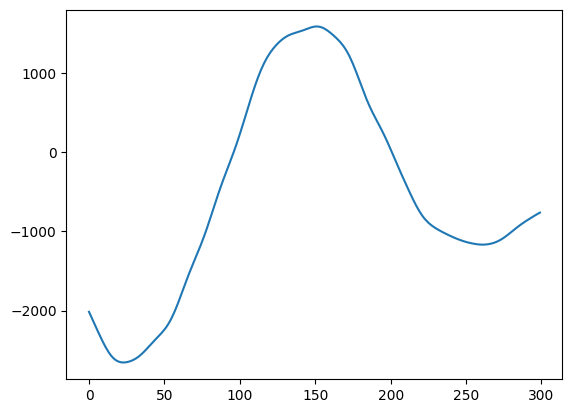

In [78]:
plt.plot(ts[10, :, -2].T)

(94800,)
ShapiroResult(statistic=0.8399126529693604, pvalue=0.0)


c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


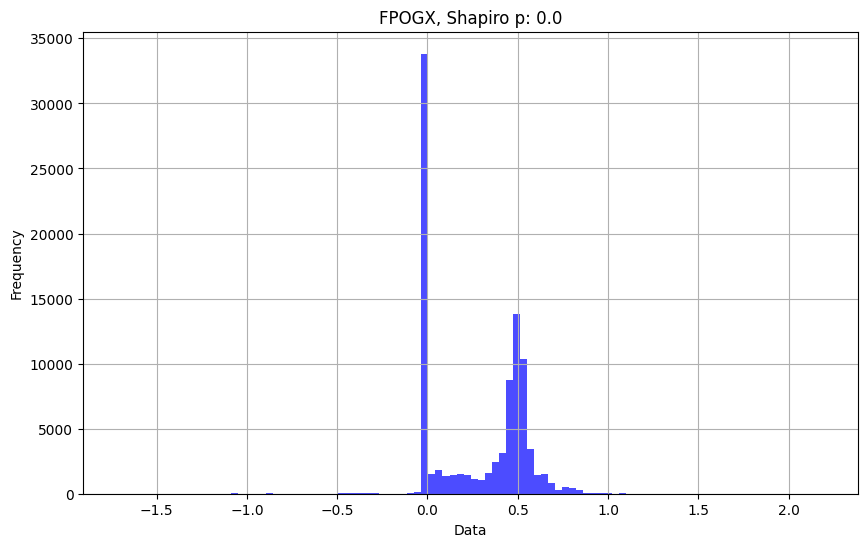

(94800,)
ShapiroResult(statistic=0.8454791307449341, pvalue=0.0)


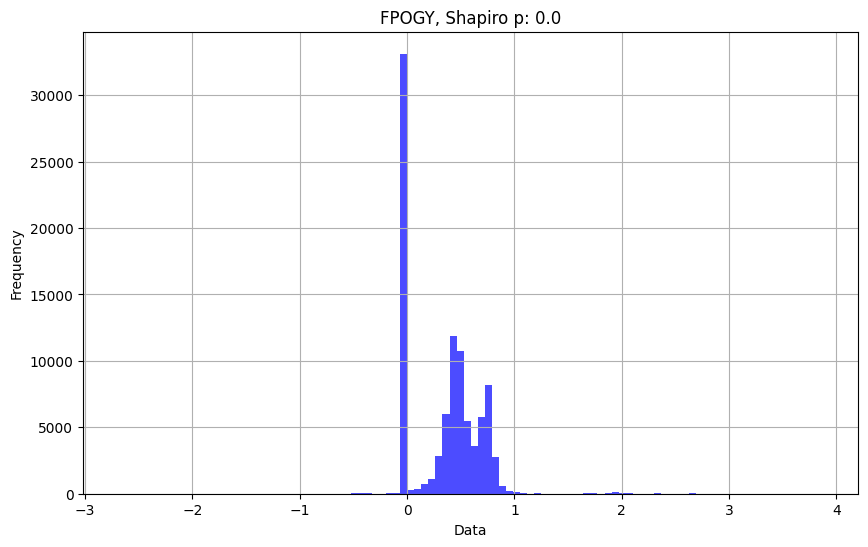

(94800,)
ShapiroResult(statistic=0.7908015251159668, pvalue=0.0)


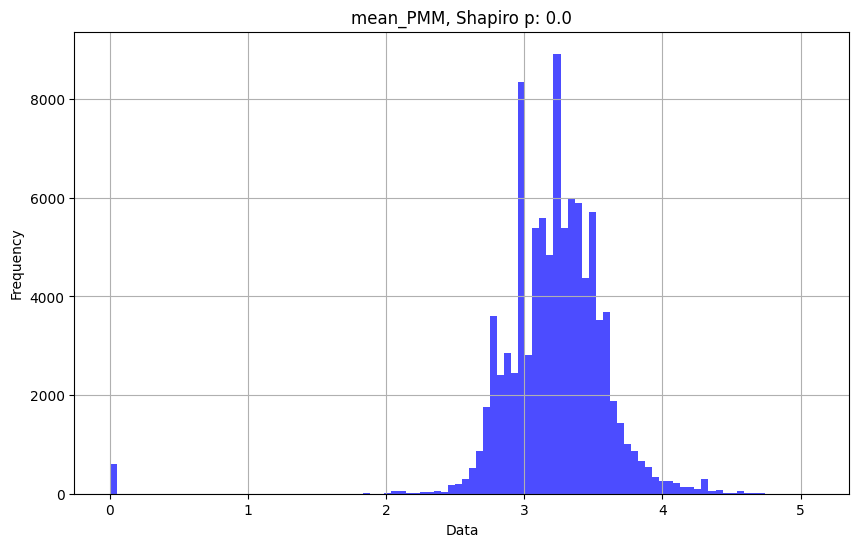

(94800,)
ShapiroResult(statistic=0.7376024127006531, pvalue=0.0)


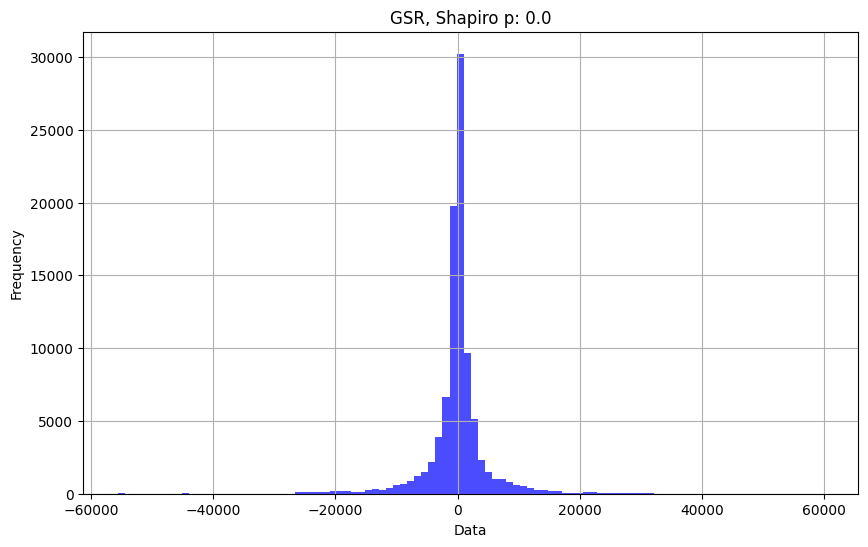

(94800,)
ShapiroResult(statistic=0.8064811825752258, pvalue=0.0)


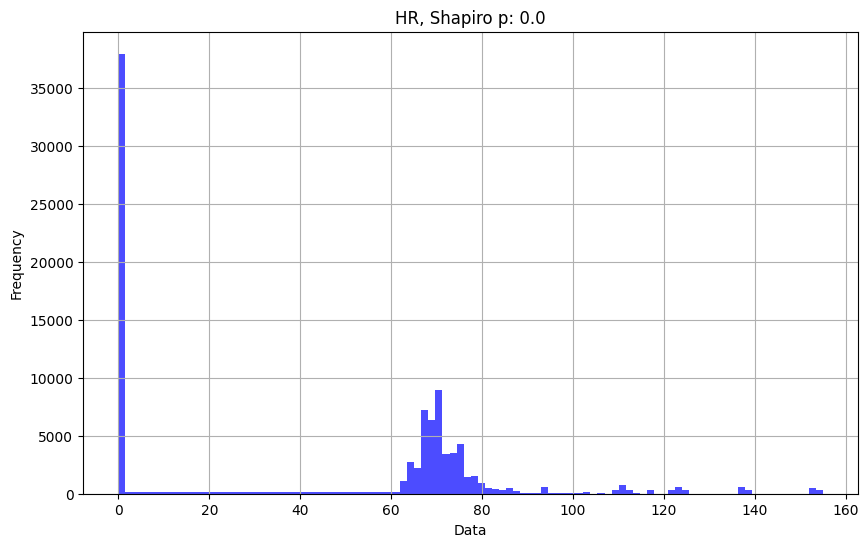

In [24]:
for i, feat_name in enumerate(['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']):
    data = np.reshape(ts[:, :, i], -1)
    print(data.shape)
    print(sp.stats.shapiro(data))
    fig = plot_distribution(data, title=f'{feat_name}, Shapiro p: {sp.stats.kstest(data, "norm").pvalue}', bins=100)
    plt.show()

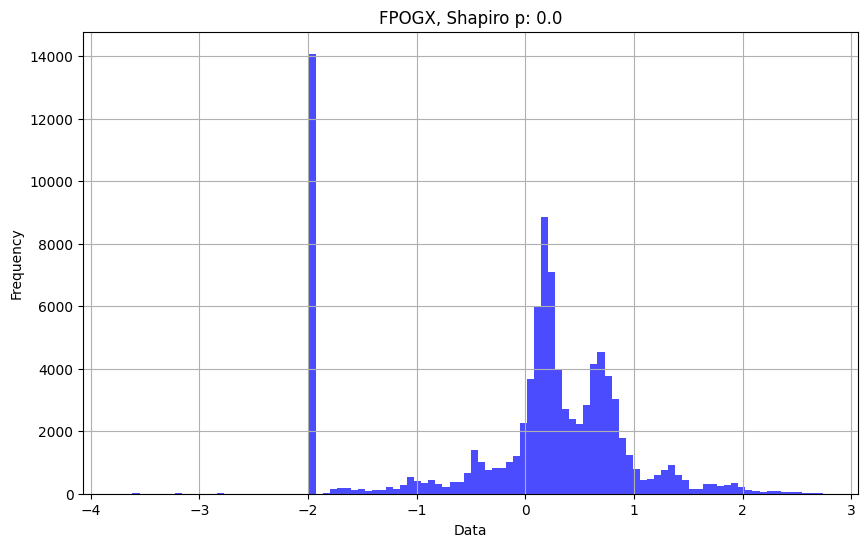

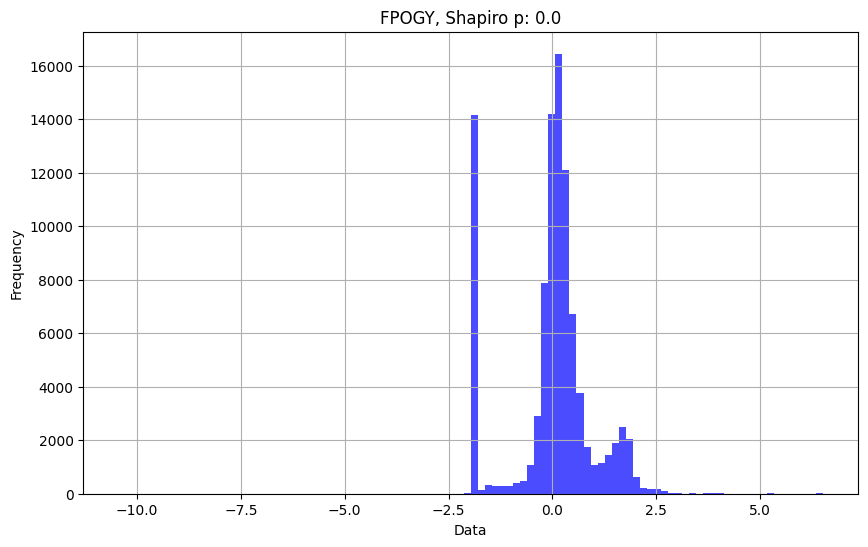

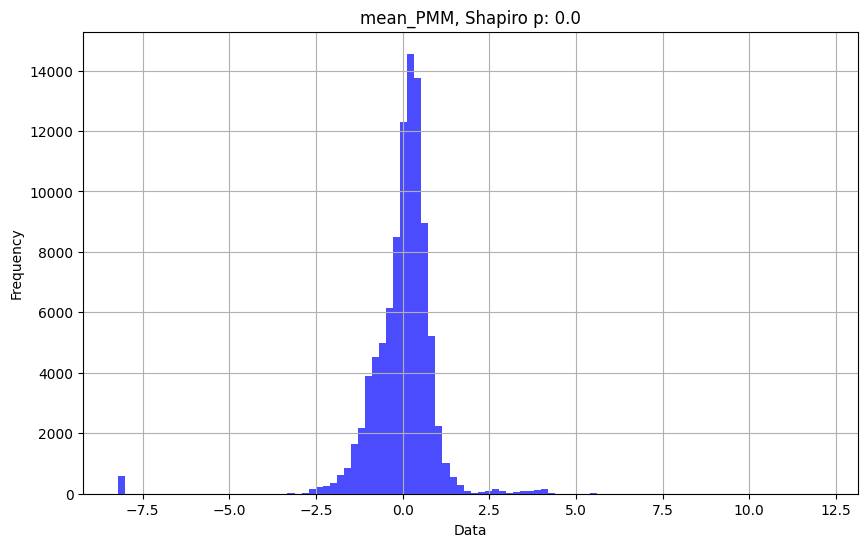

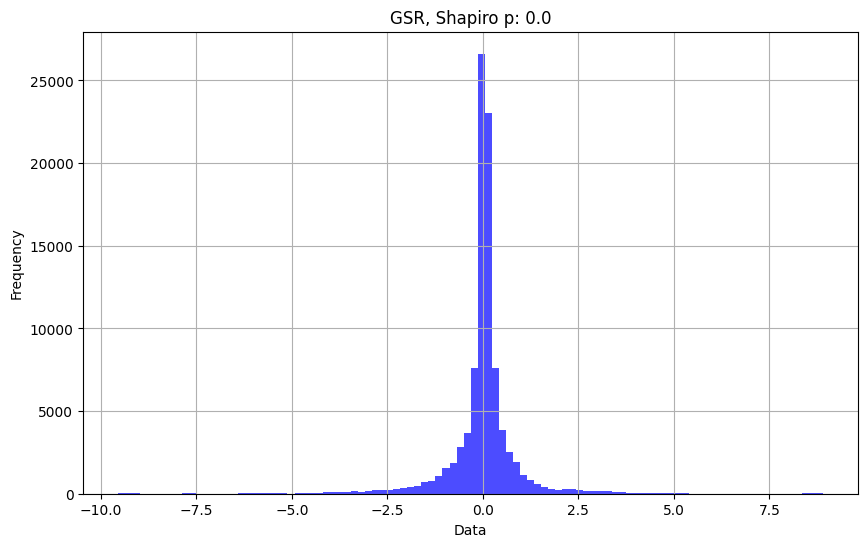

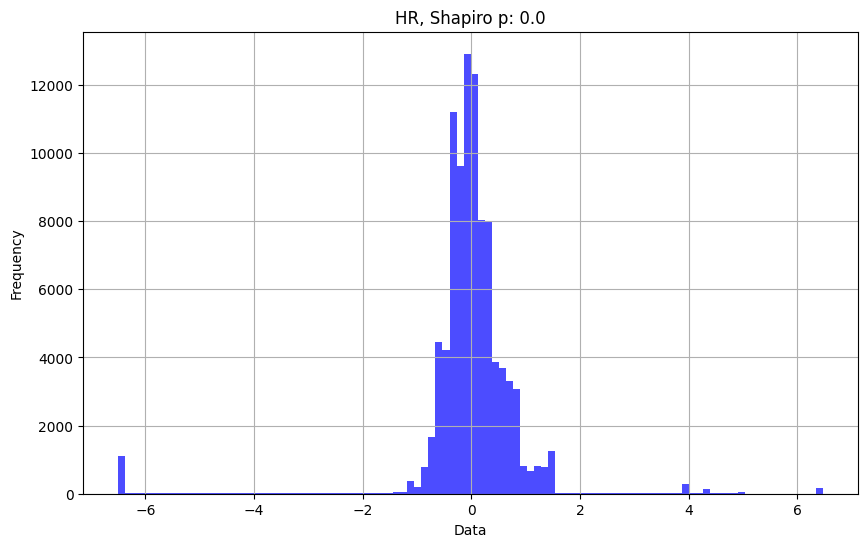

In [17]:
ts = zscore(ts, axis=(0, 1))

for i, feat_name in enumerate(['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']):
    data = np.reshape(ts[:, :, i], -1)
    fig = plot_distribution(data, title=f'{feat_name}, Shapiro p: {sp.stats.shapiro(data).pvalue}', bins=100)
    plt.show()

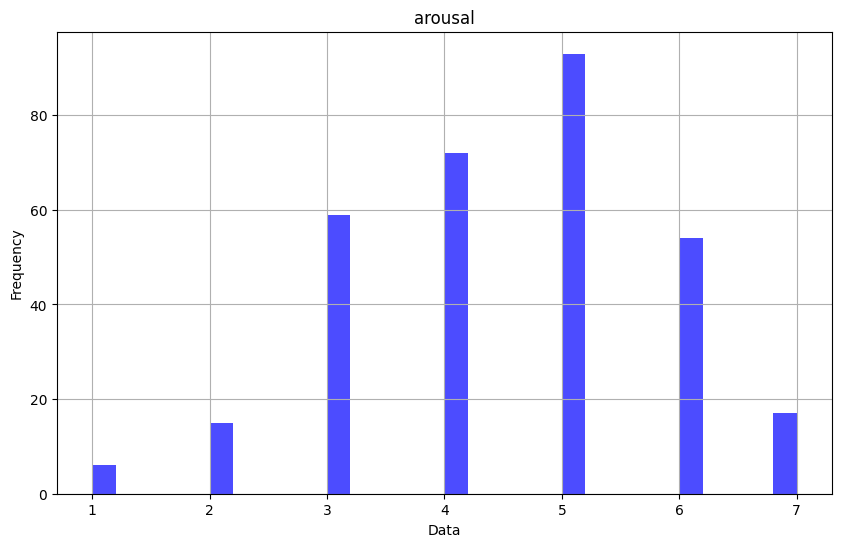

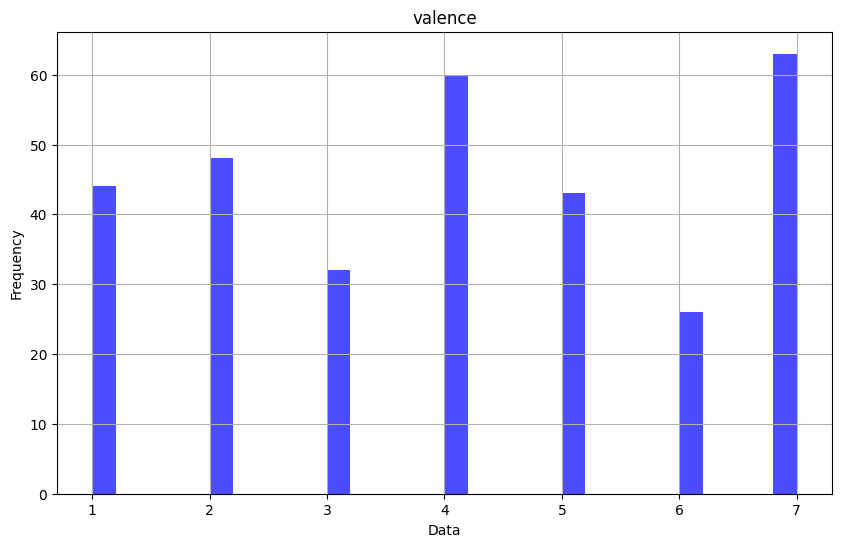

In [18]:
for i, label_type in enumerate(['arousal', 'valence']):
    fig = plot_distribution(labels[:, i], title=label_type)
    plt.show()

In [19]:
def balance(X: np.ndarray, Y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    classes, classes_samples = np.unique(Y, return_counts=True)
    smallest_class = classes[np.argsort(classes_samples)][0]
    samples = classes_samples.min()
    X_list, Y_list = list(), list()
    stat = {class_: 0 for class_ in classes}

    for x, y in zip(X, Y):
        if y != smallest_class and stat[y] >= samples:
            continue
        else:
            Y_list.append(y)
            X_list.append(x)
            stat[y] += 1

    return np.array(X_list), np.array(Y_list)

In [20]:
#subject = arr[0][0]

#ts, labels = preprocess_gaze(
#    f'/home/user/Downloads/User {subject}_all_gaze.csv',
 #   f'/home/user/Downloads/subject-{subject}.csv',
#)
ts = zscore(ts, axis=(0, 1))

X, Y = ts, one_hot_encoder(labels[:, 0])
dataset = EpochsDataset(
    (X, Y), savepath=f'../datasets/arousal_{subject}',
    # transform=transforms.zscore
)
dataset.save(f'../data/arousal_{subject}.pt')

X, Y = ts, one_hot_encoder(labels[:, 1])
dataset = EpochsDataset(
    (X, Y),
    savepath=f'../datasets/valence_{subject}',
    # transform=transforms.zscore
)
dataset.save(f'../data/valence_{subject}.pt')

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


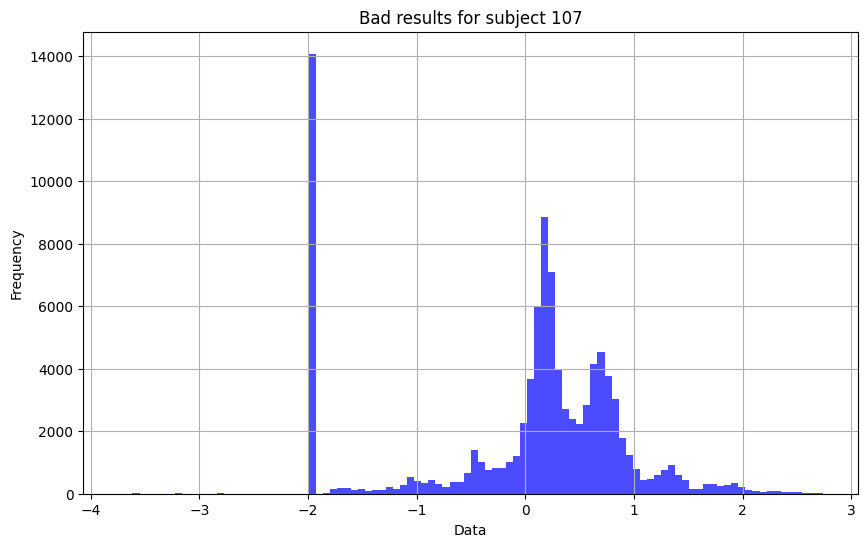

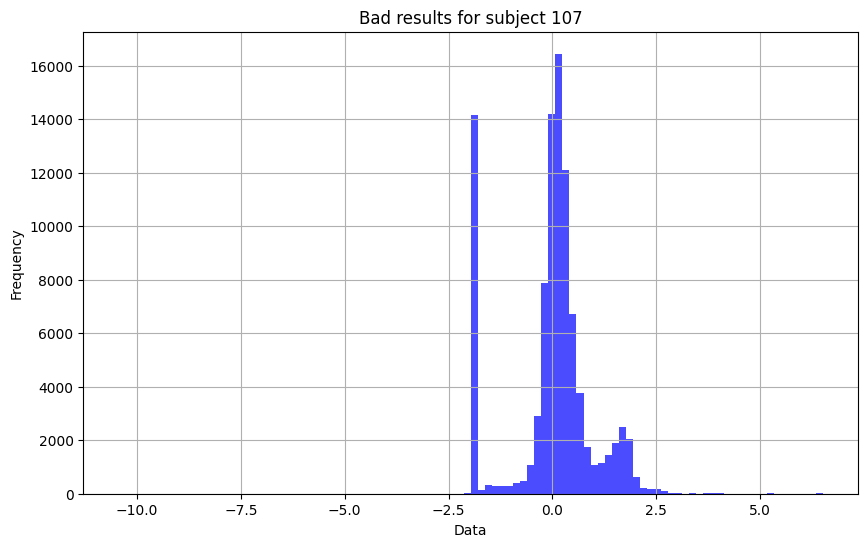

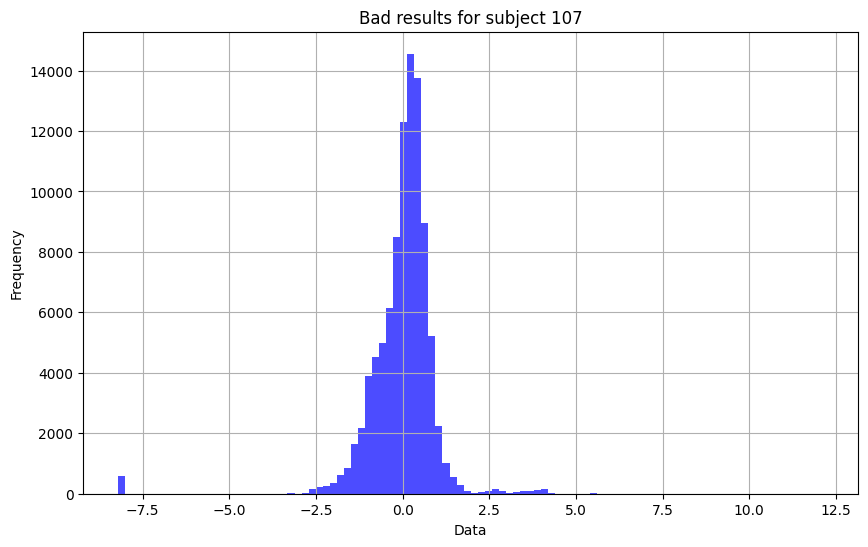

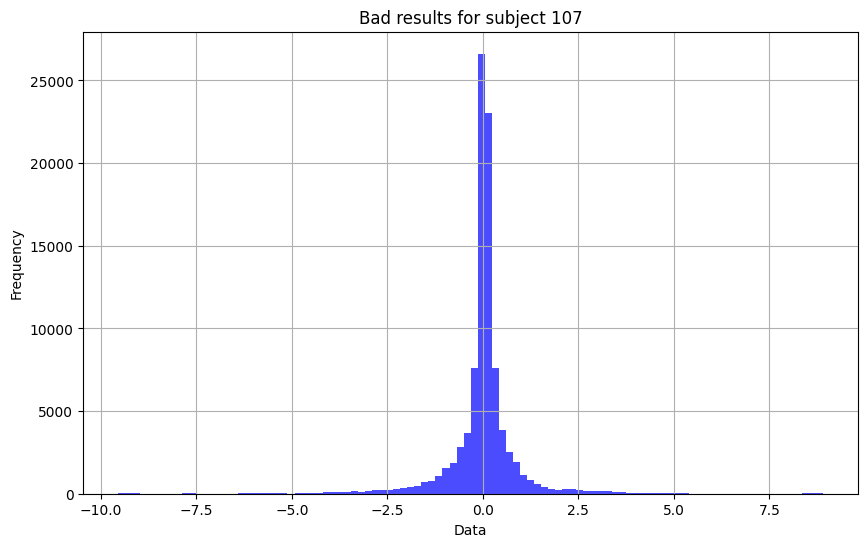

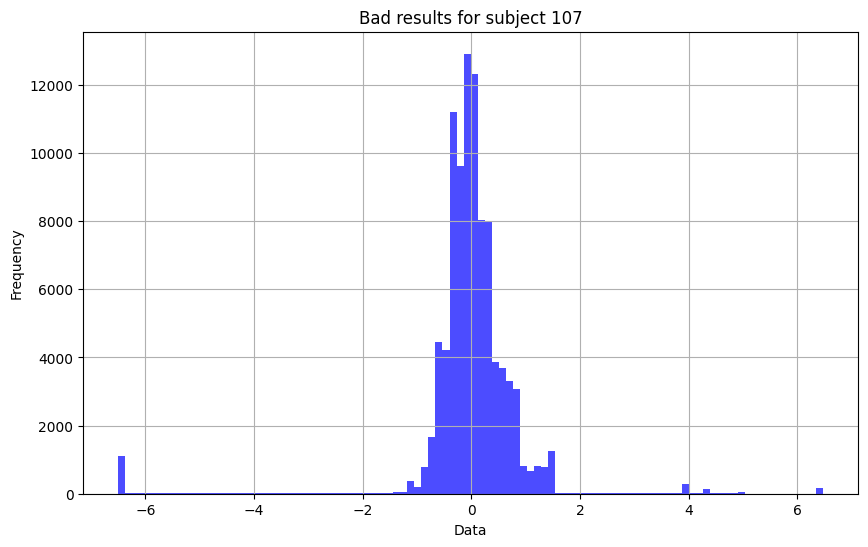

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


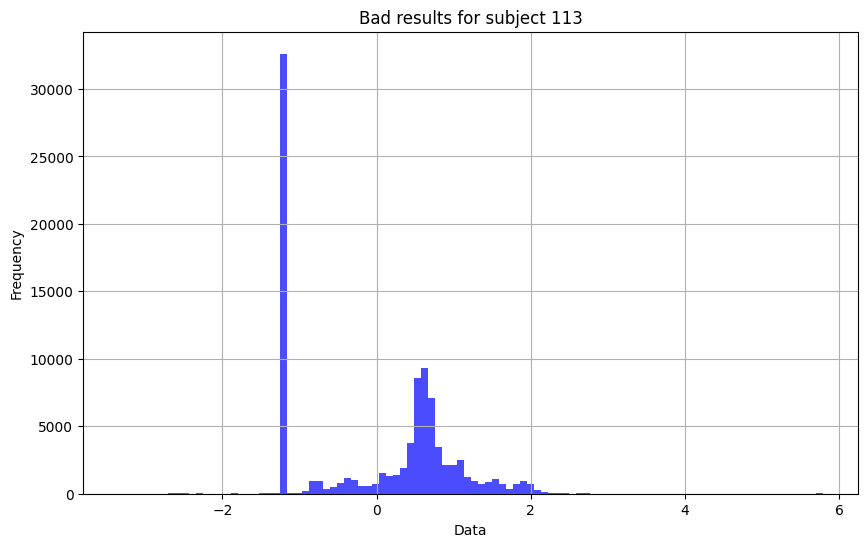

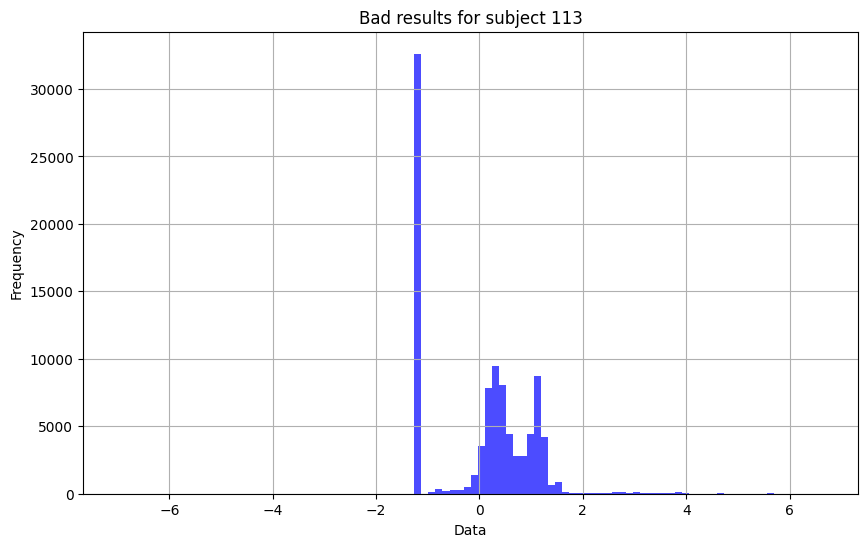

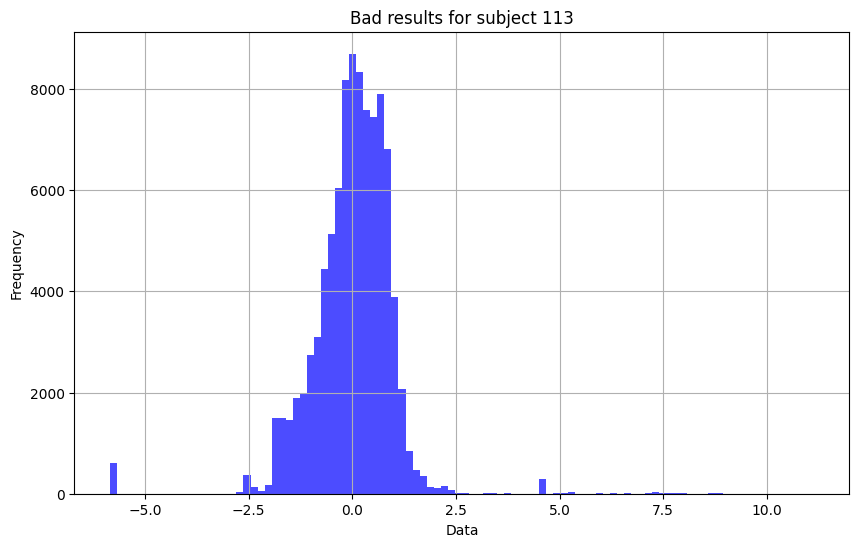

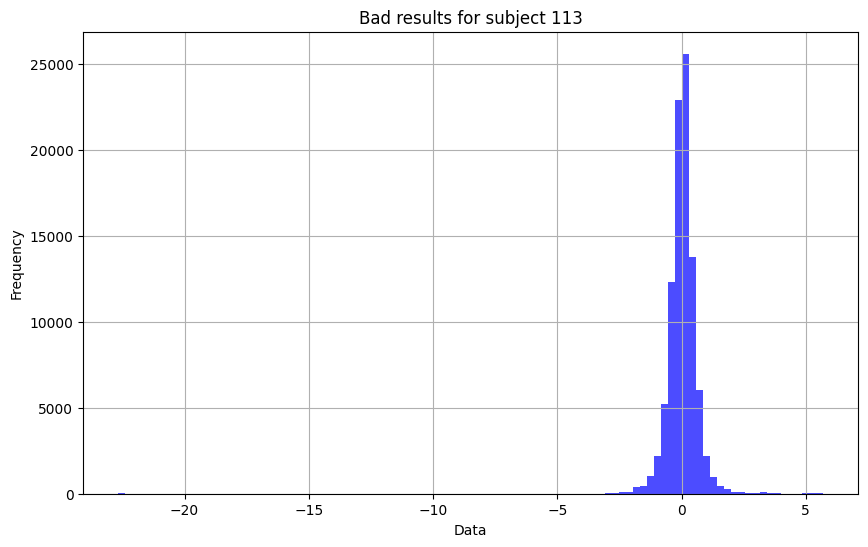

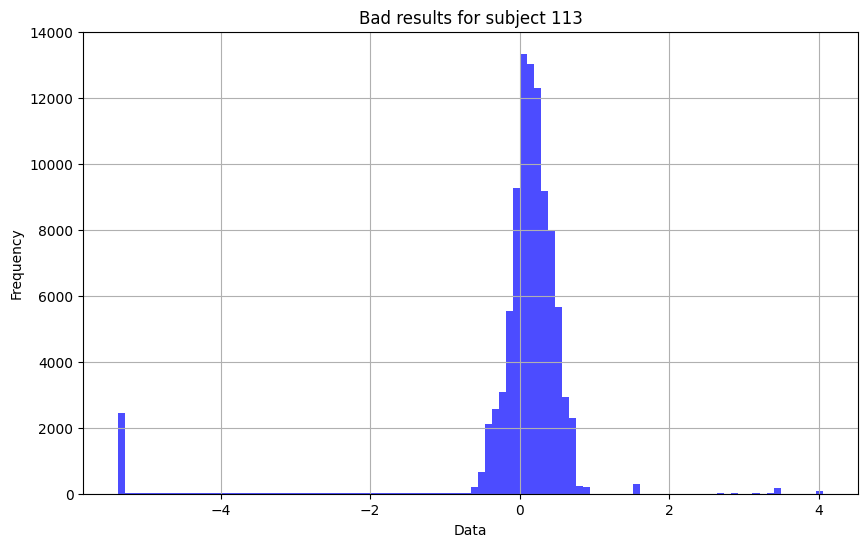

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


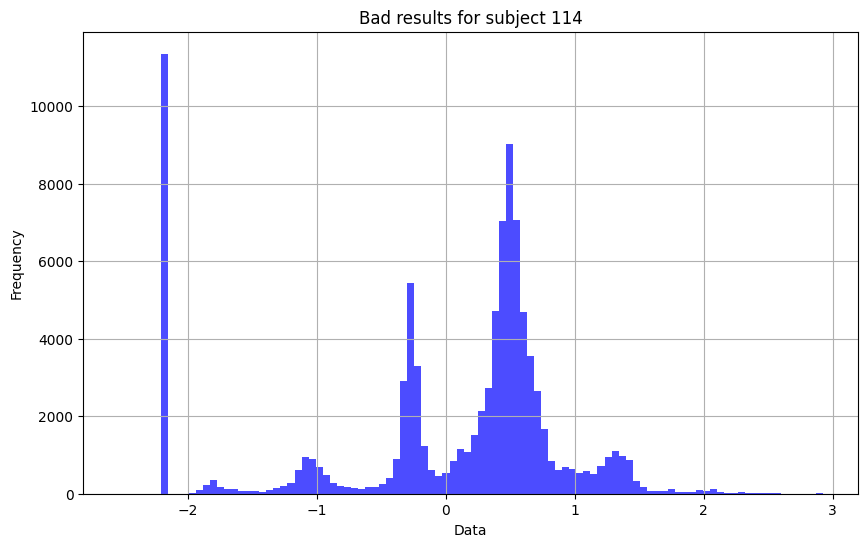

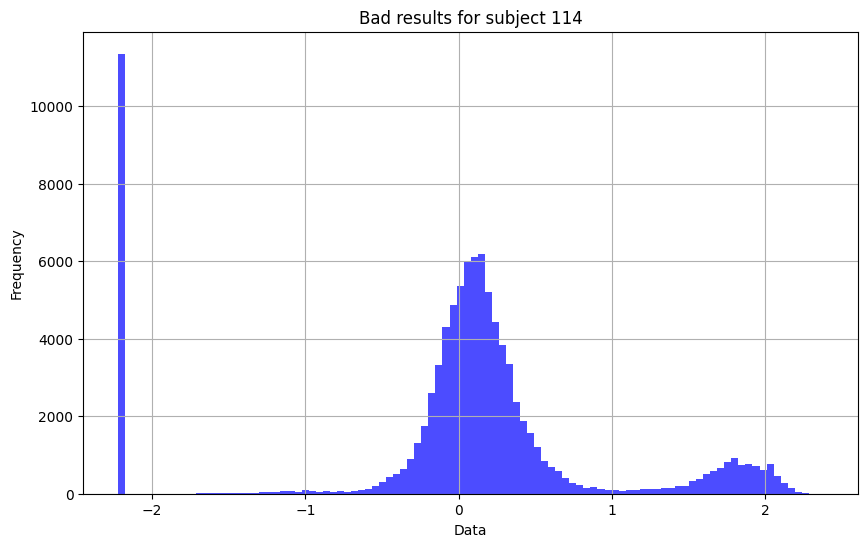

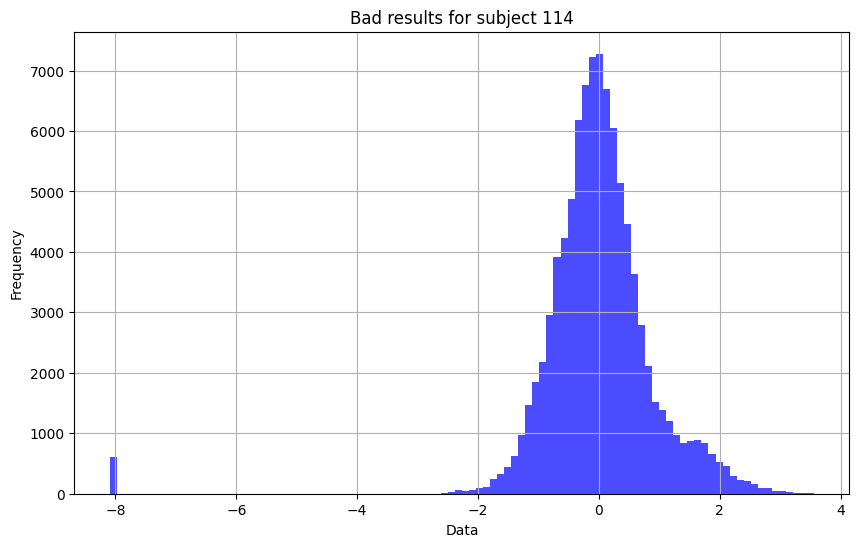

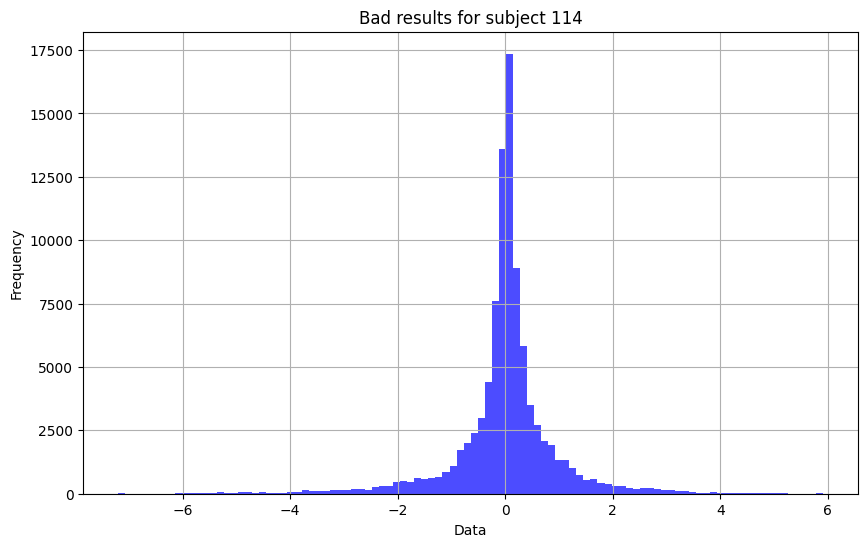

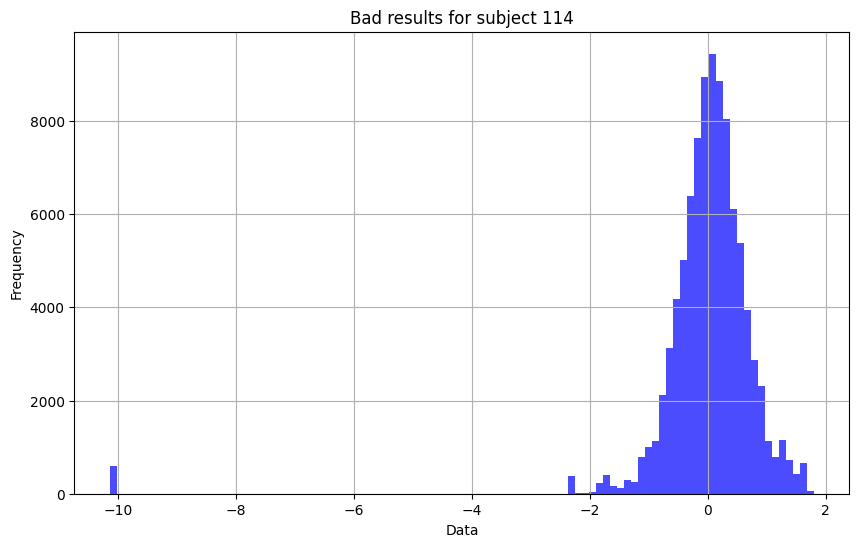

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


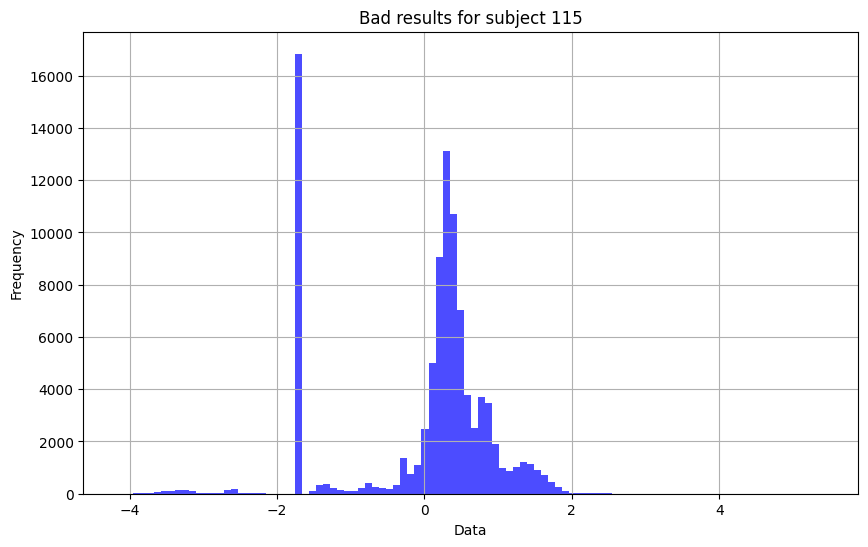

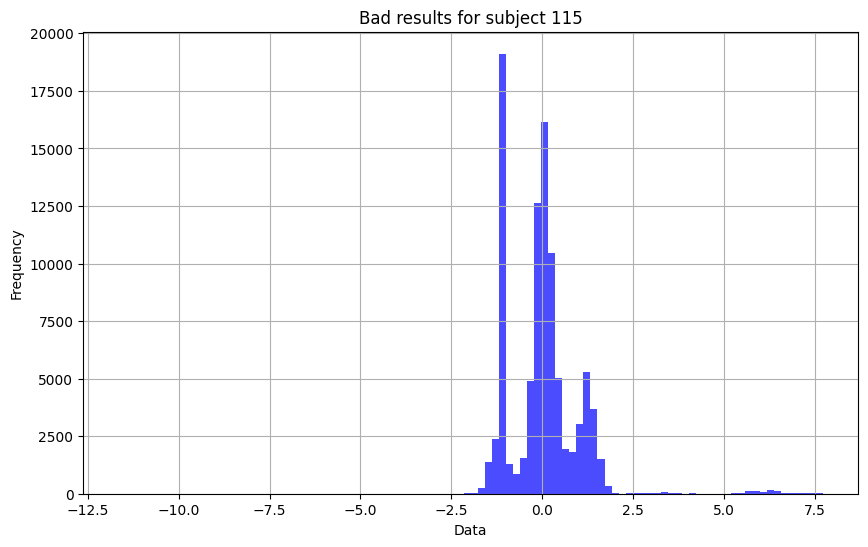

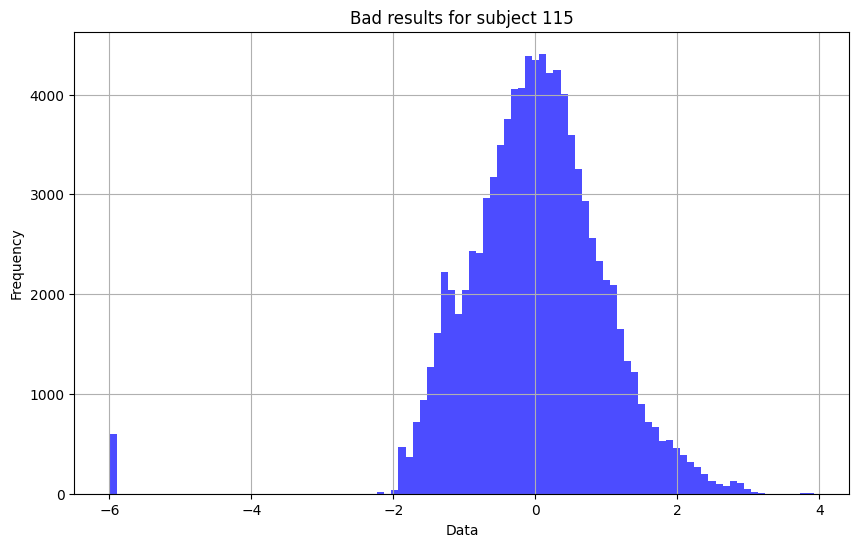

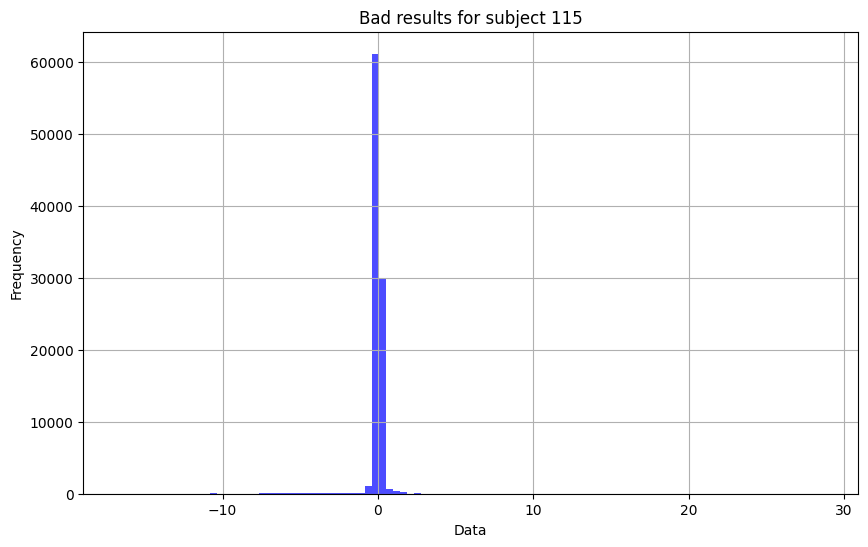

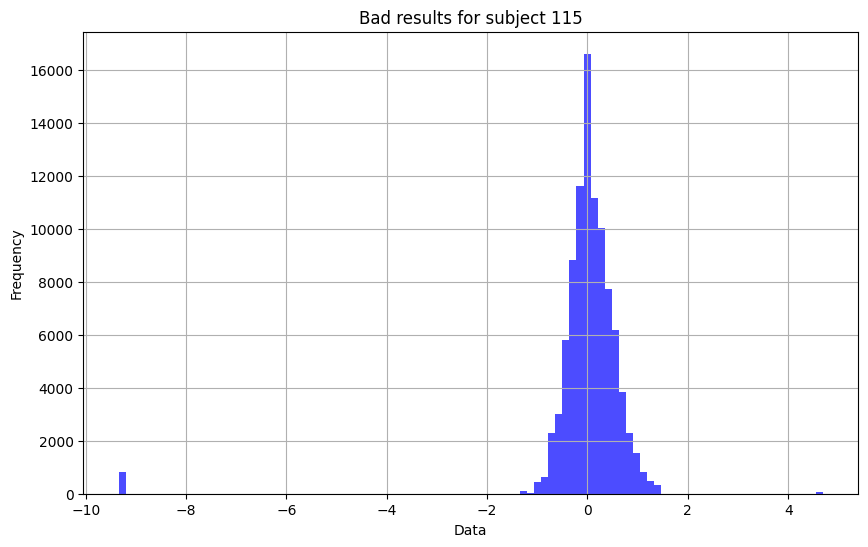

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


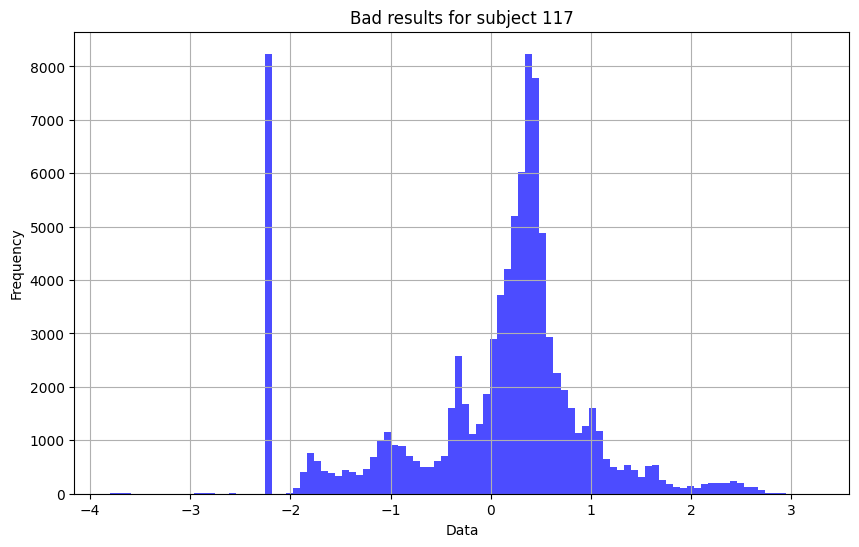

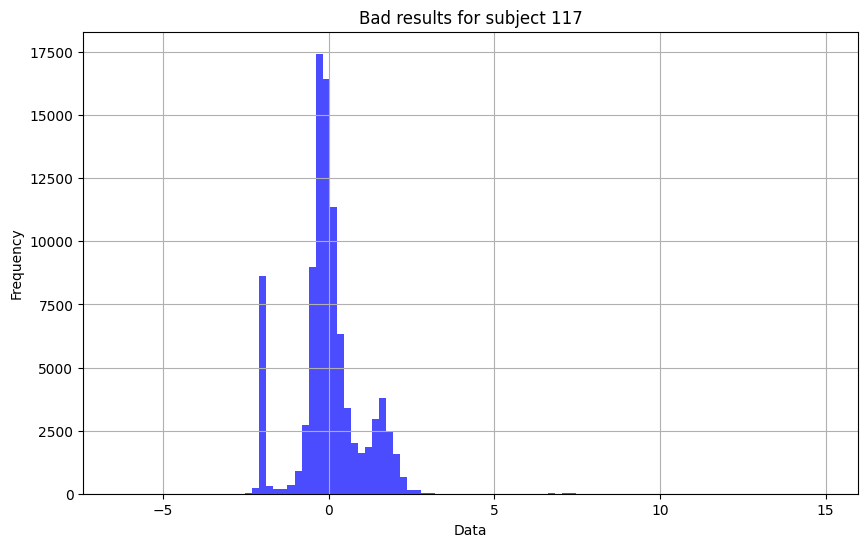

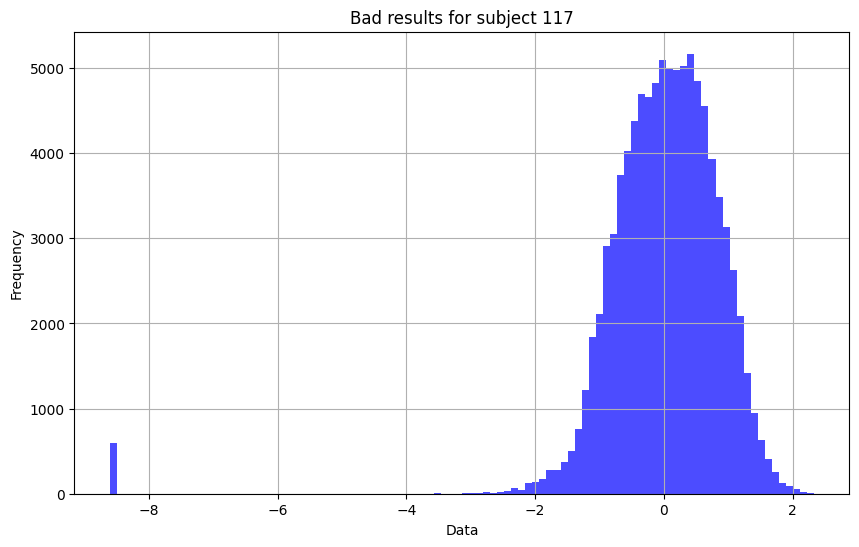

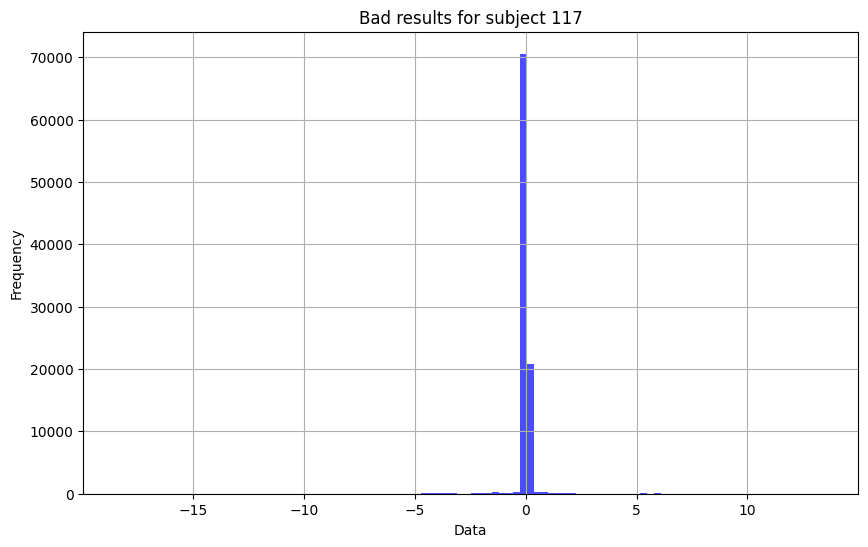

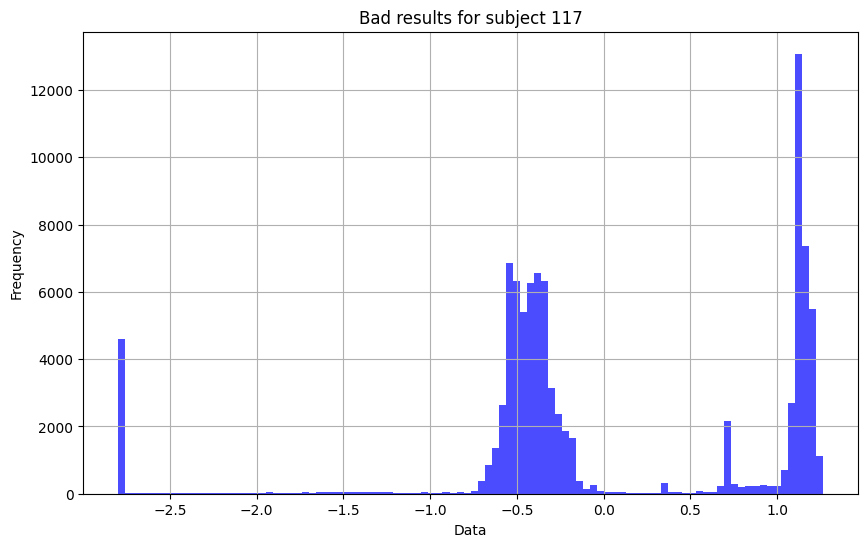

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


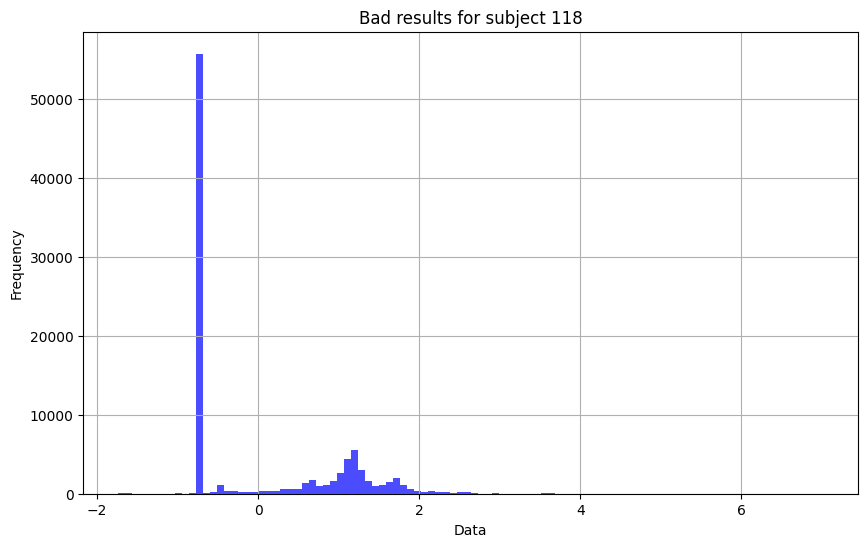

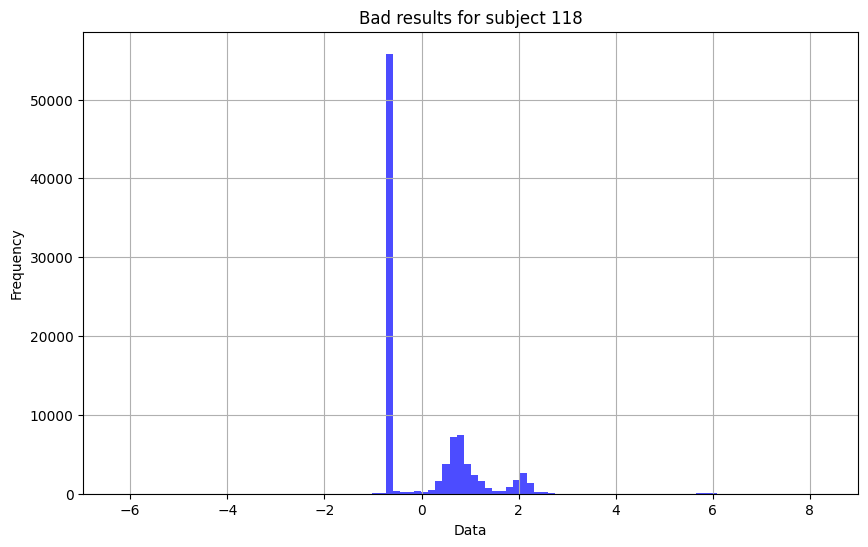

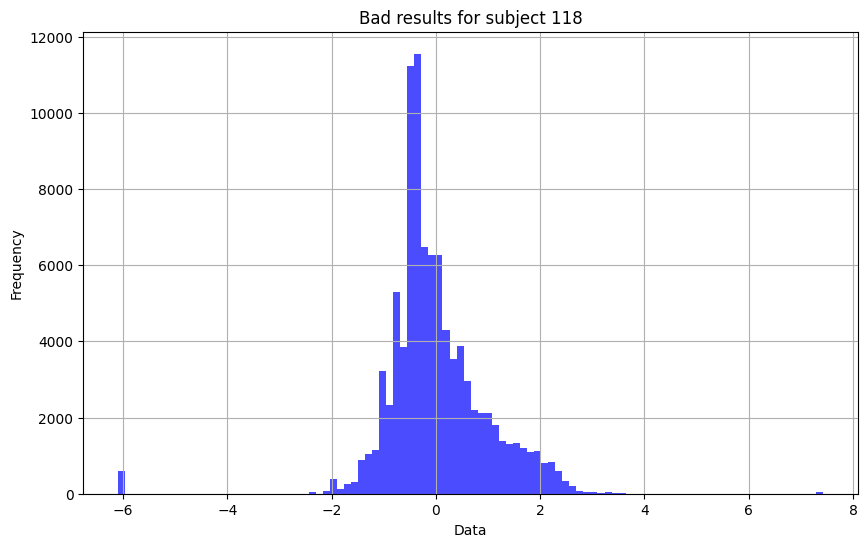

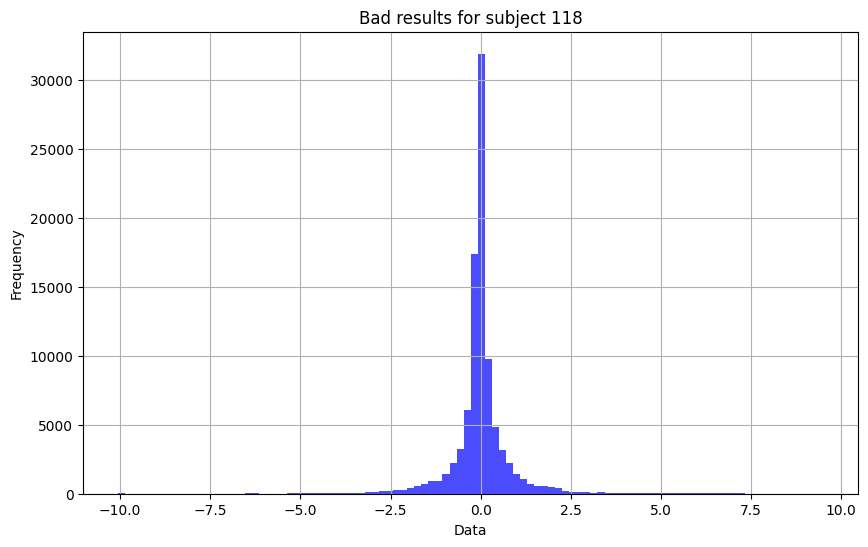

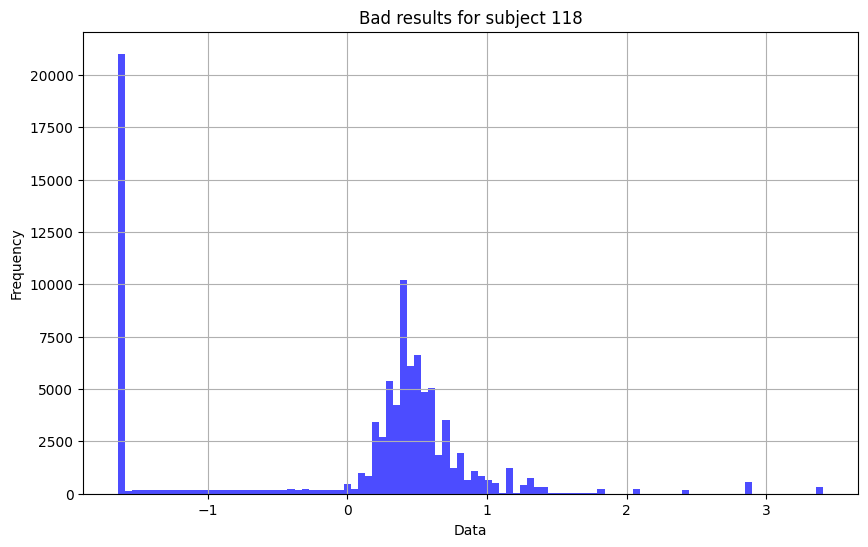

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


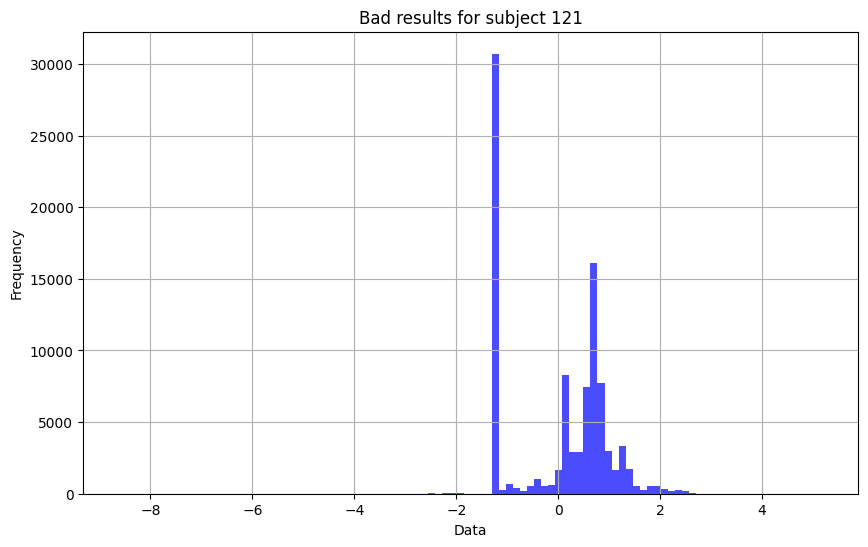

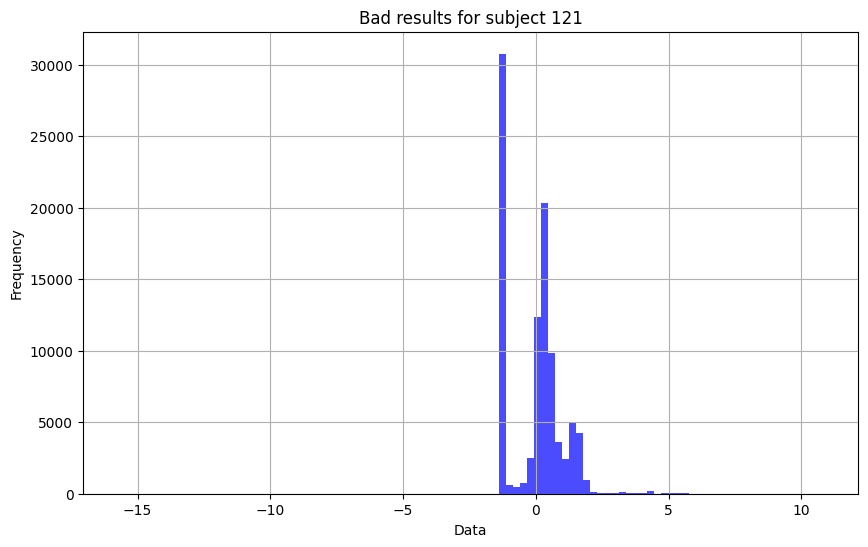

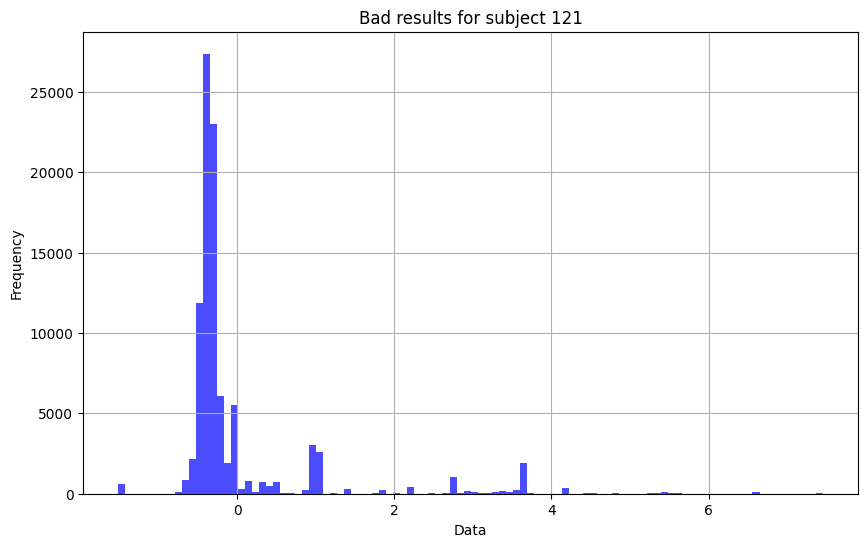

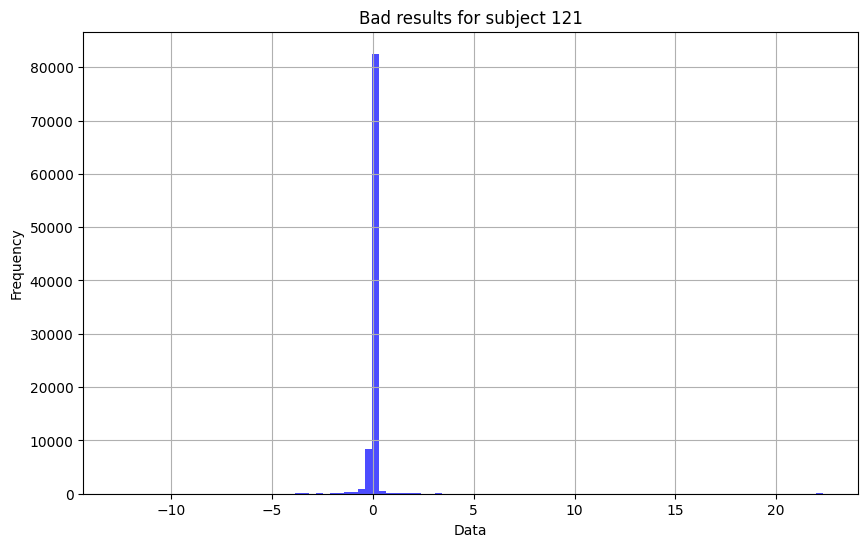

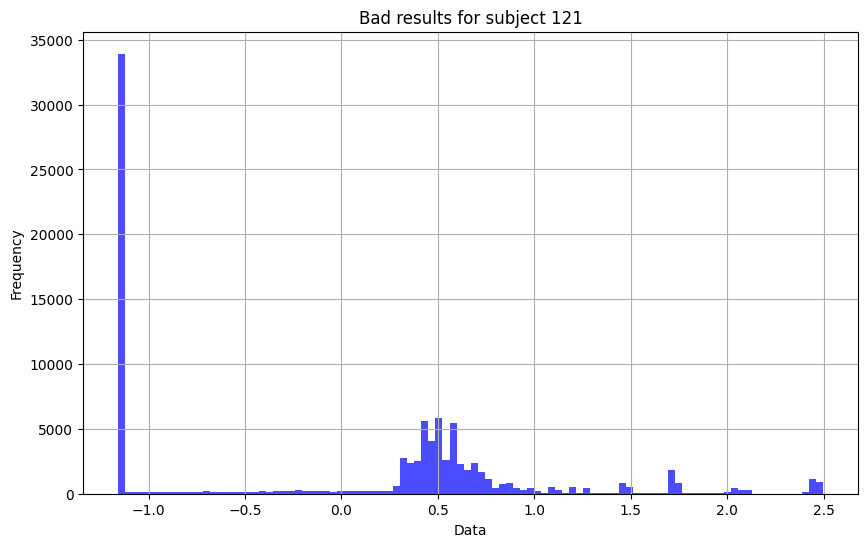

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


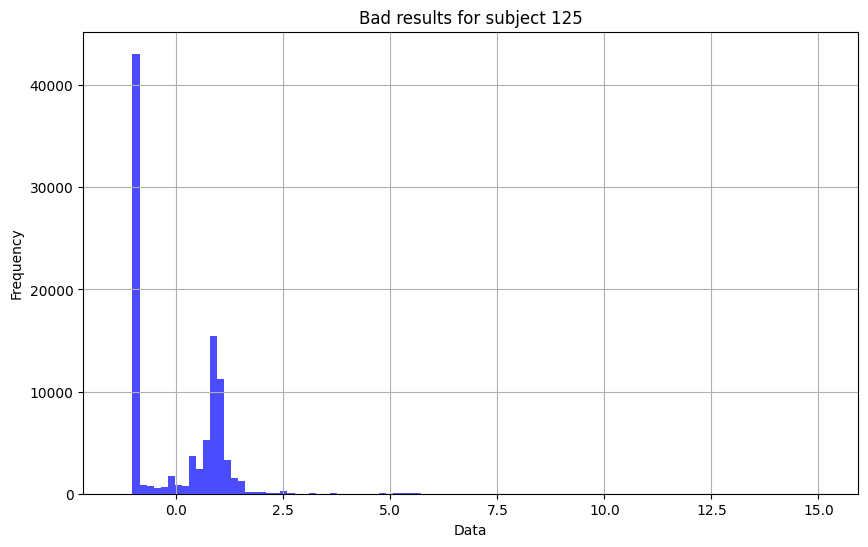

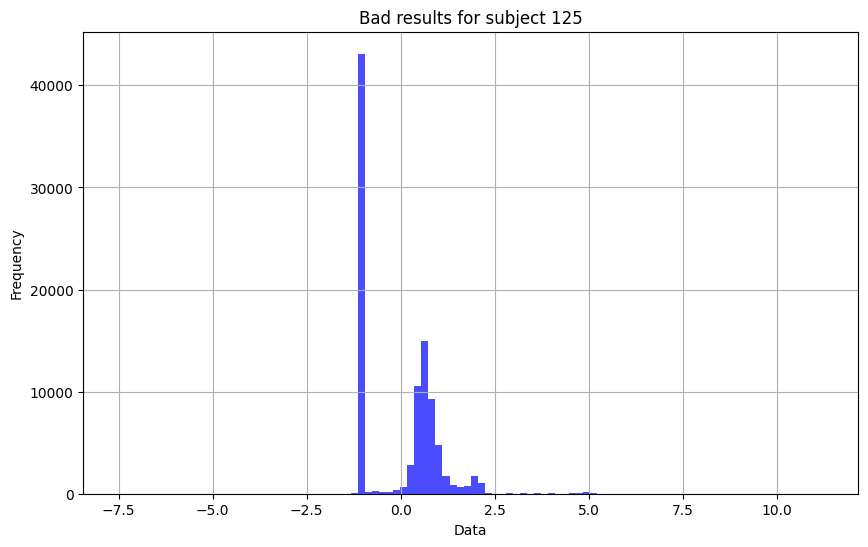

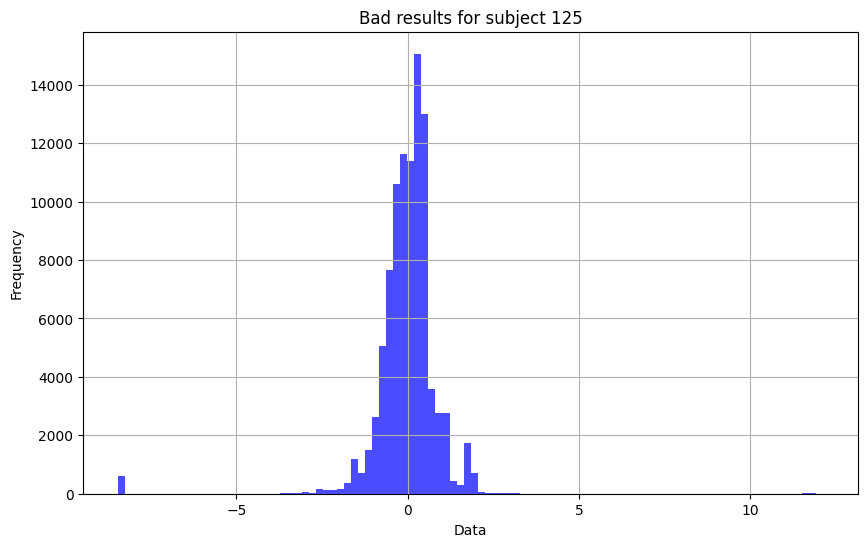

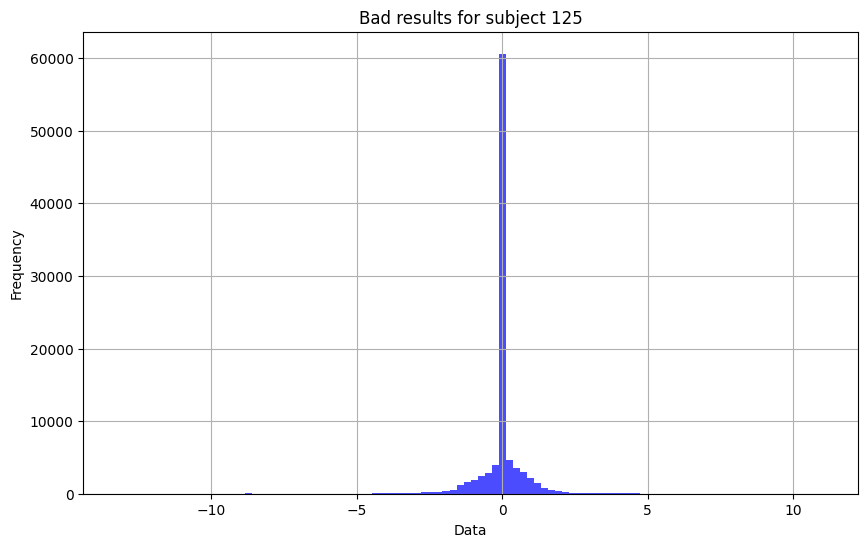

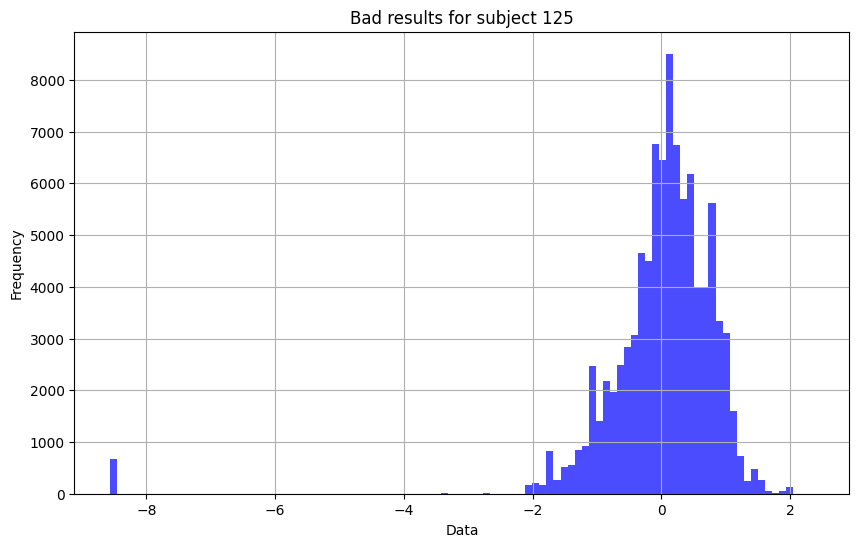

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


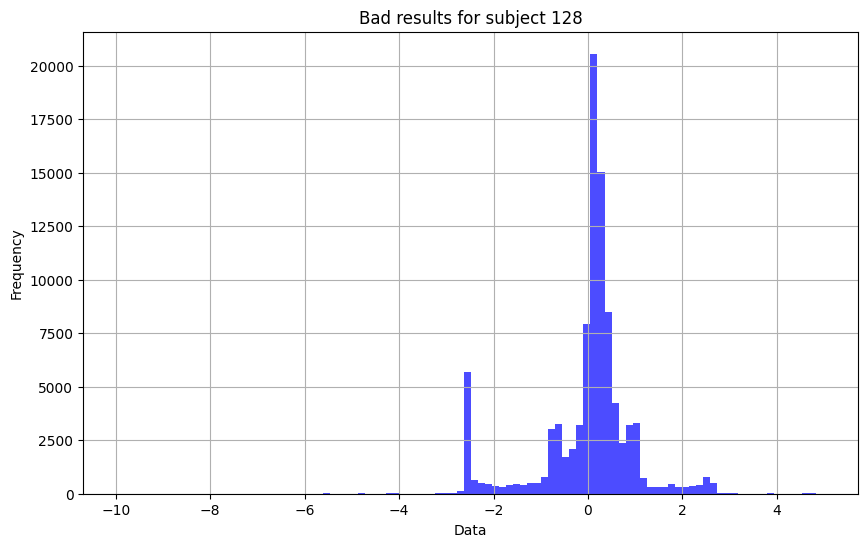

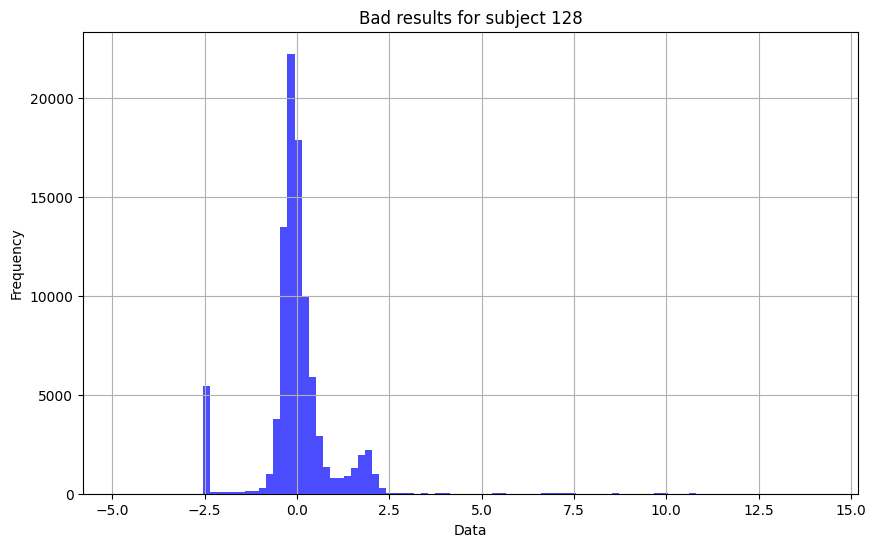

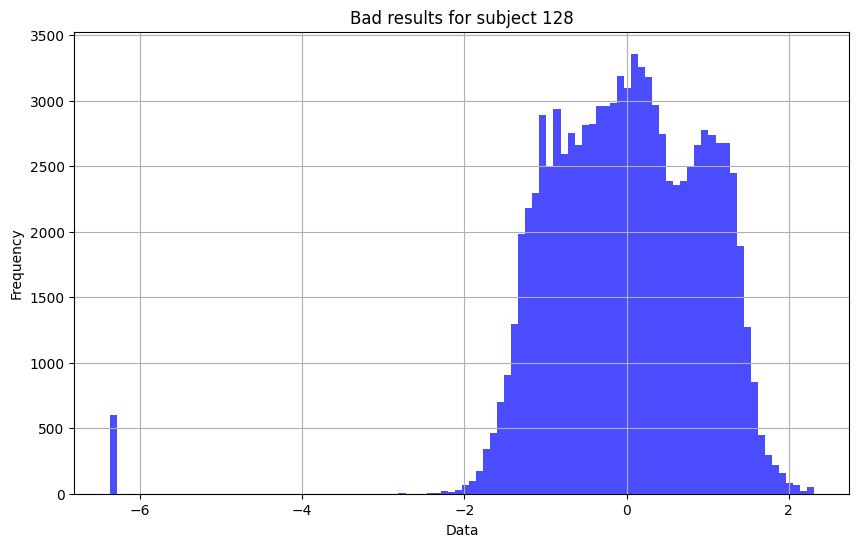

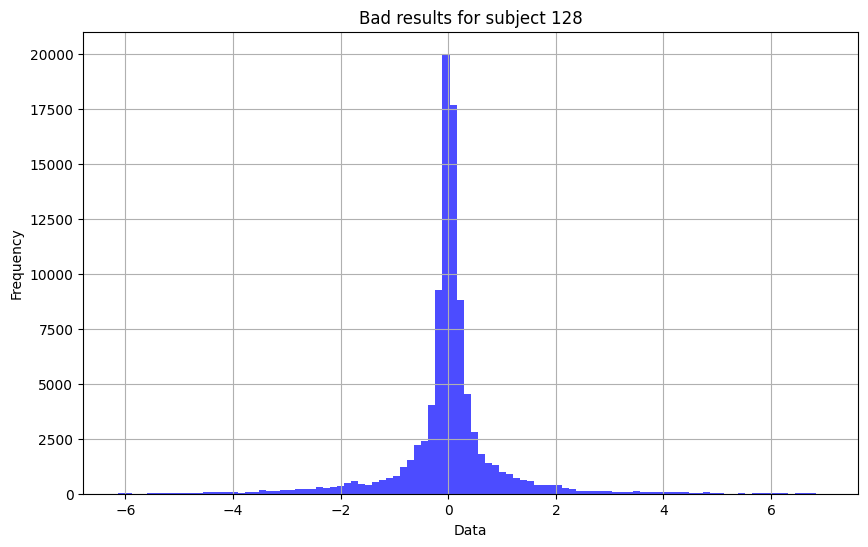

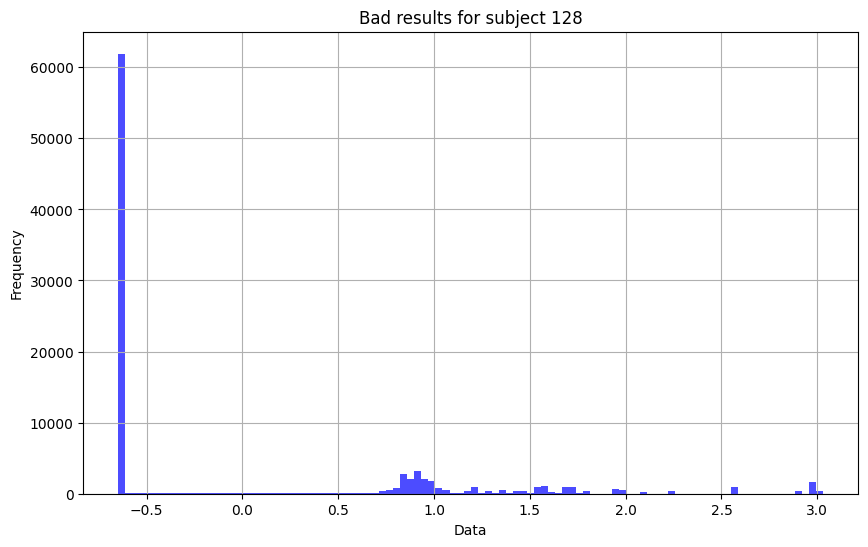

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


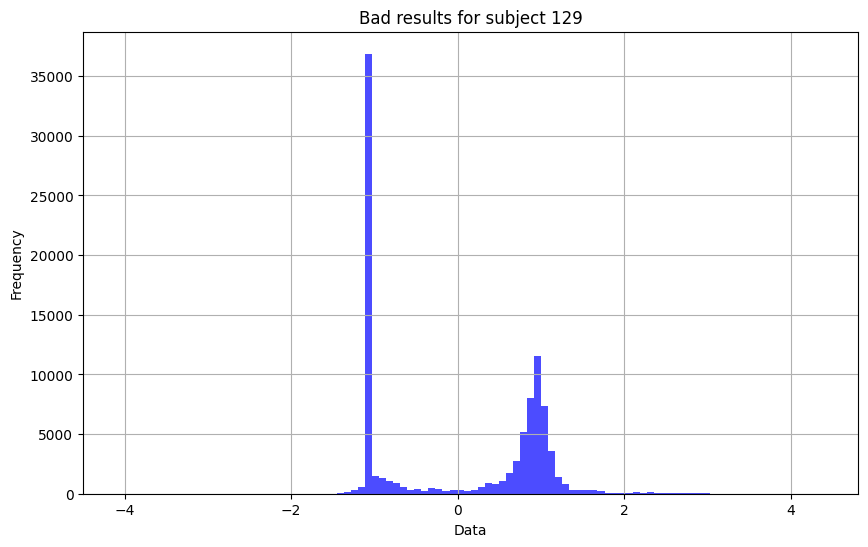

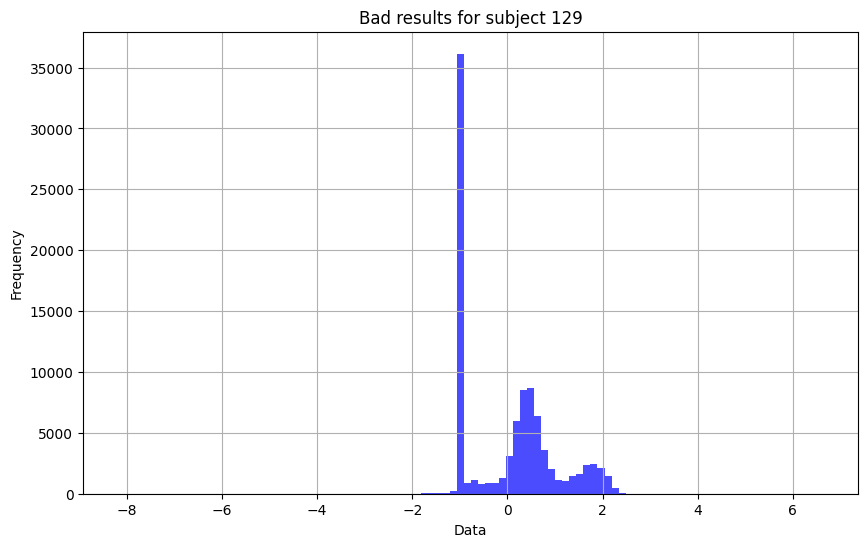

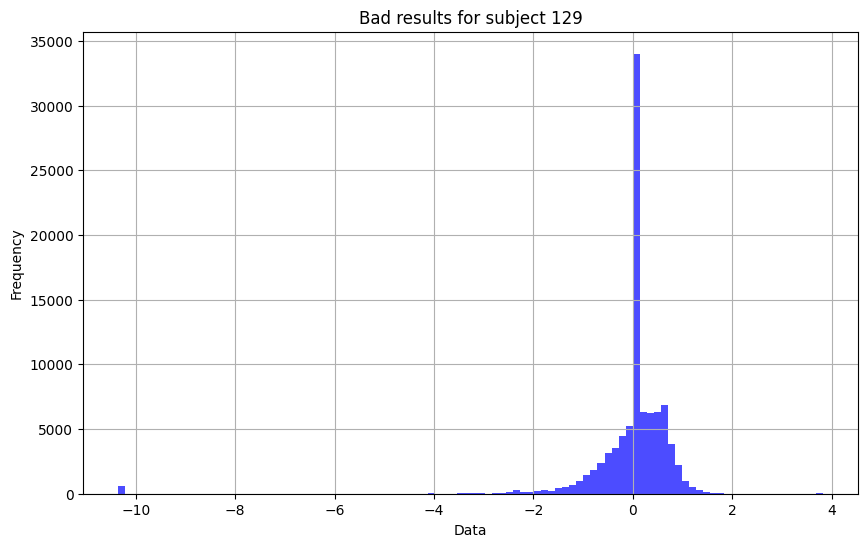

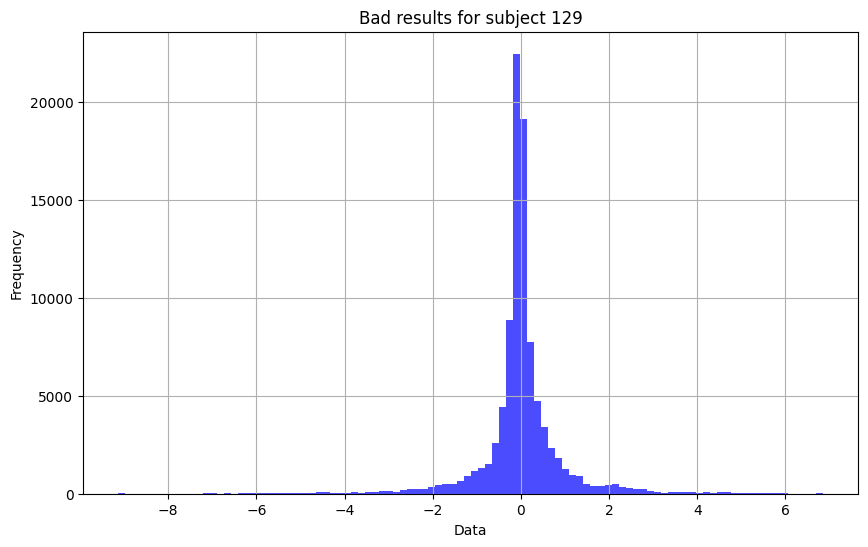

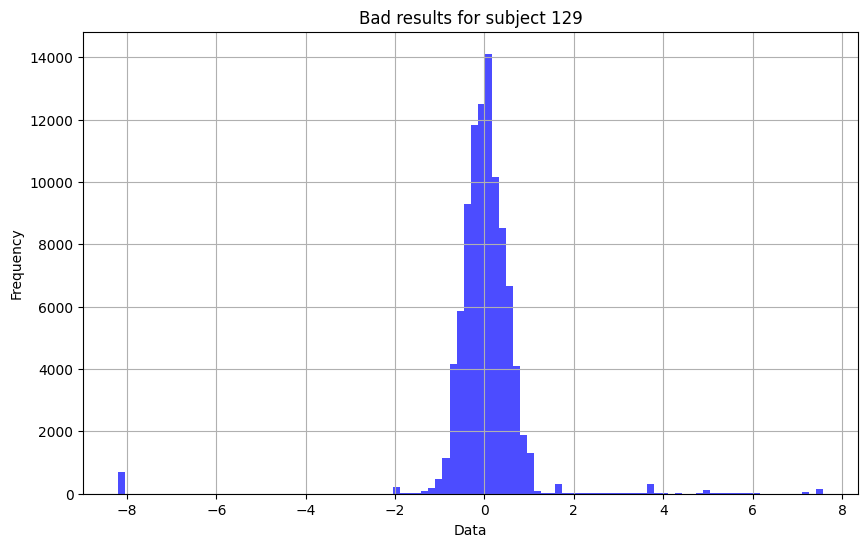

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


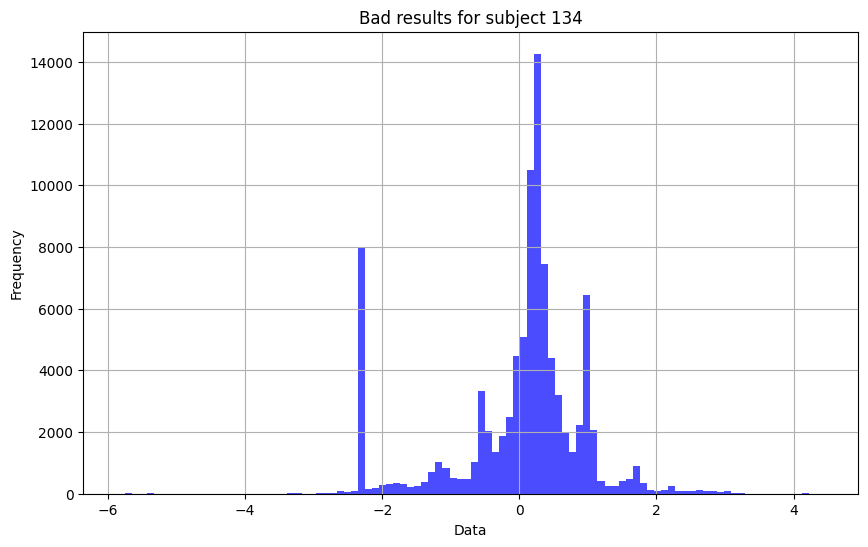

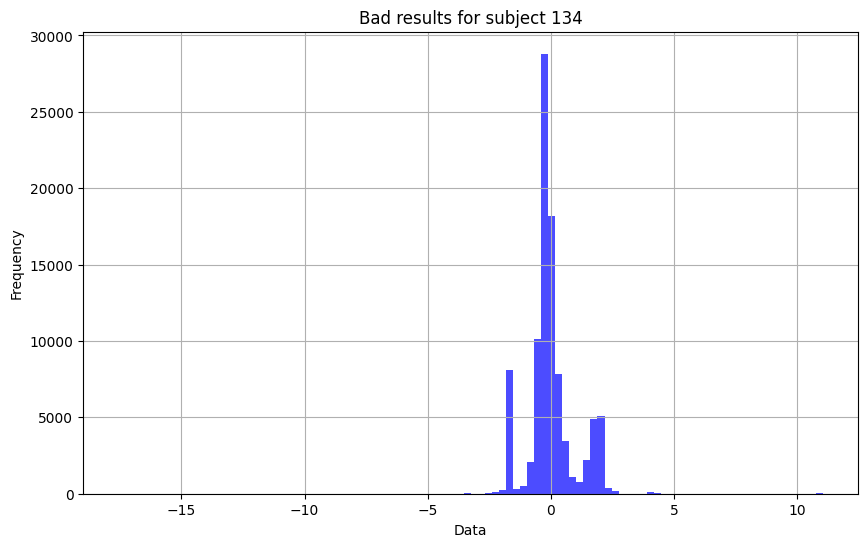

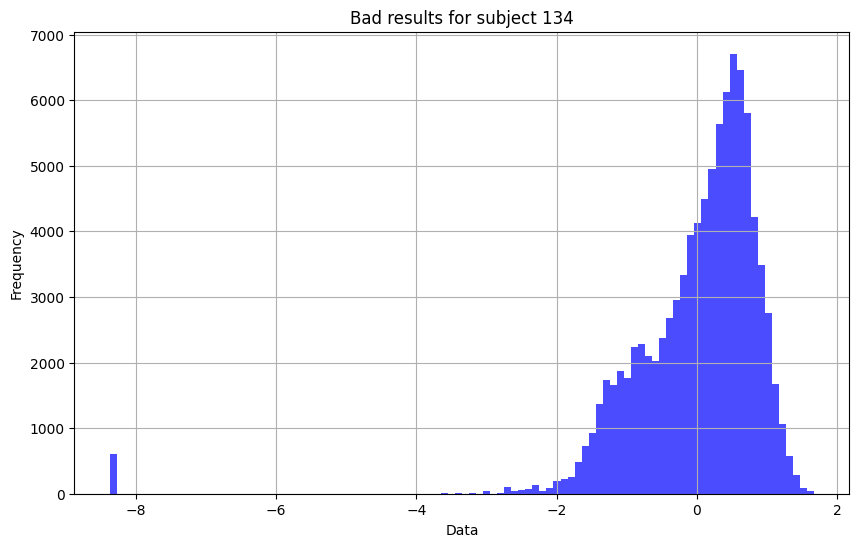

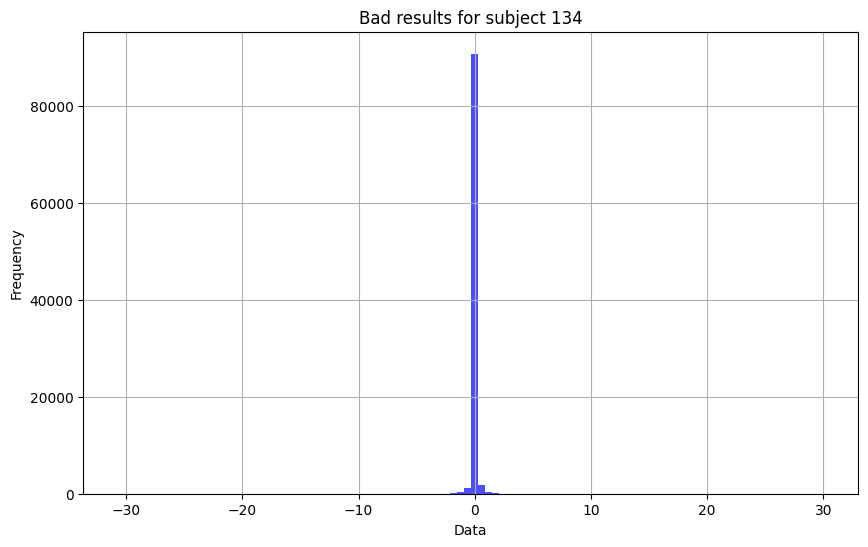

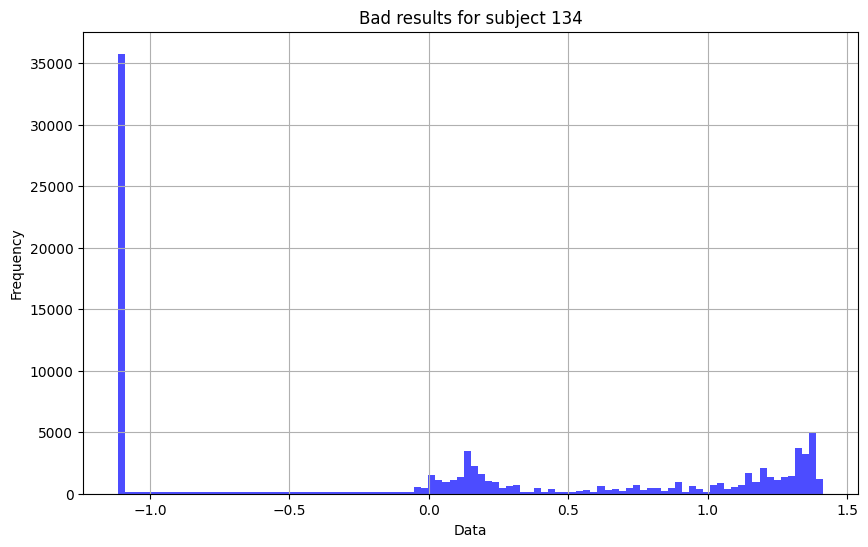

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


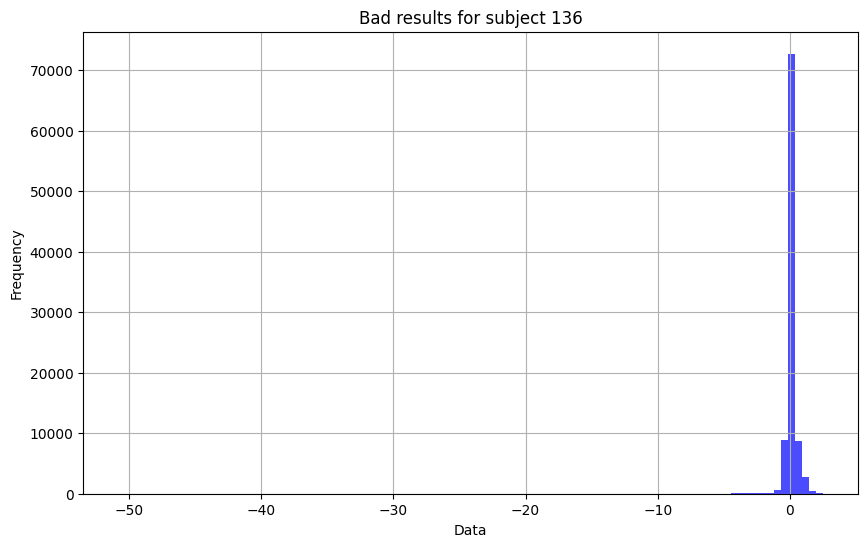

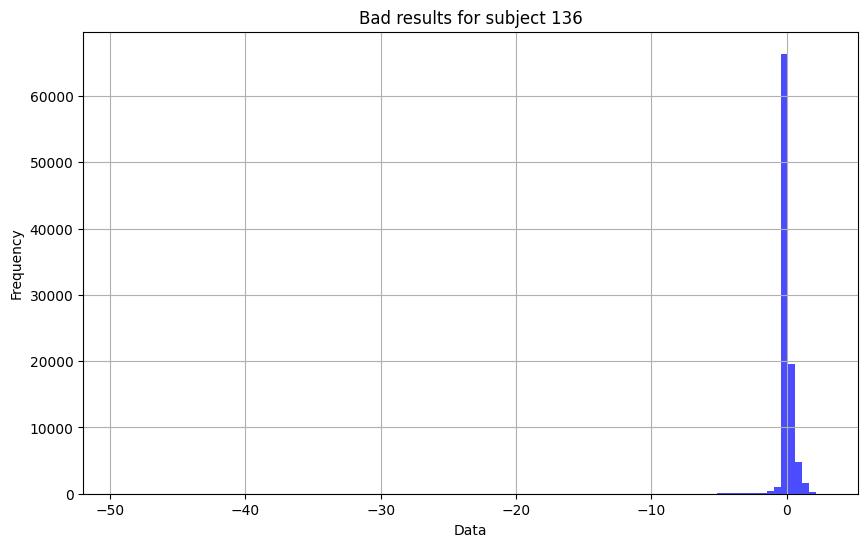

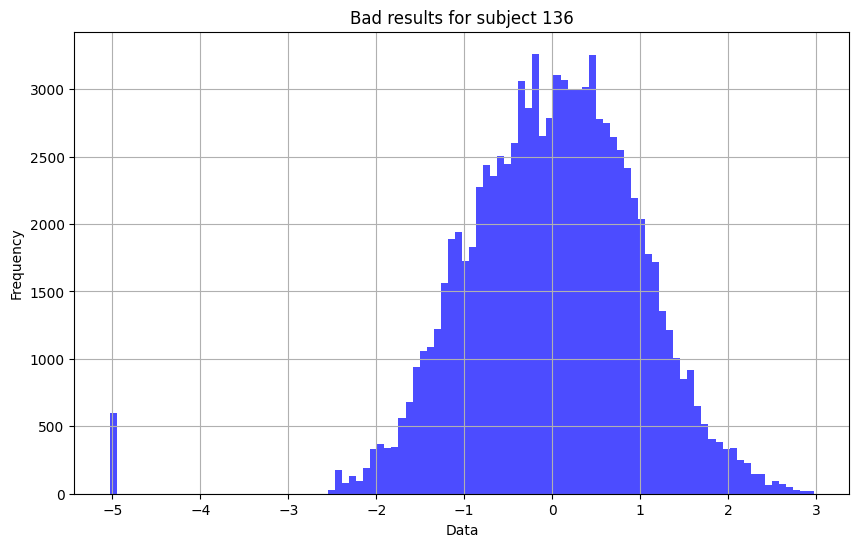

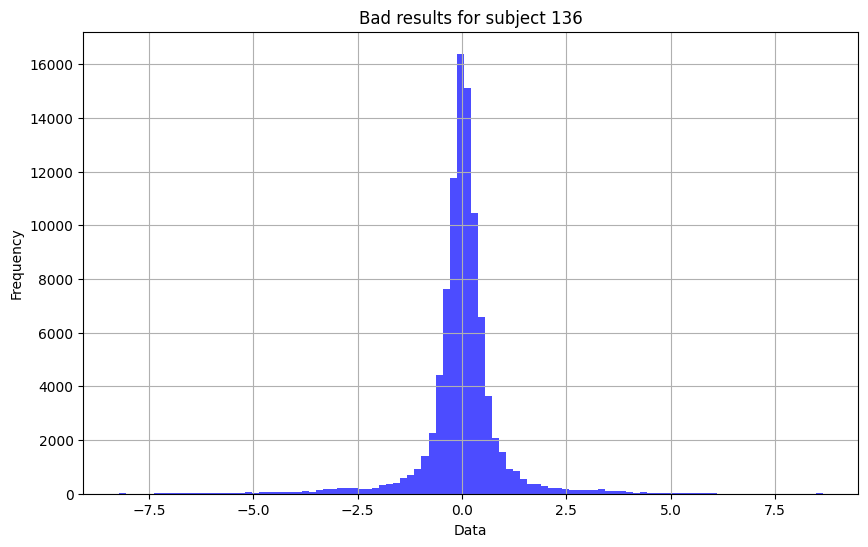

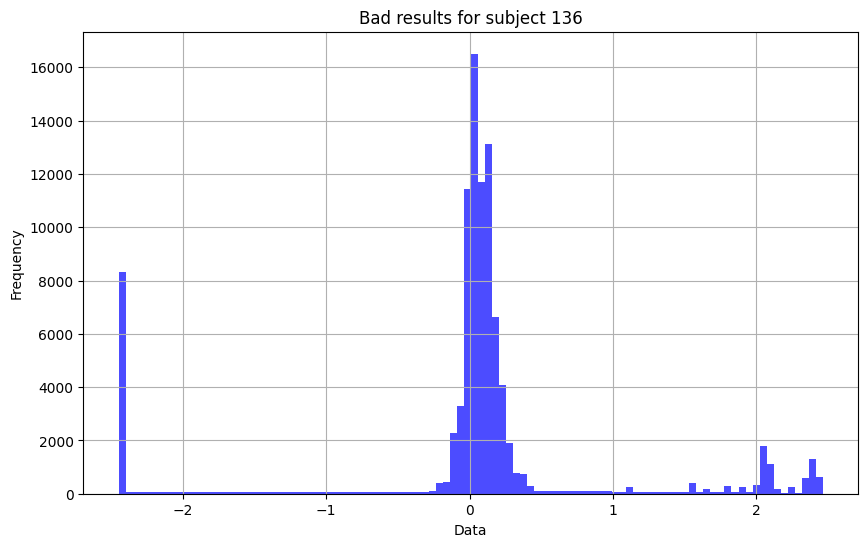

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


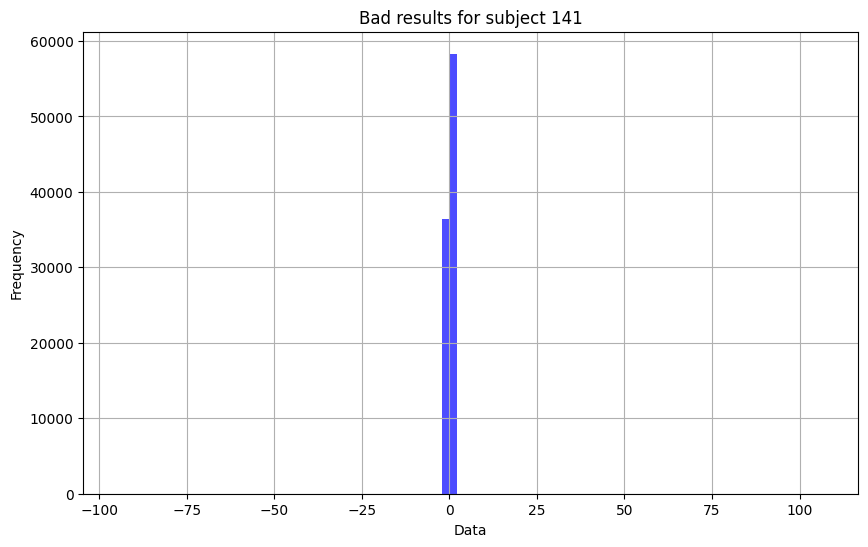

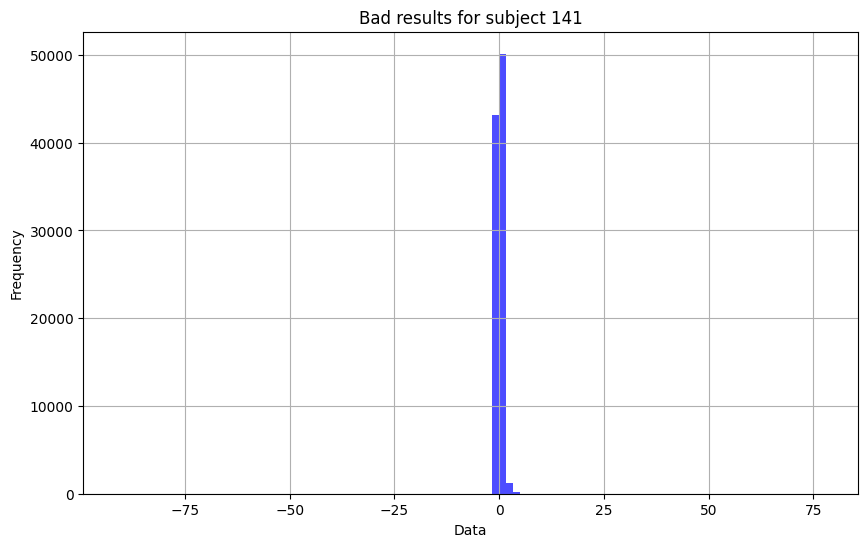

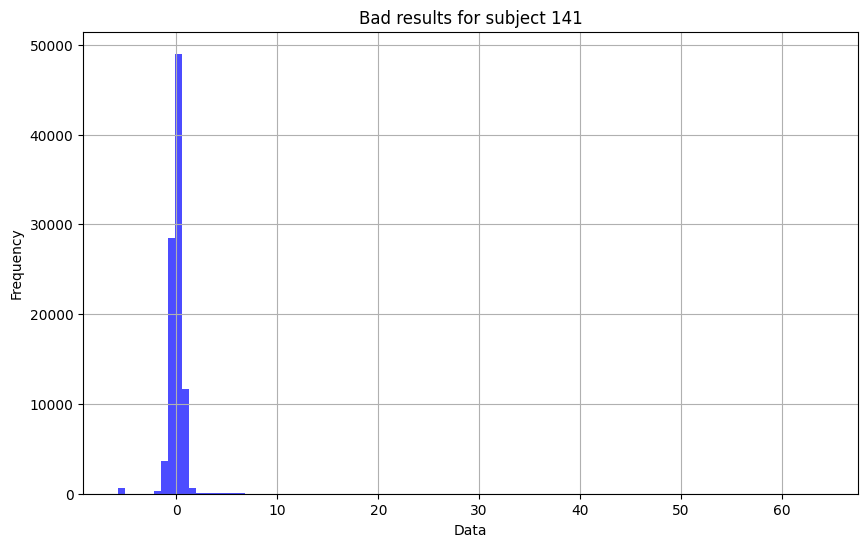

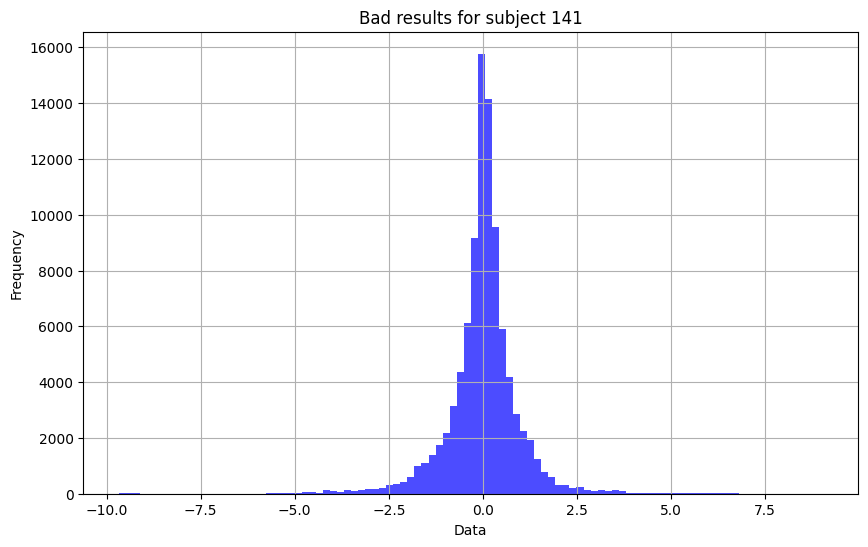

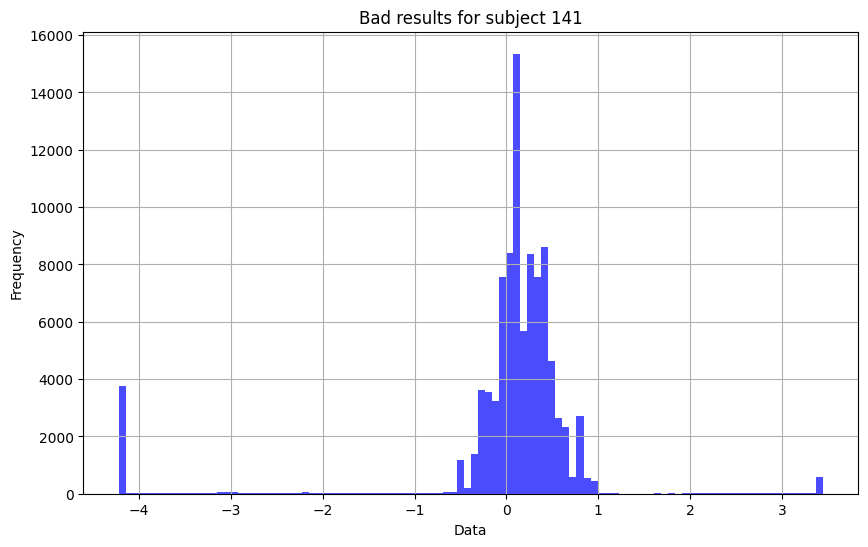

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


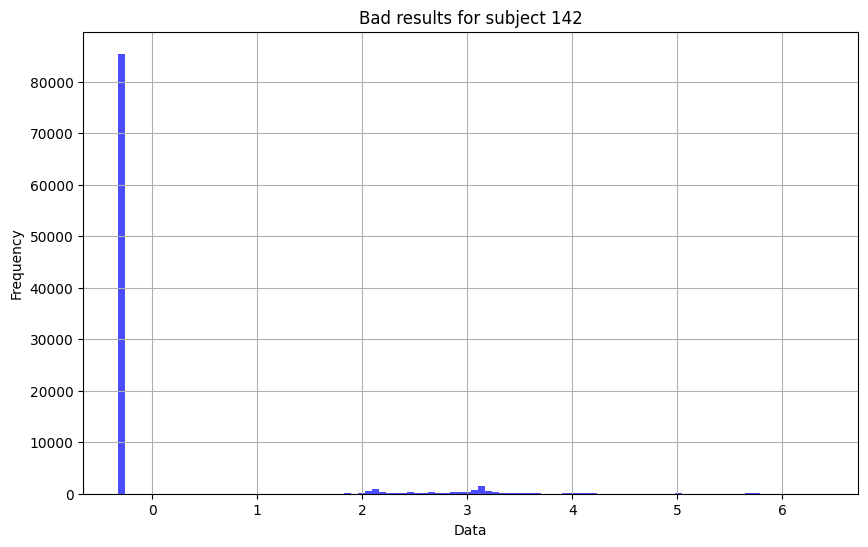

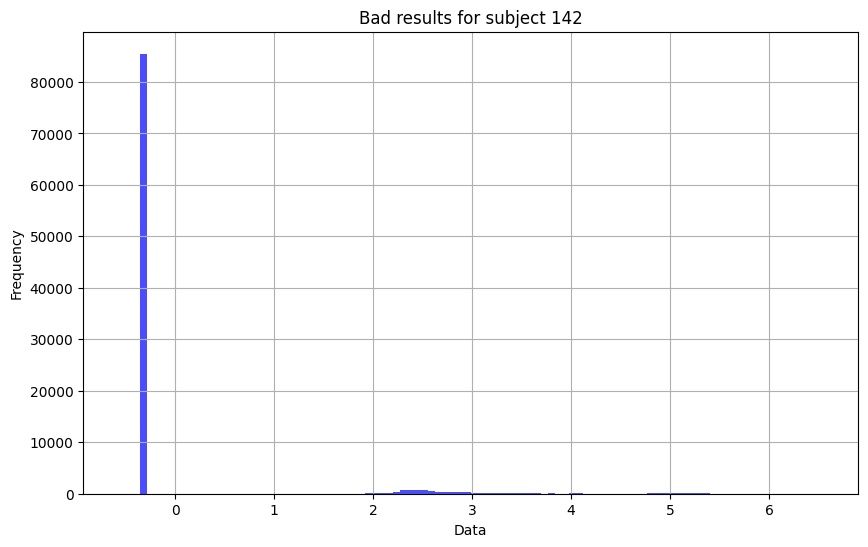

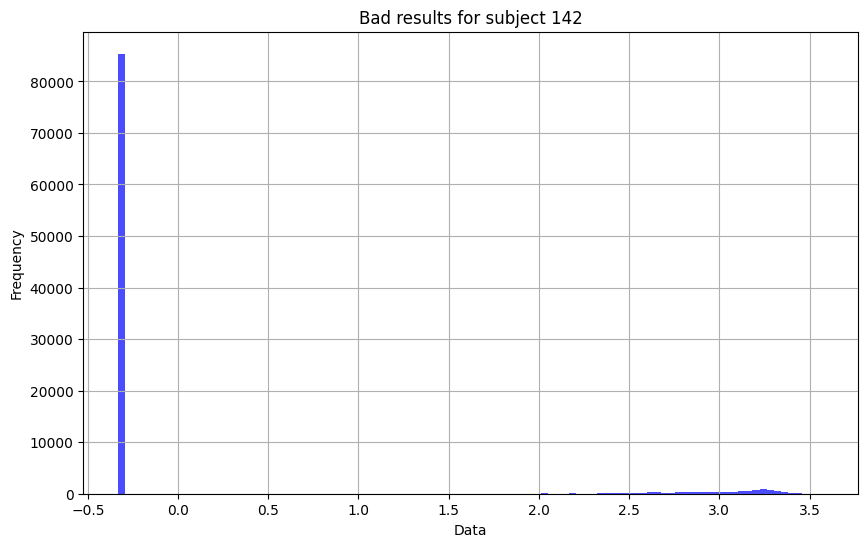

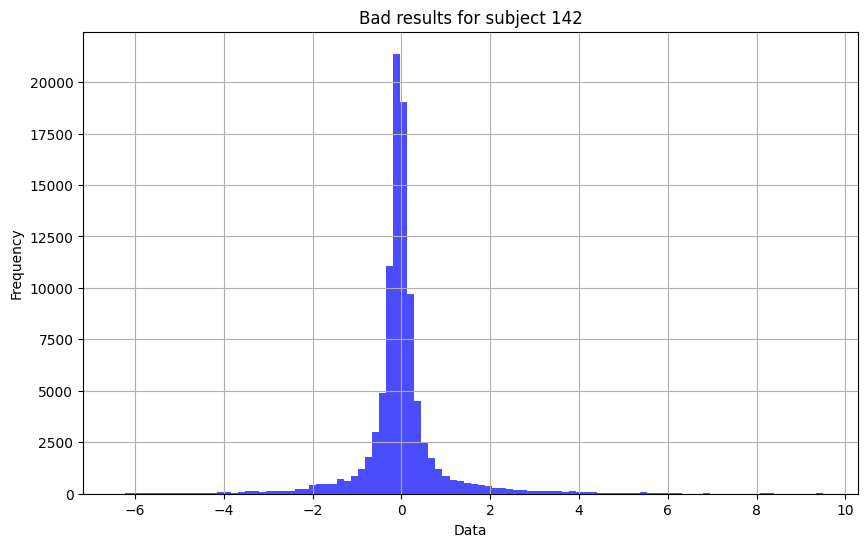

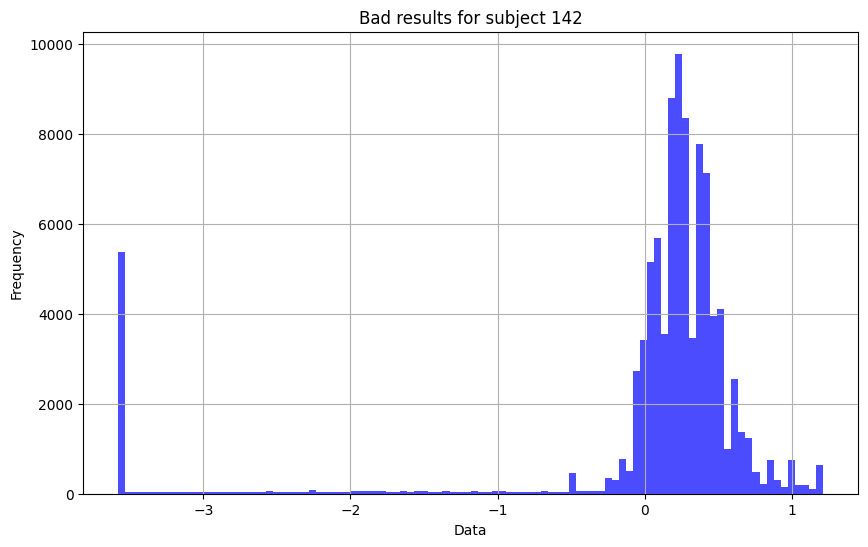

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


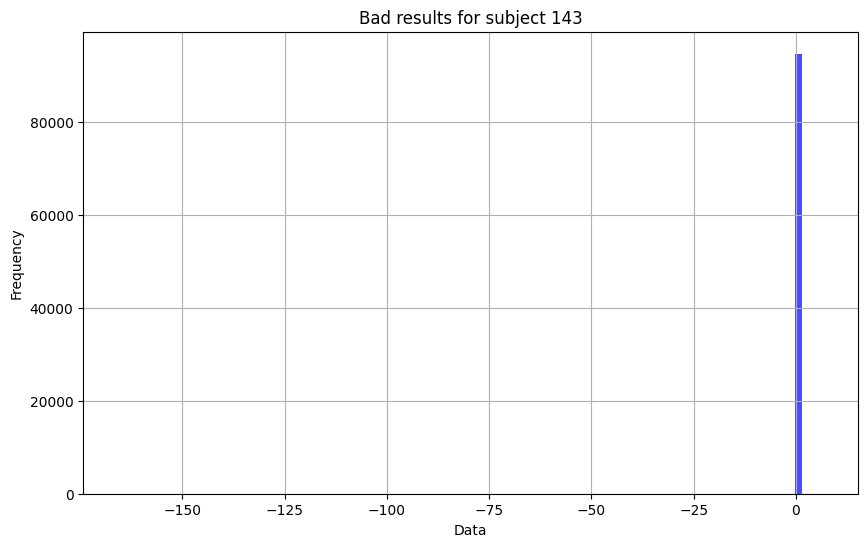

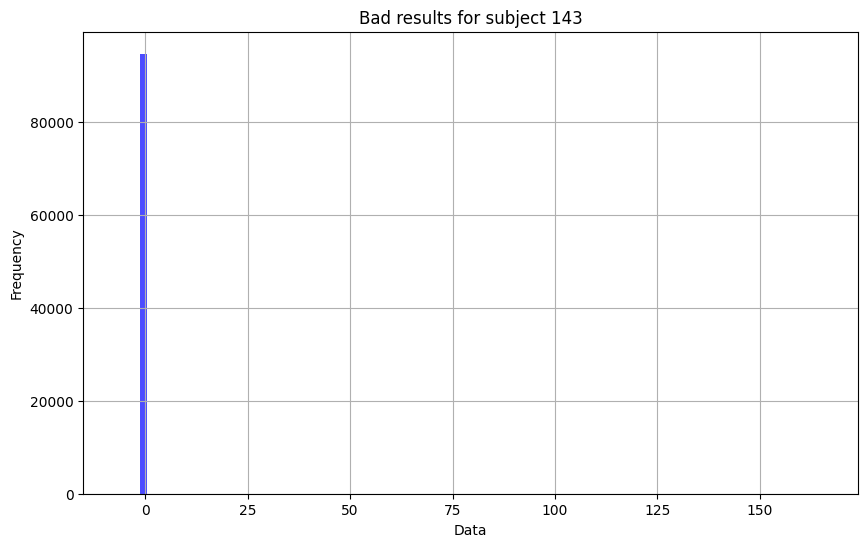

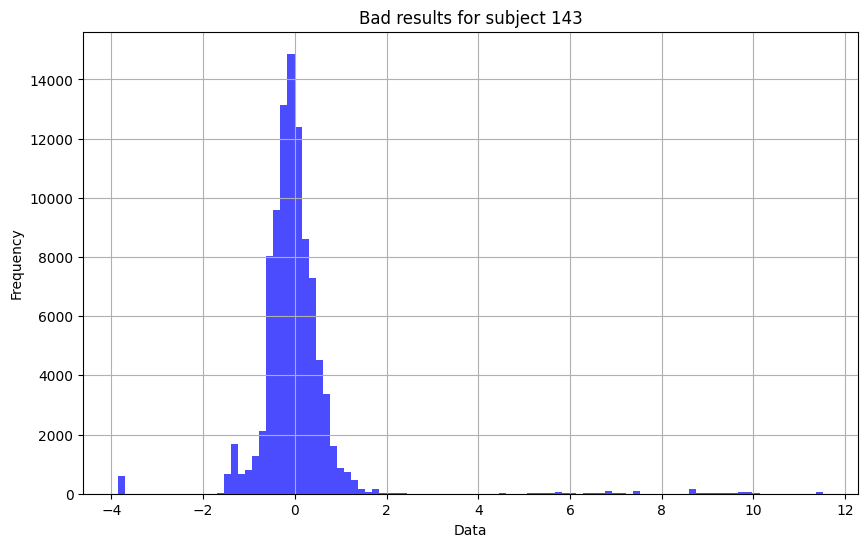

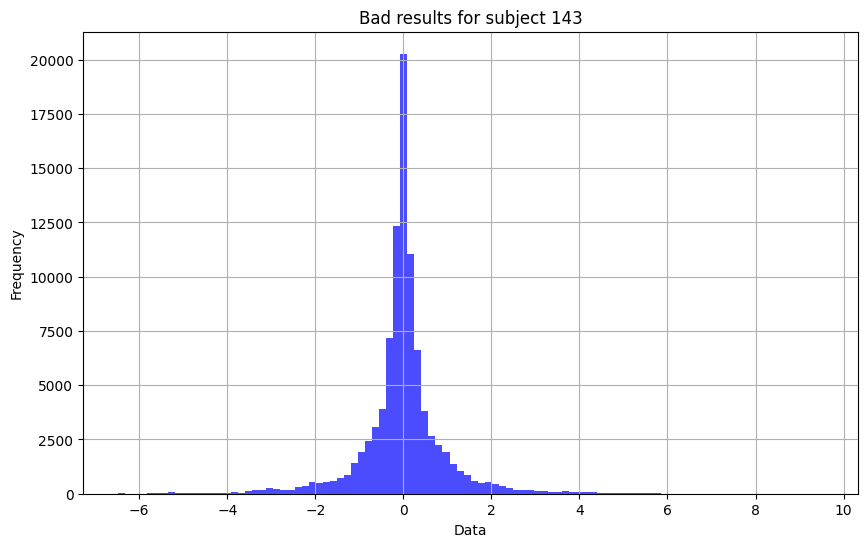

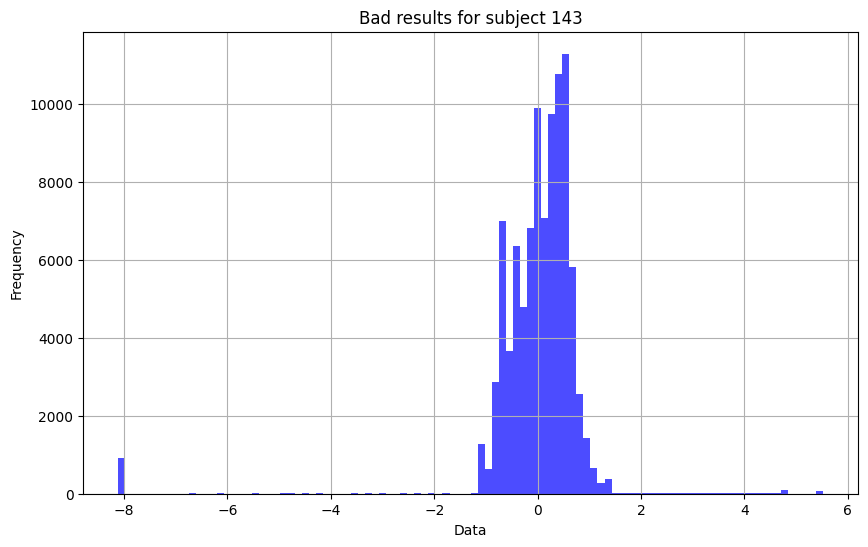

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


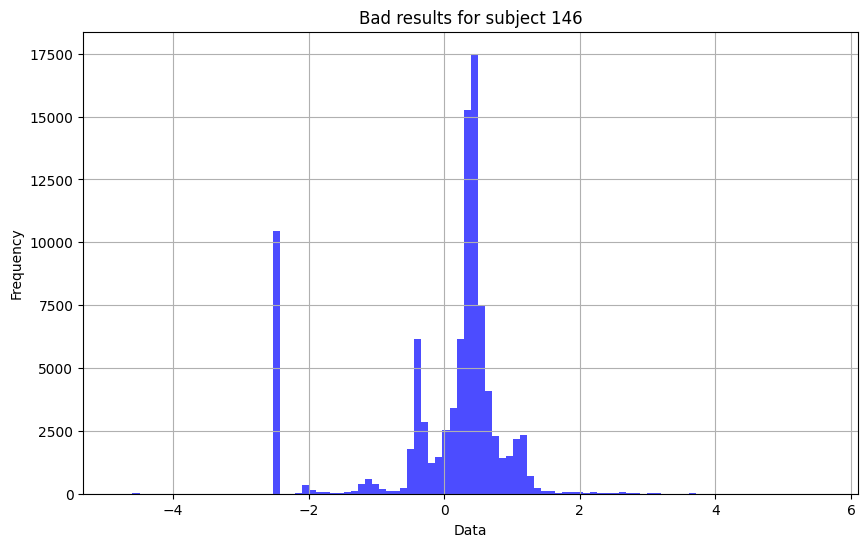

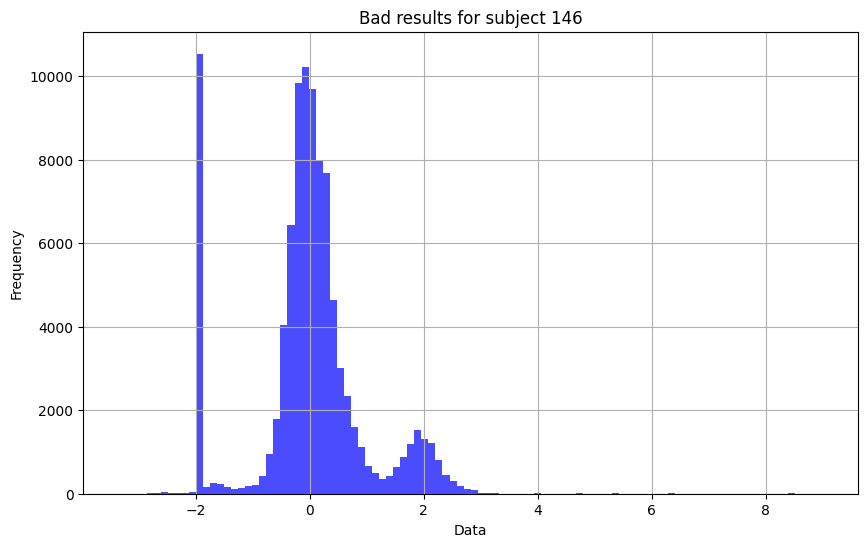

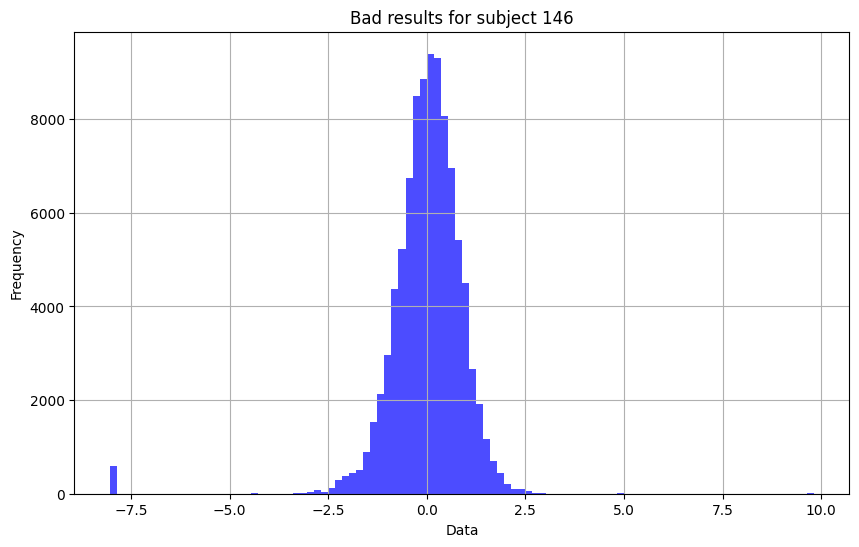

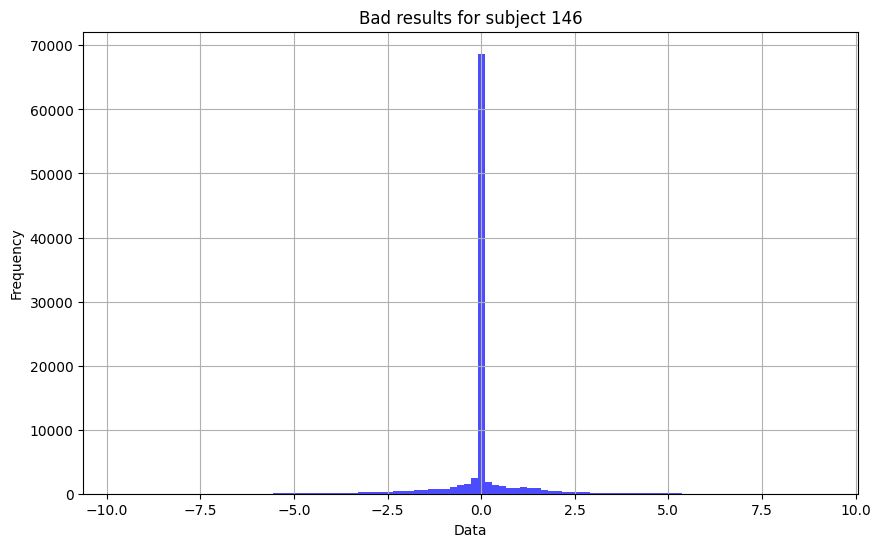

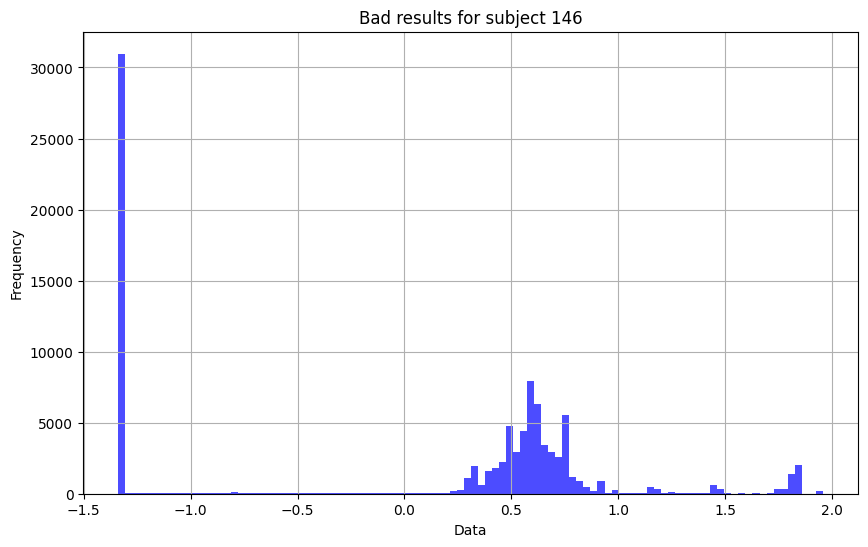

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


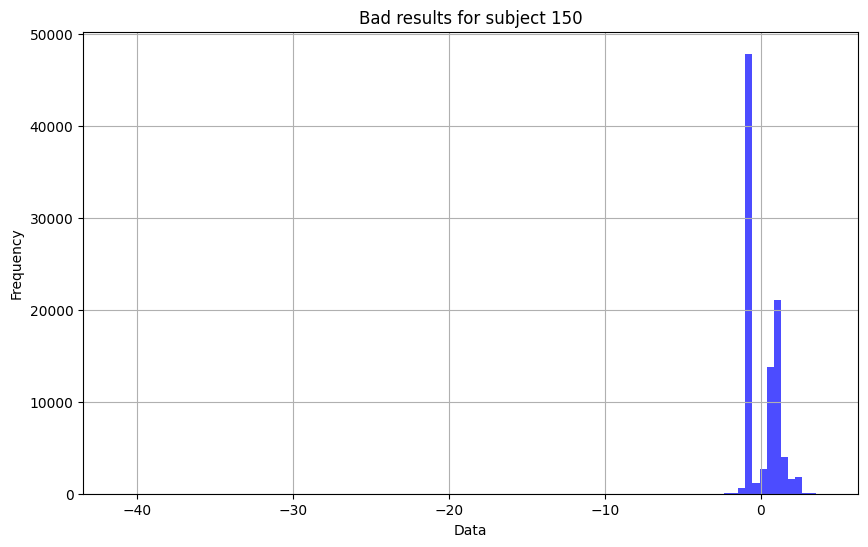

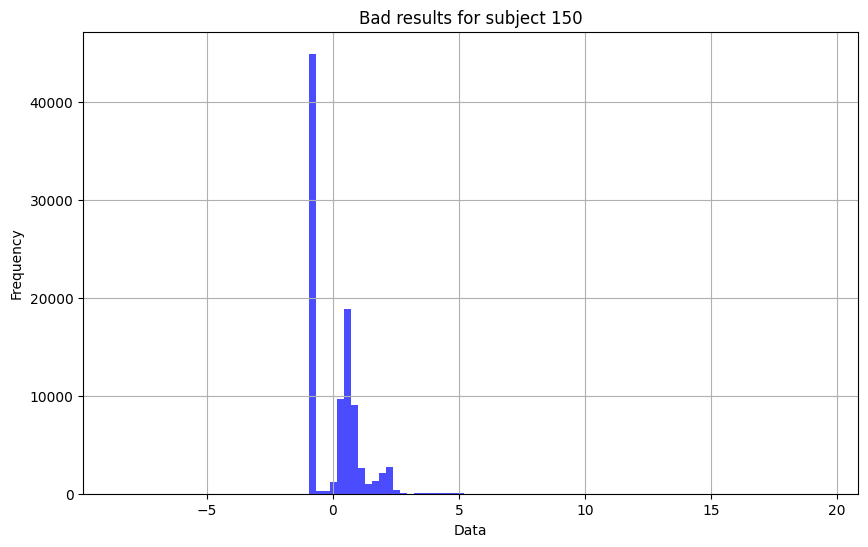

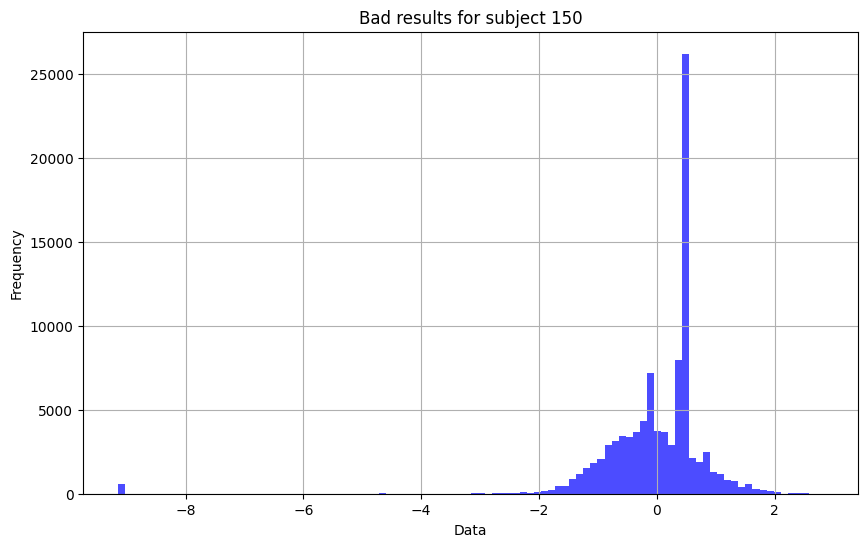

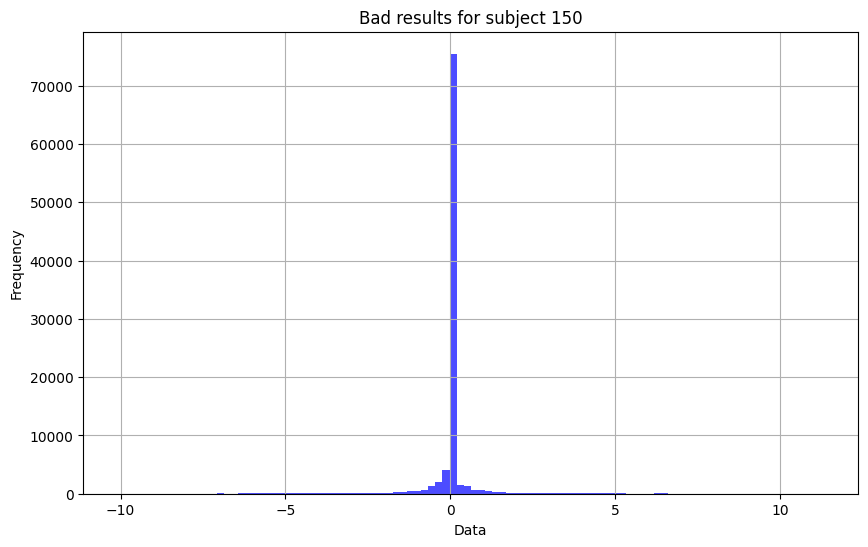

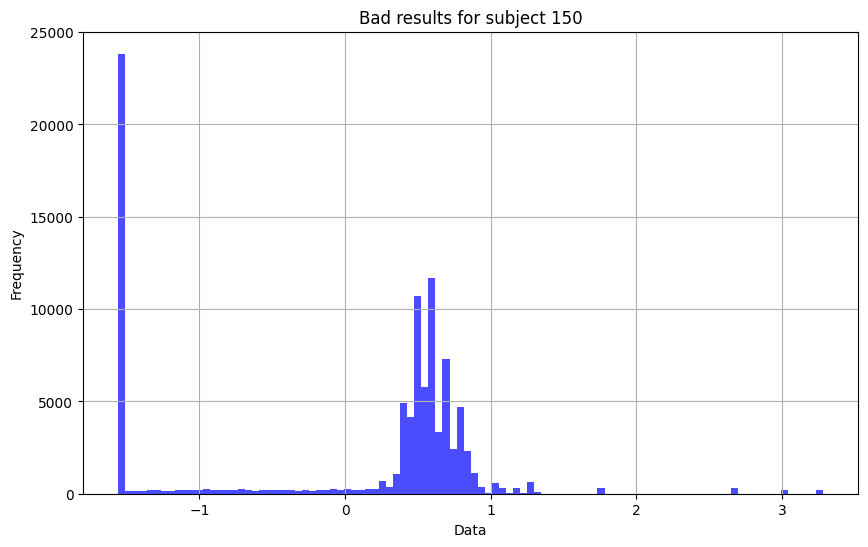

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


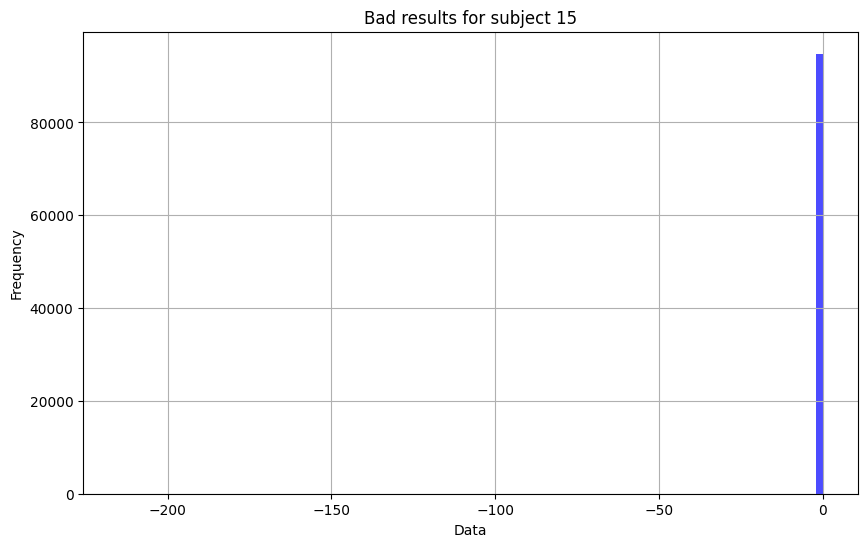

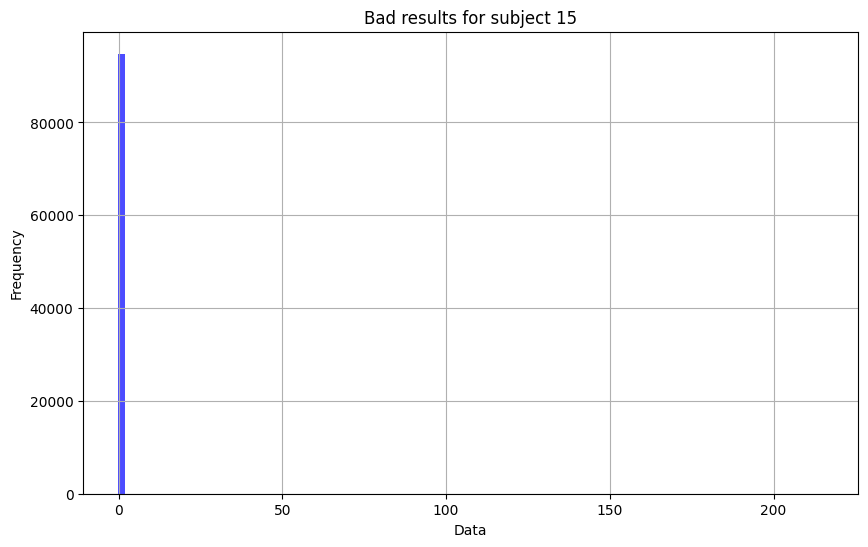

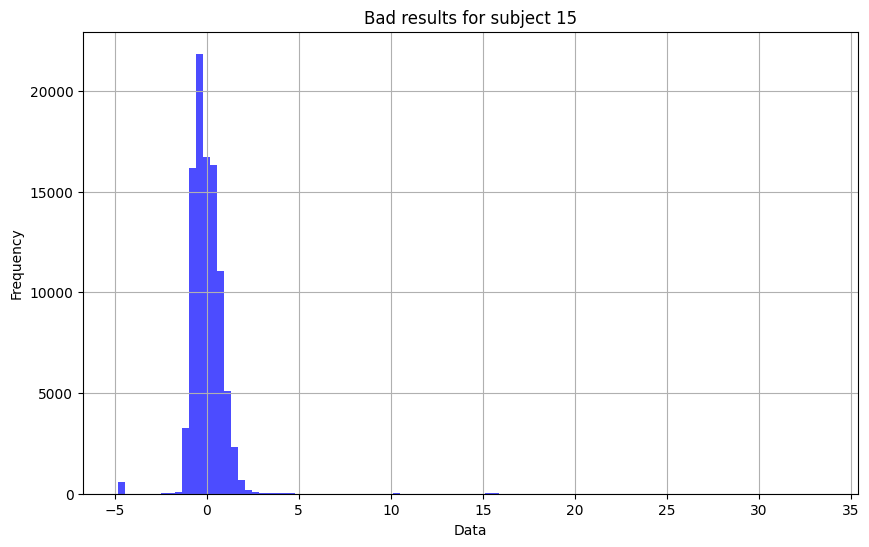

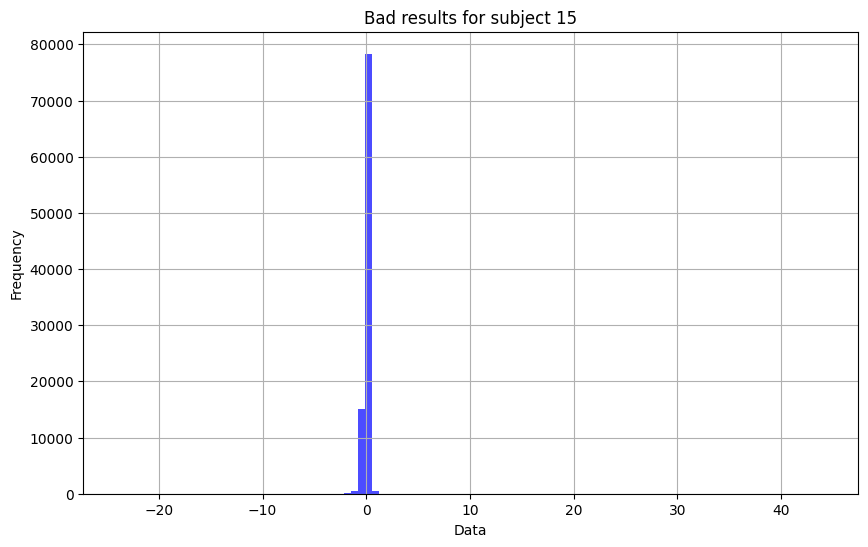

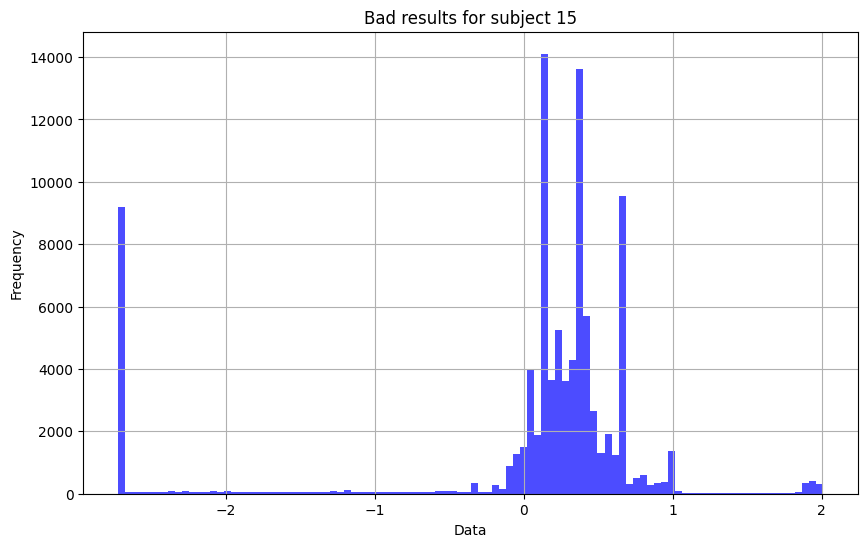

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


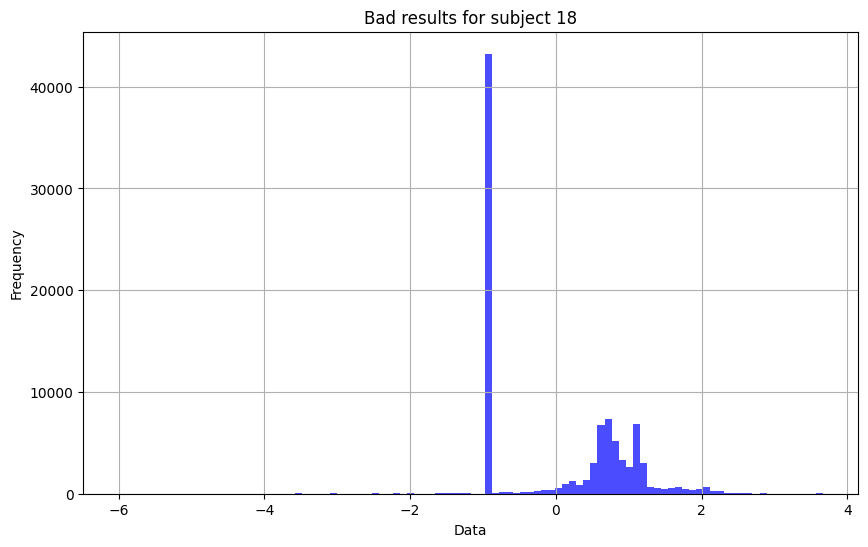

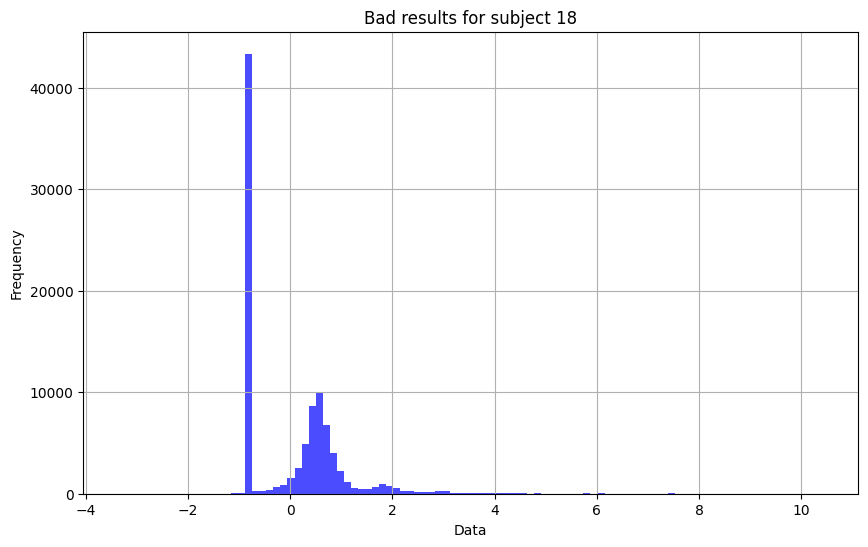

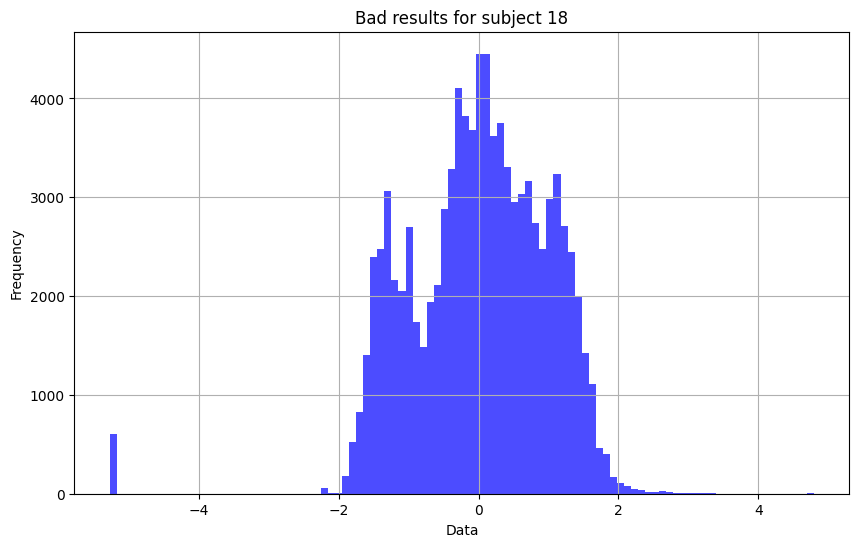

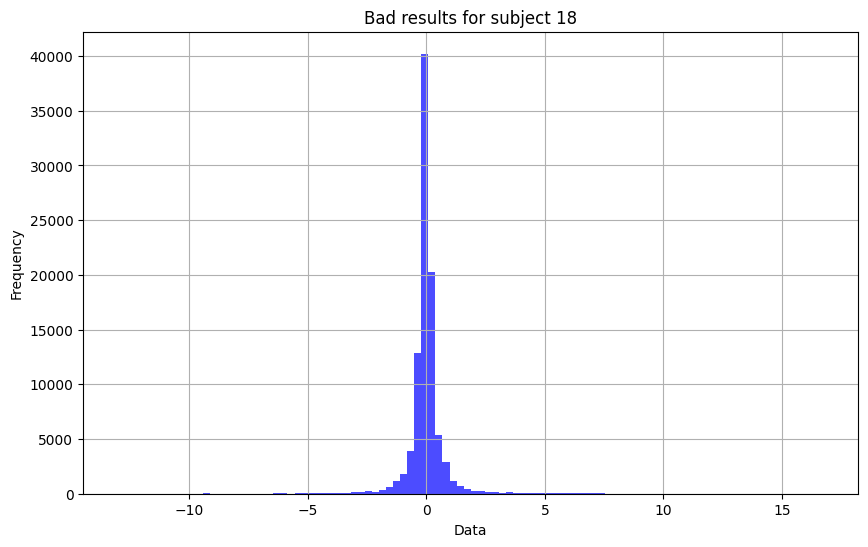

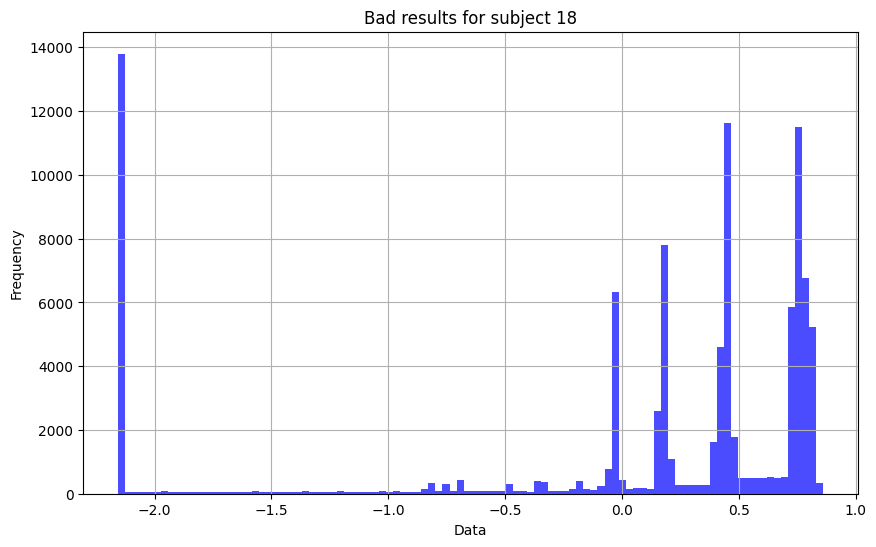

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


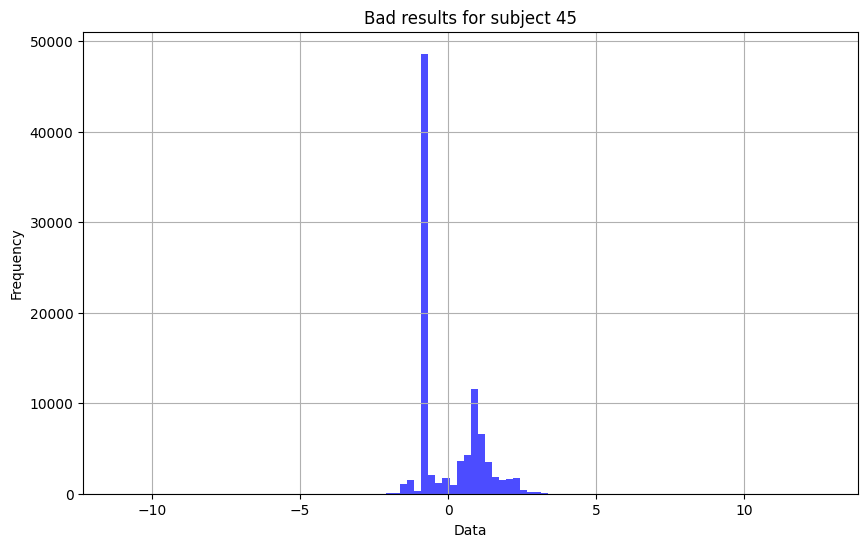

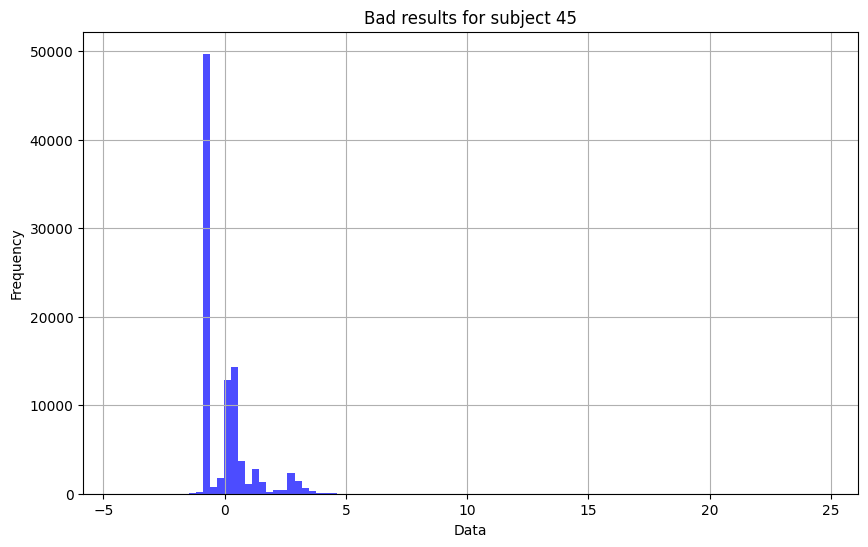

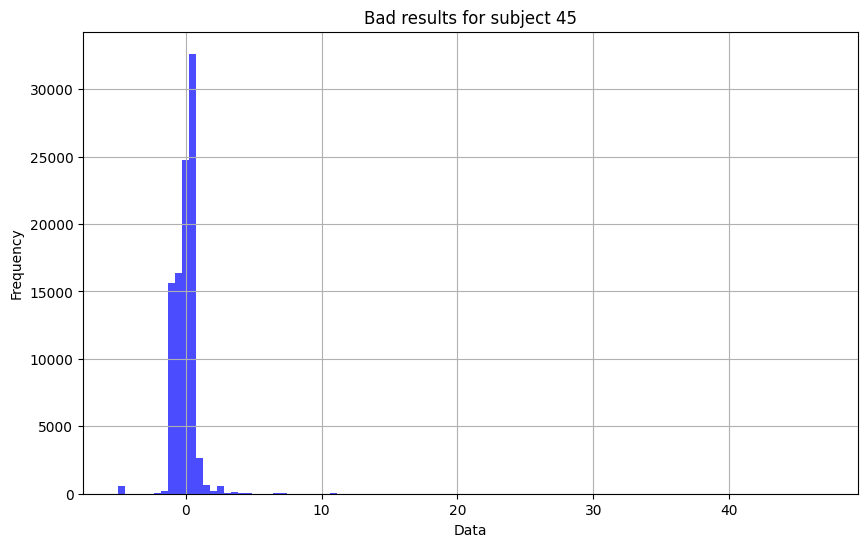

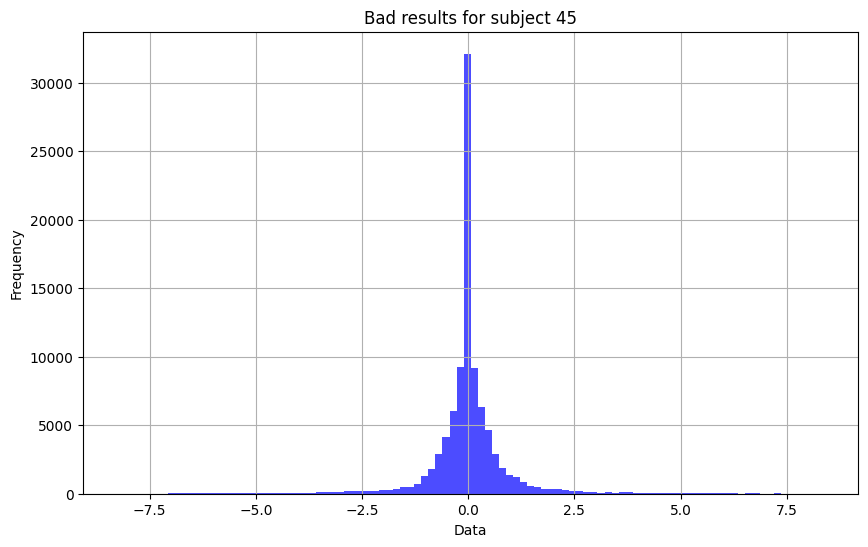

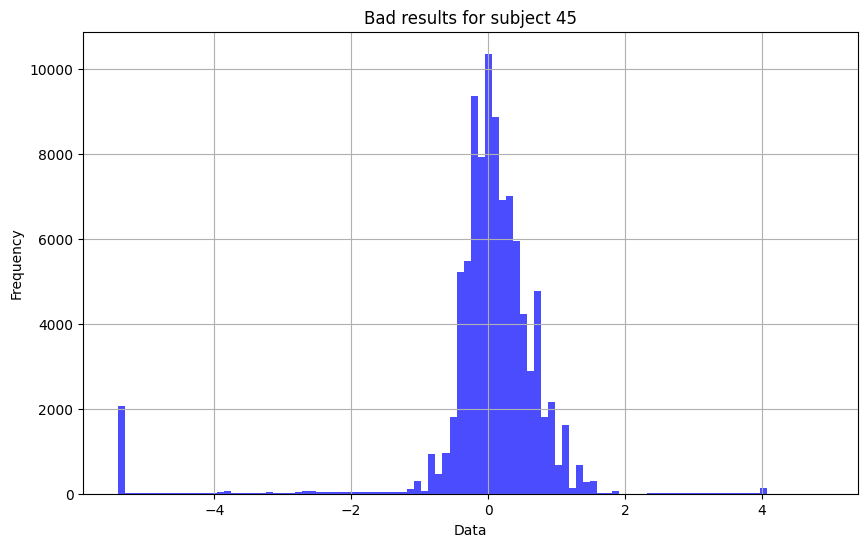

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


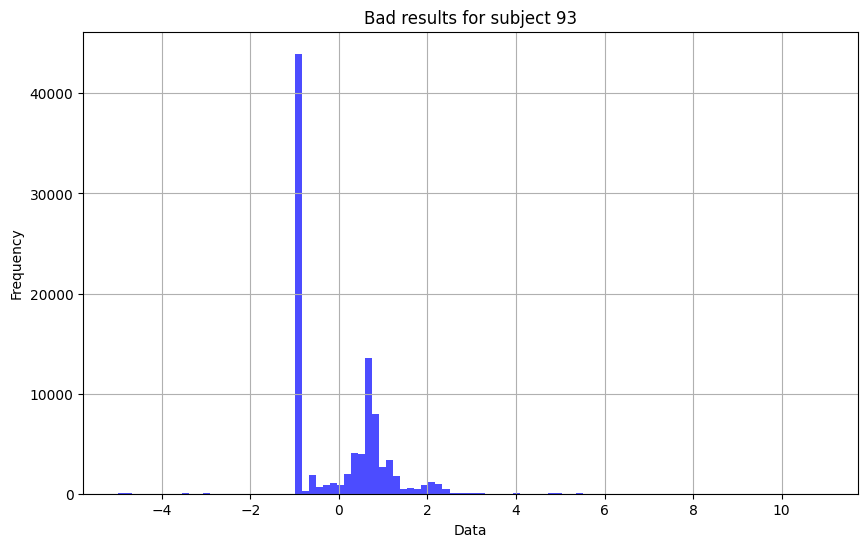

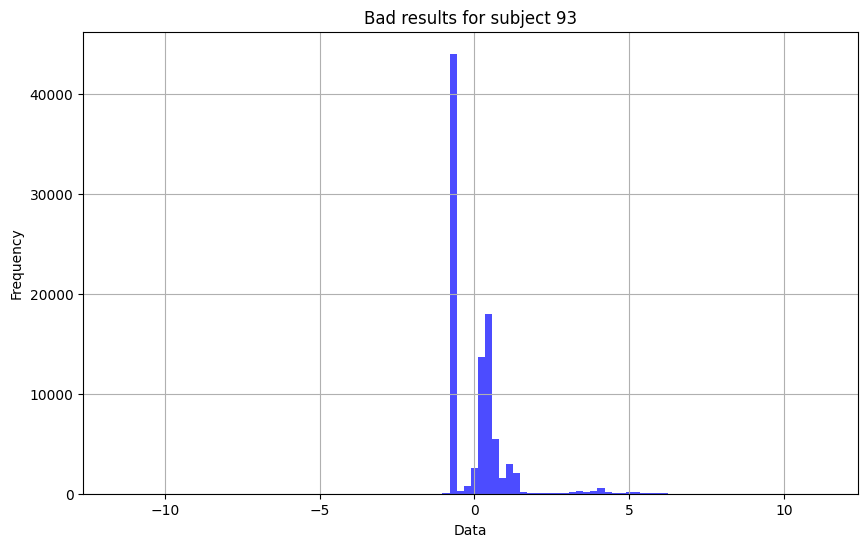

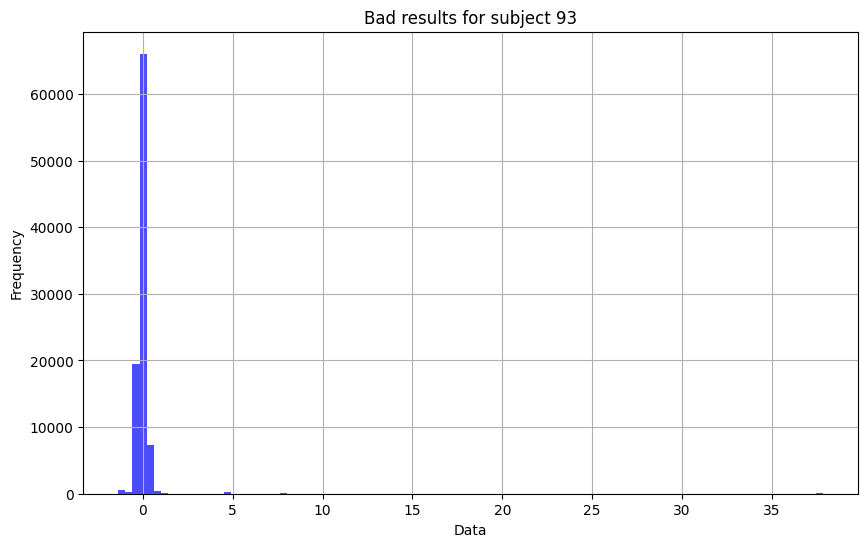

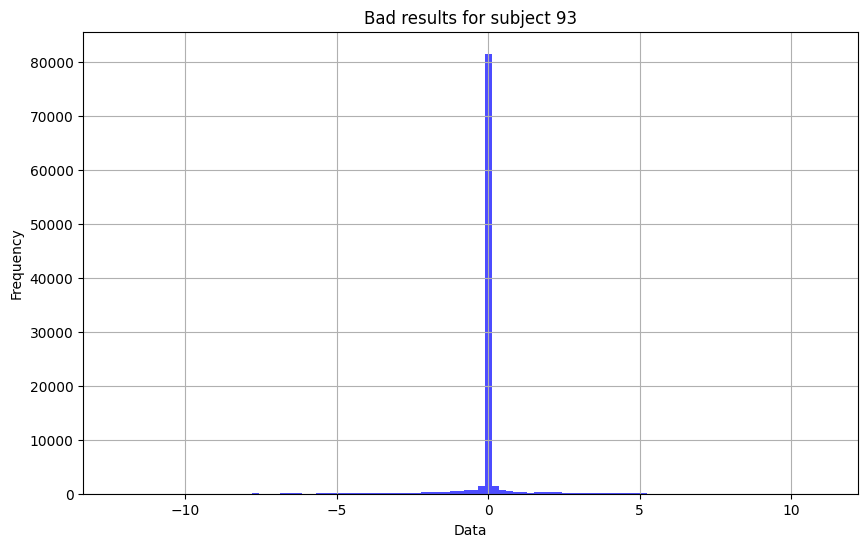

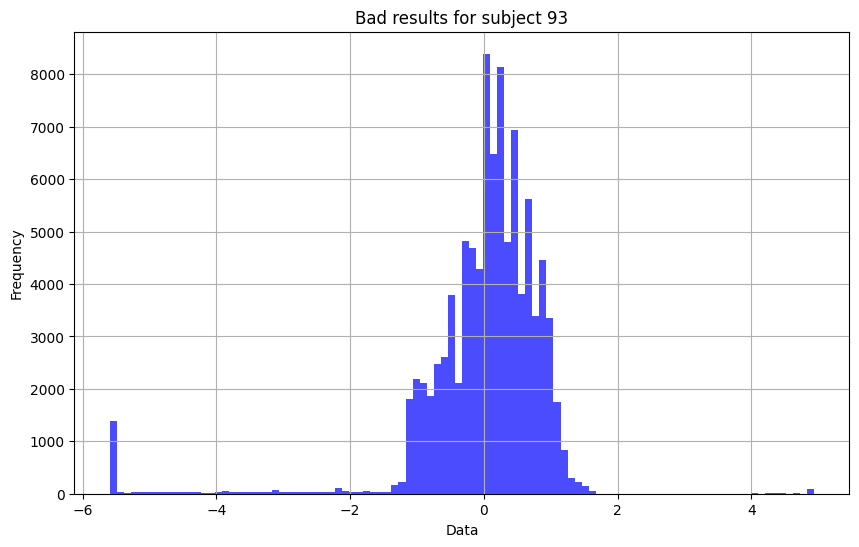

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


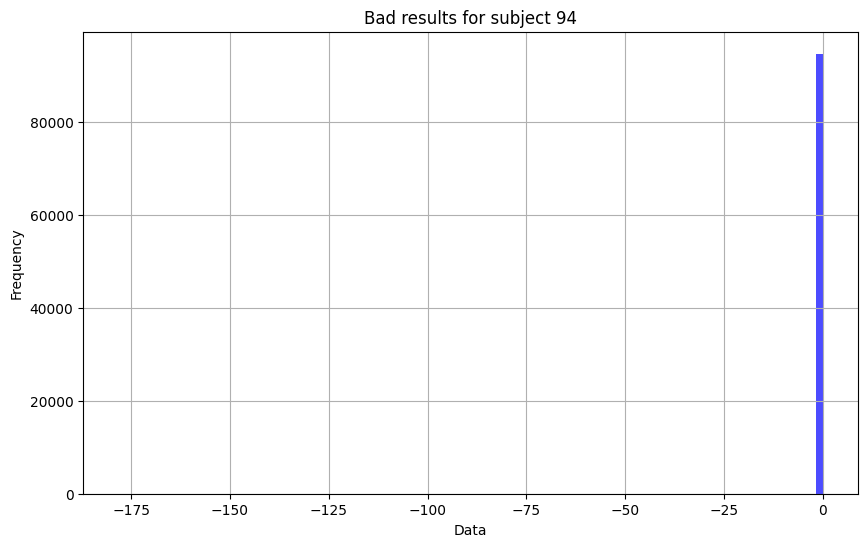

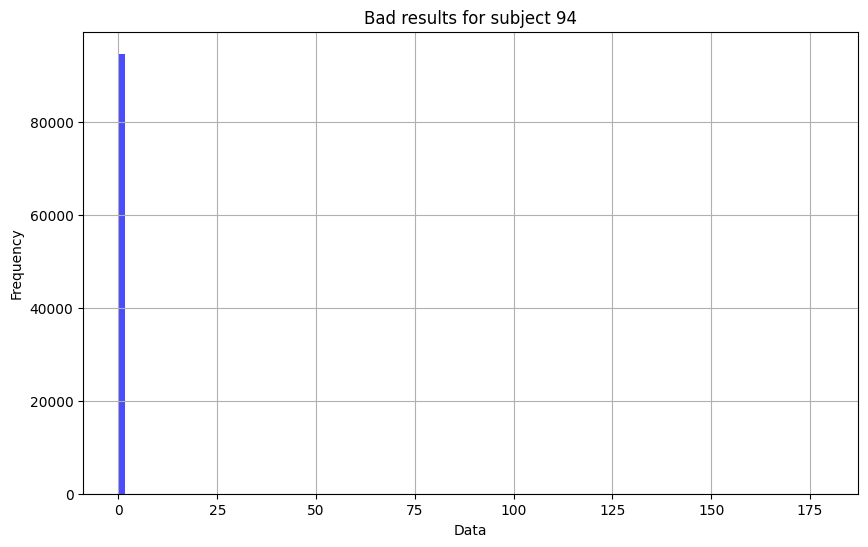

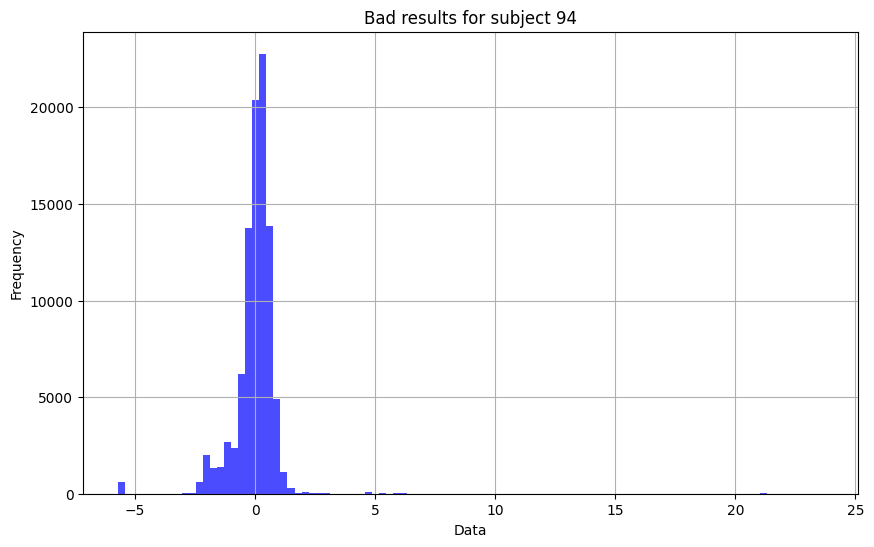

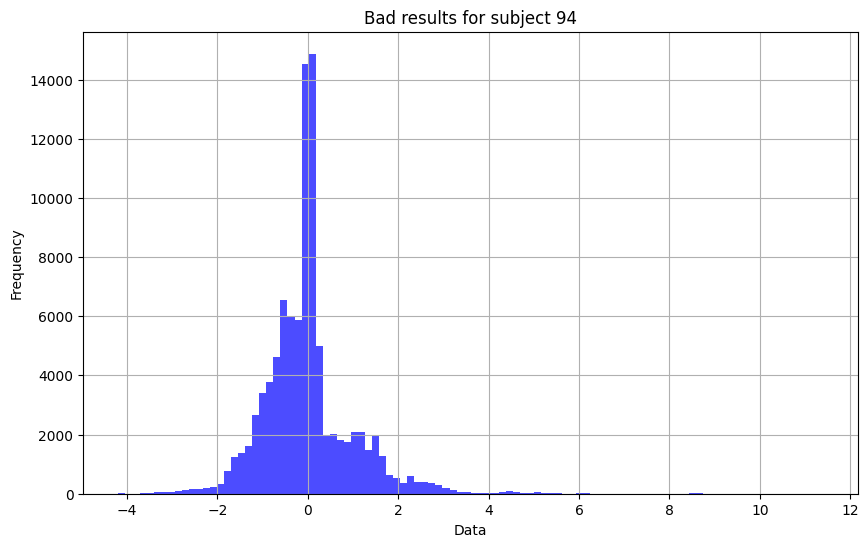

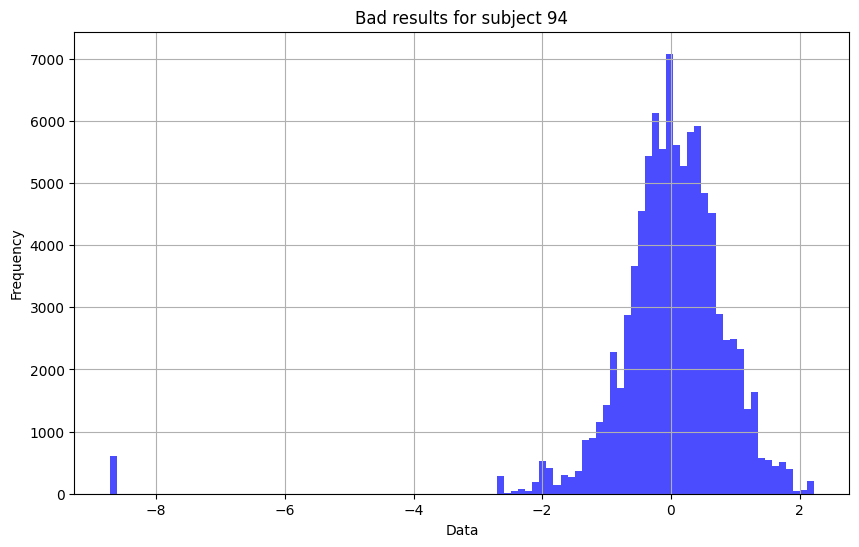

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
c:\Users\Tobii\Projects\oasisnn\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


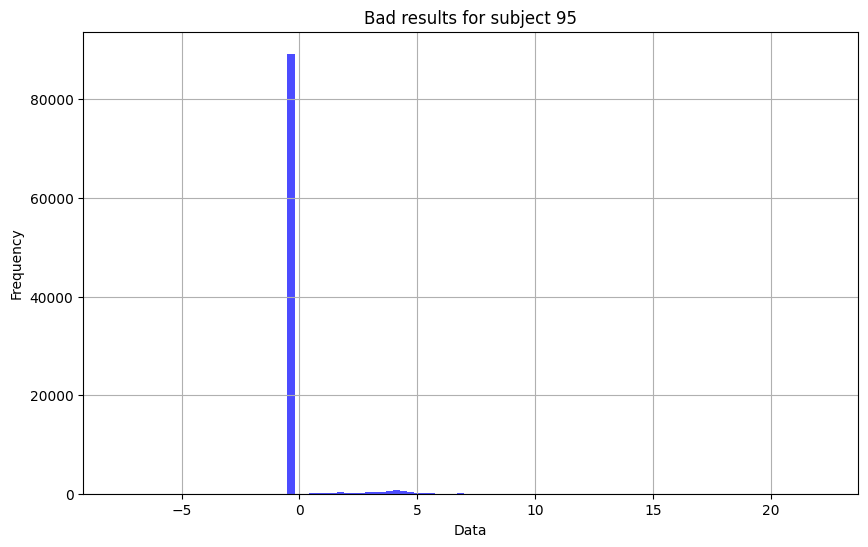

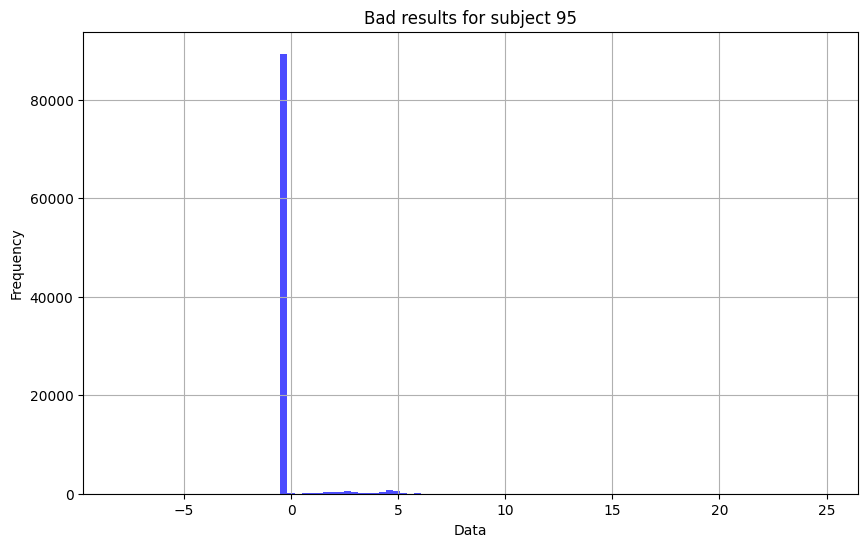

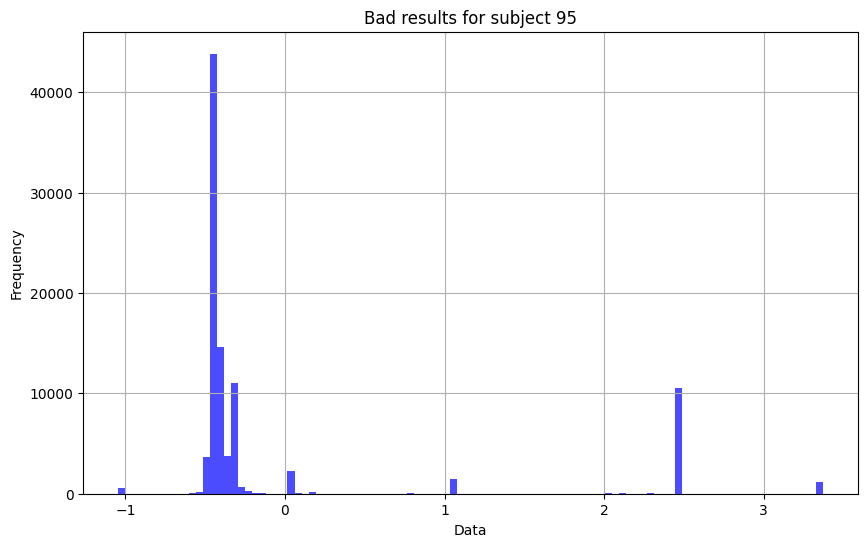

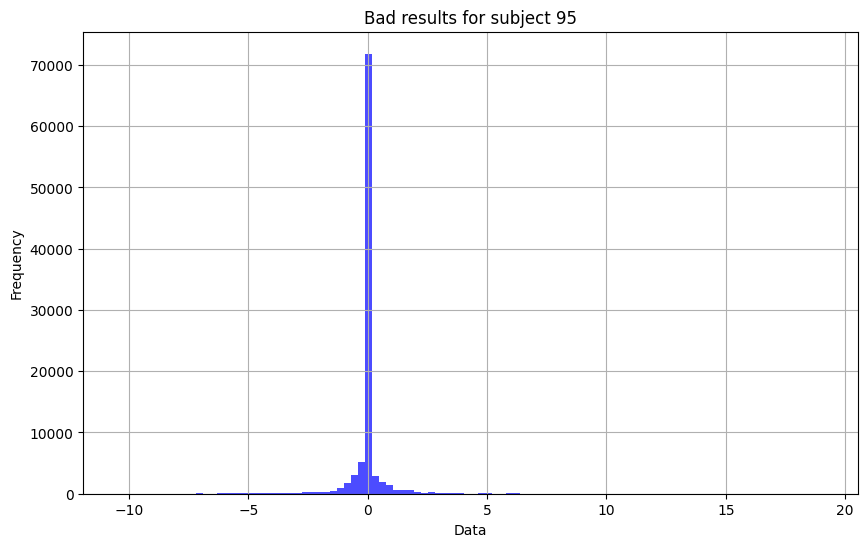

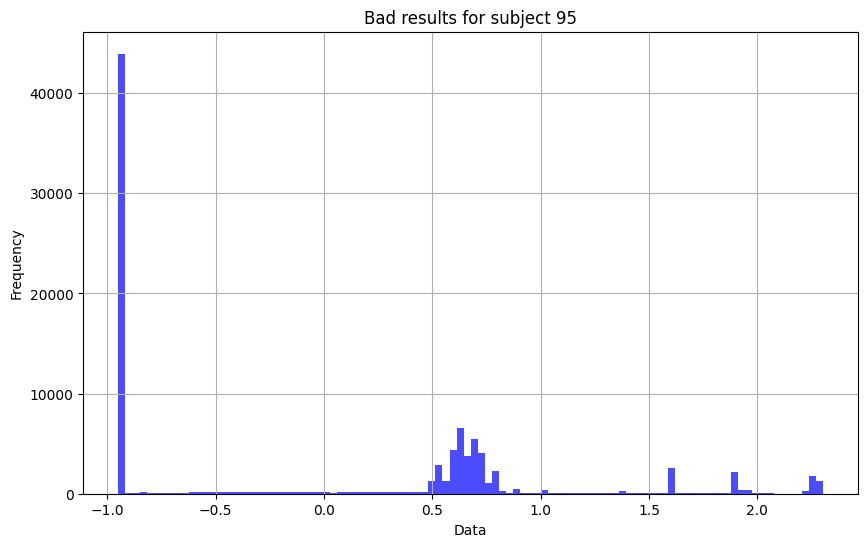

In [26]:
bad_data = [107, 113, 114, 115, 117, 118, 121, 125, 128, 129, 134, 136, 141, 142, 143, 146, 150, 15, 18, 45, 93, 94, 95]

bad_shape = [148, 32, 36, 38, 52, 61, 75, 92]

for subject in bad_data:
    ts, labels = preprocess_gaze(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
    fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv')
    ts = zscore(ts, axis=(0, 1))
    for i, feat_name in enumerate(['FPOGX', 'FPOGY', 'mean_PMM', 'GSR', 'HR']):
        data = np.reshape(ts[:, :, i], -1)
        fig = plot_distribution(data, title=f'{feat_name}, Shapiro p: {sp.stats.shapiro(data).pvalue}', bins=100)
        plt.title(f"Bad results for subject {subject}")
        plt.show()

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


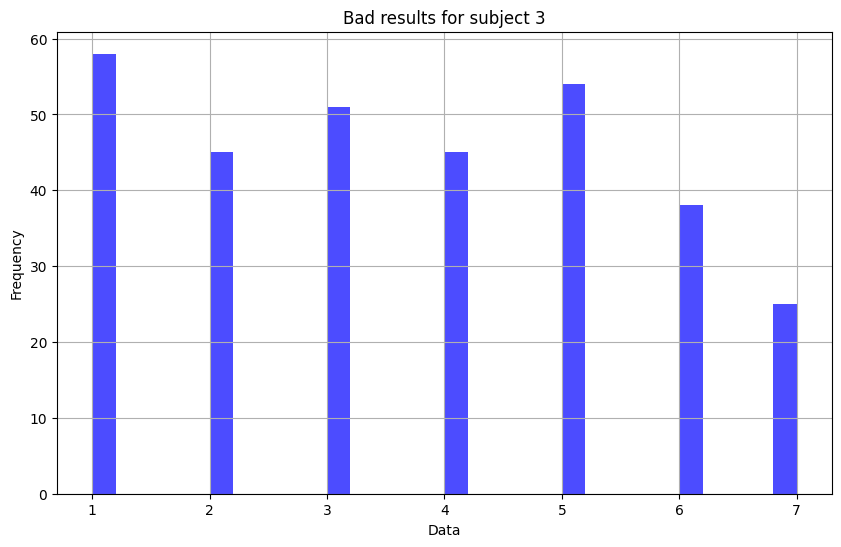

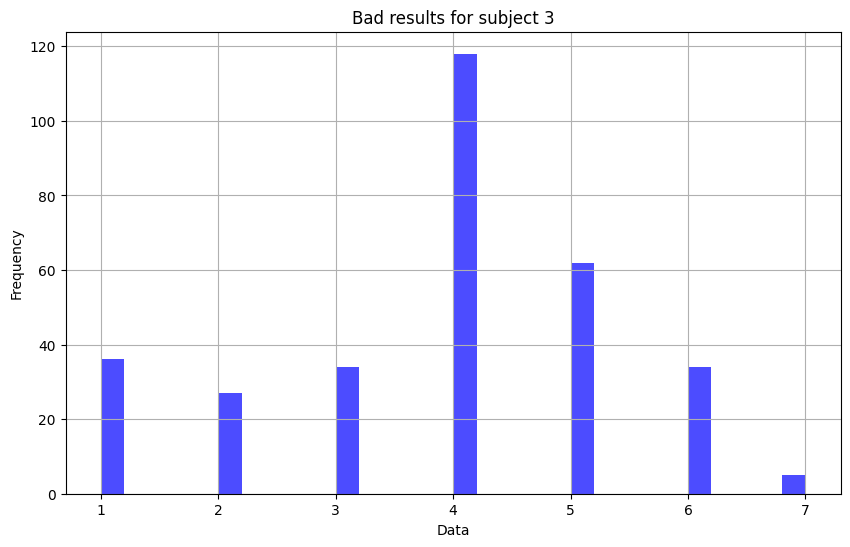

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


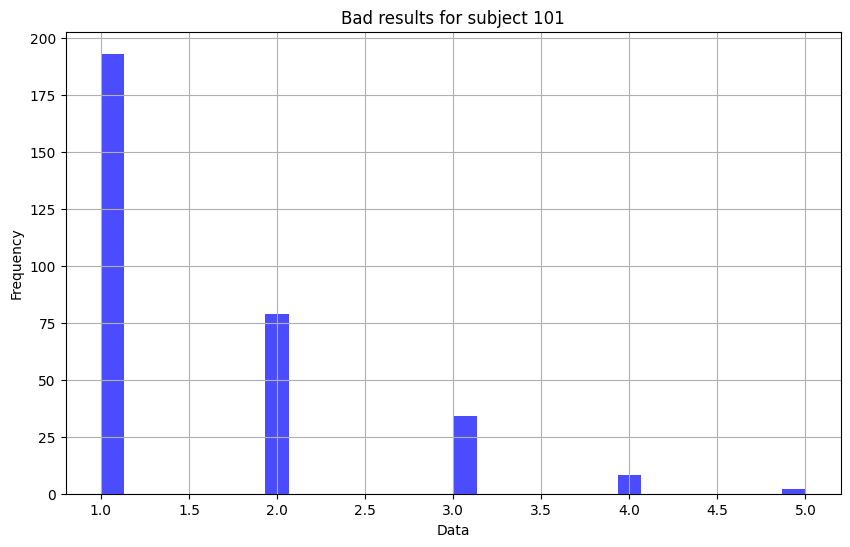

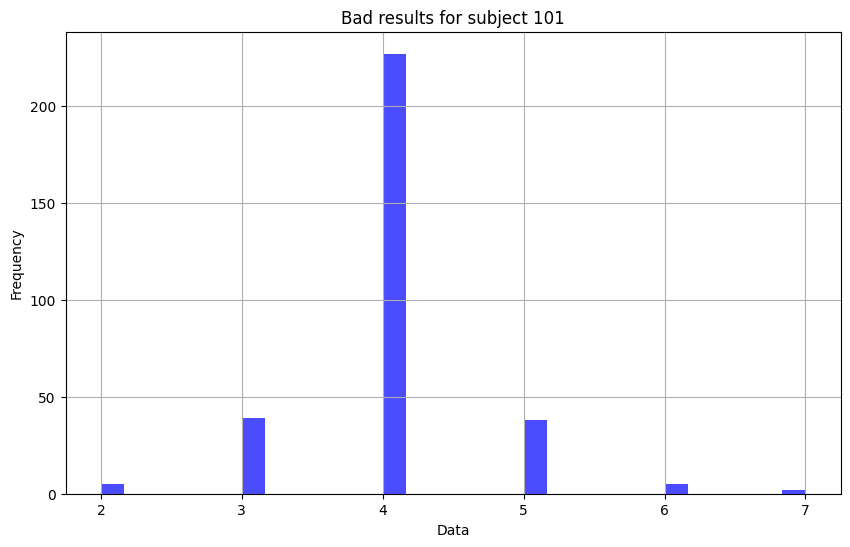

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


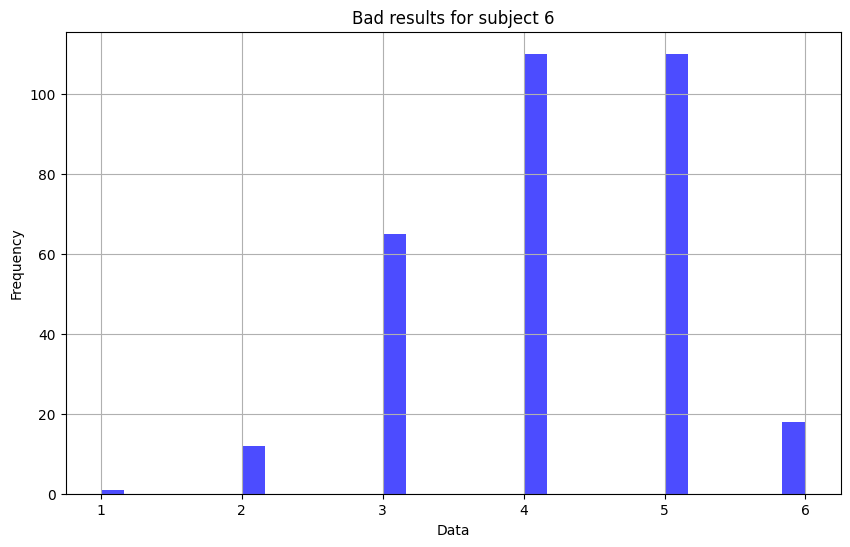

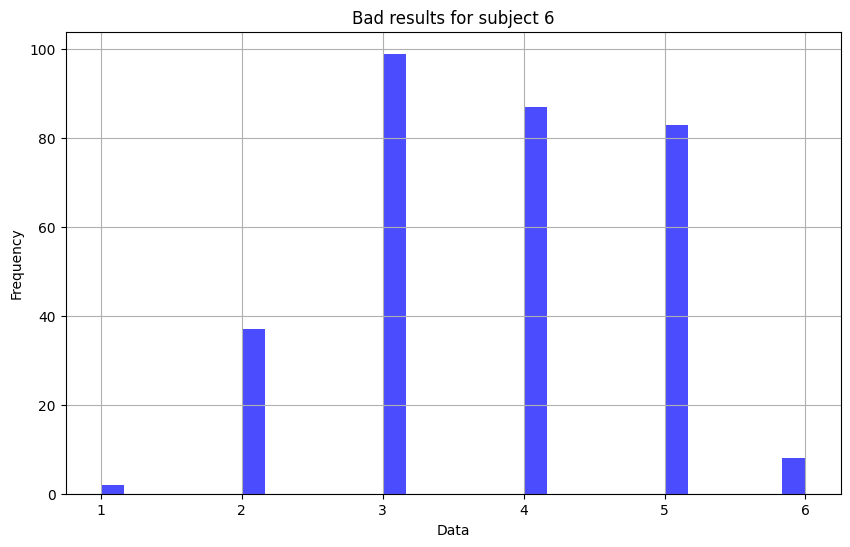

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


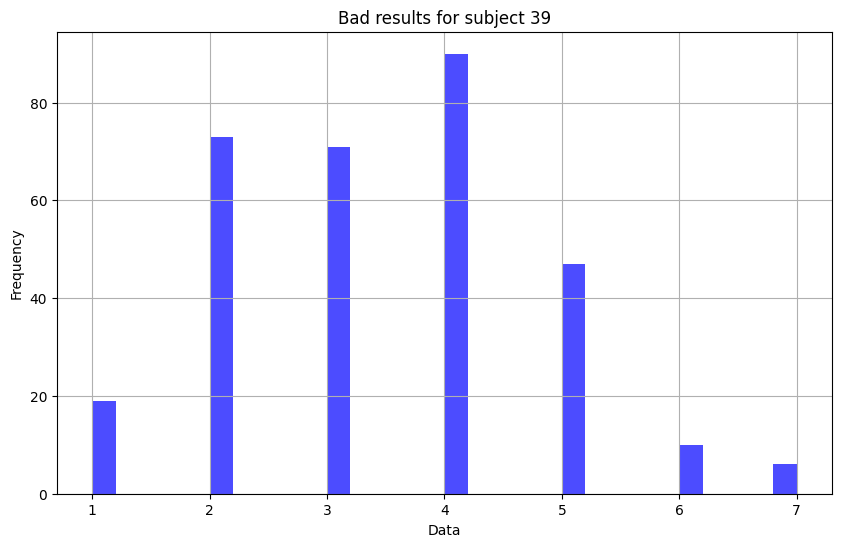

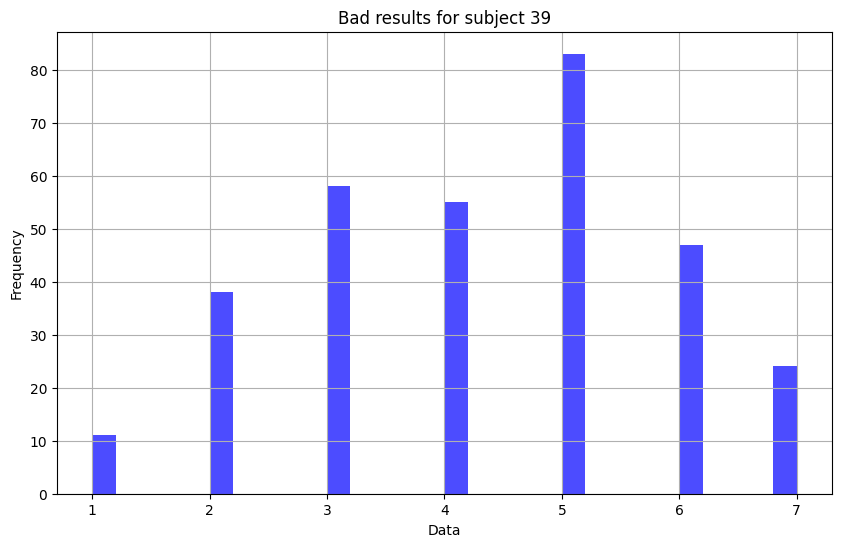

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


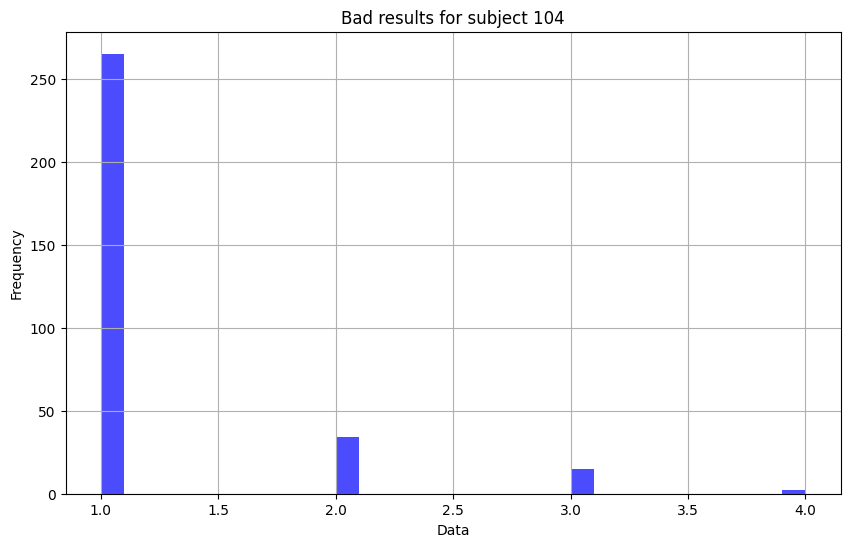

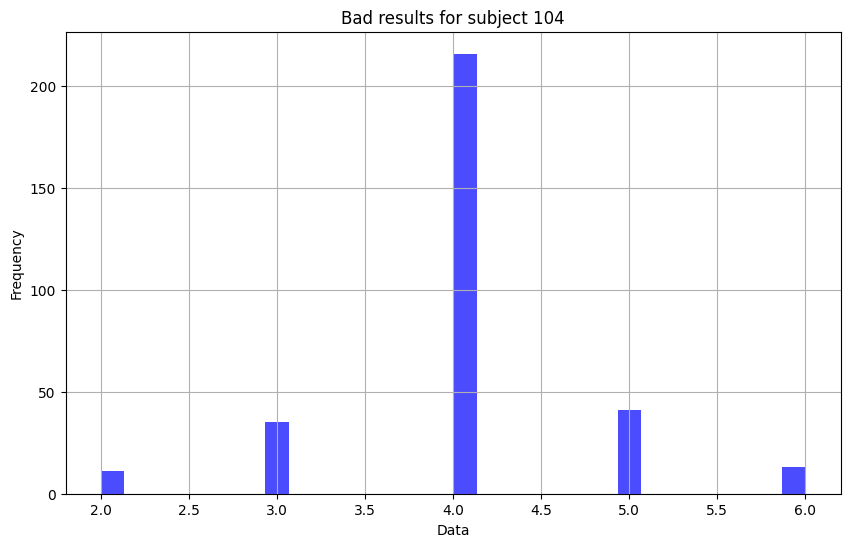

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


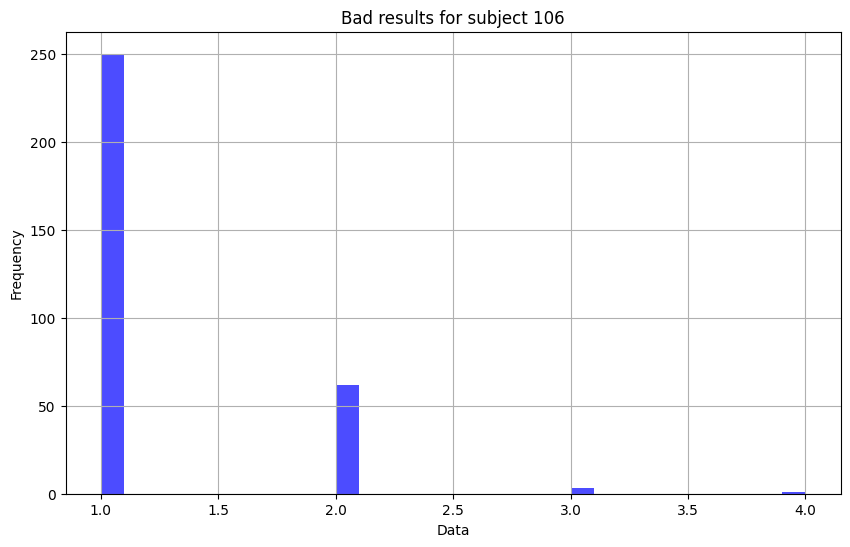

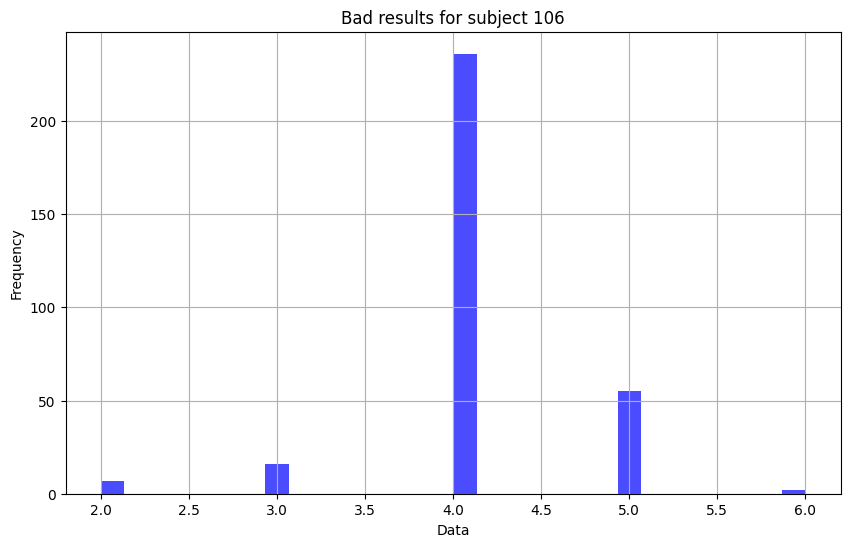

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


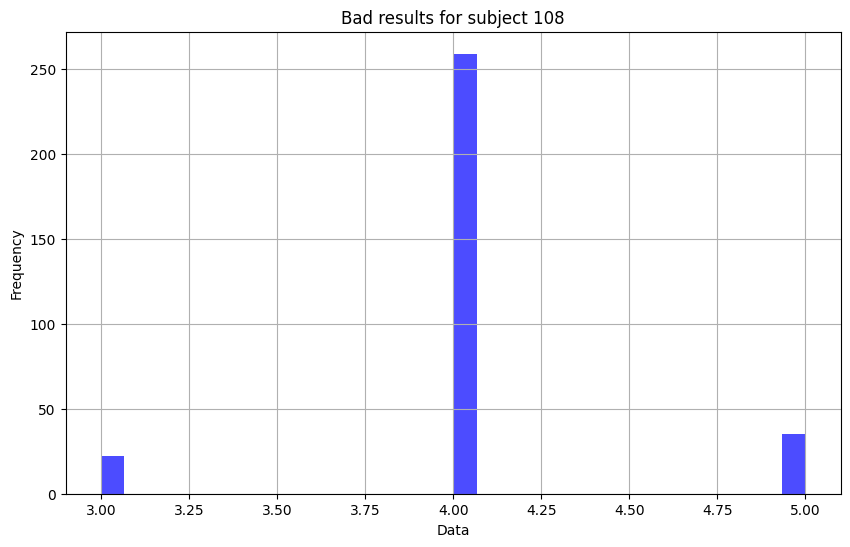

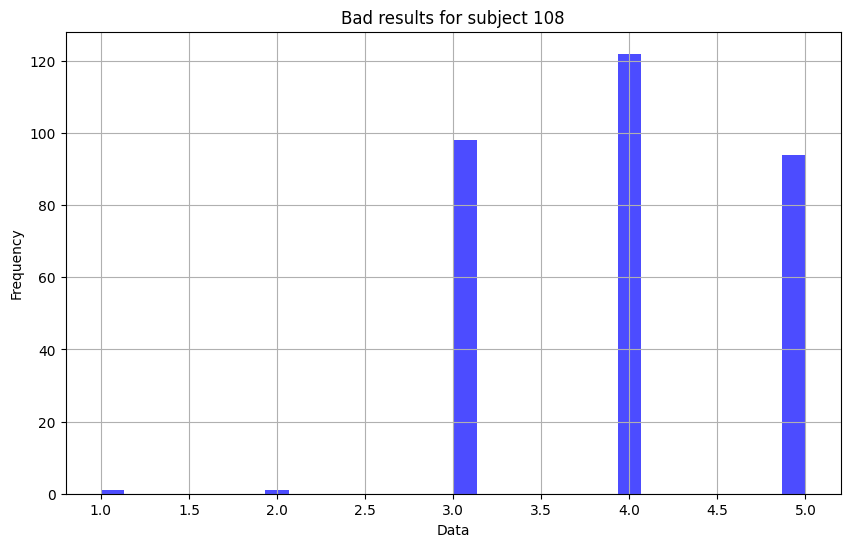

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


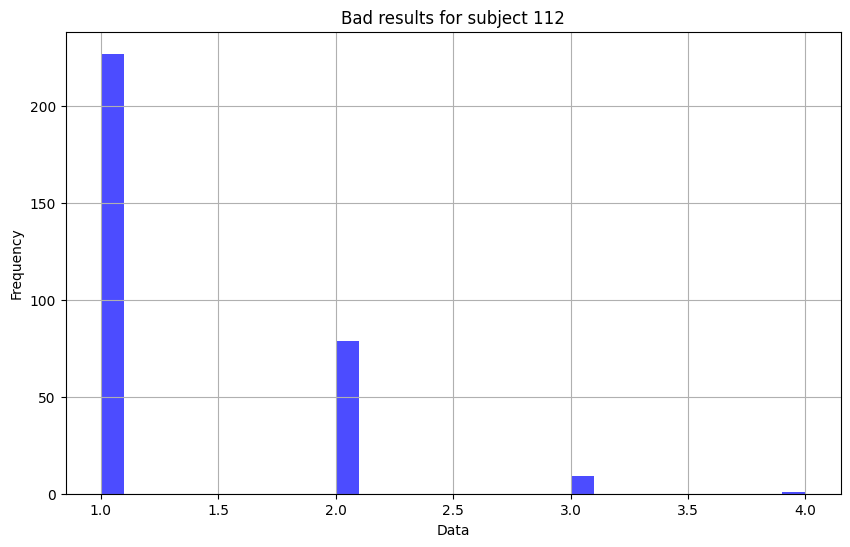

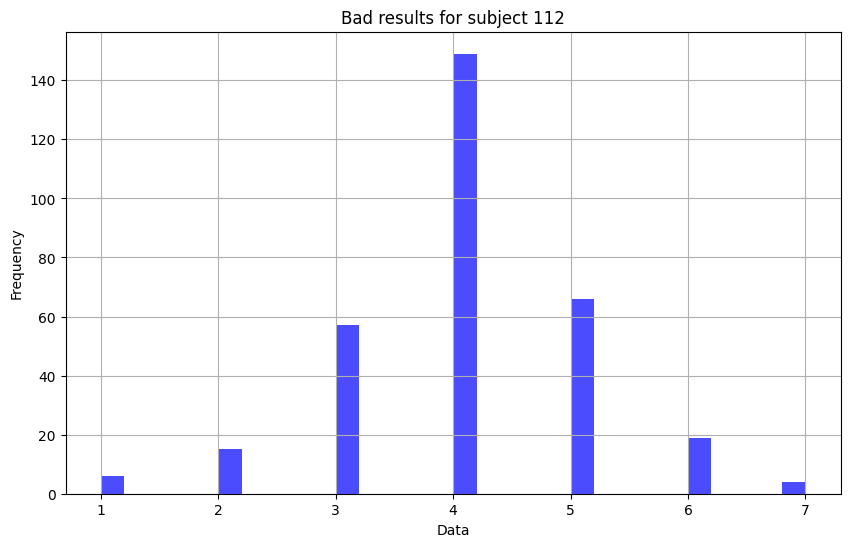

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1


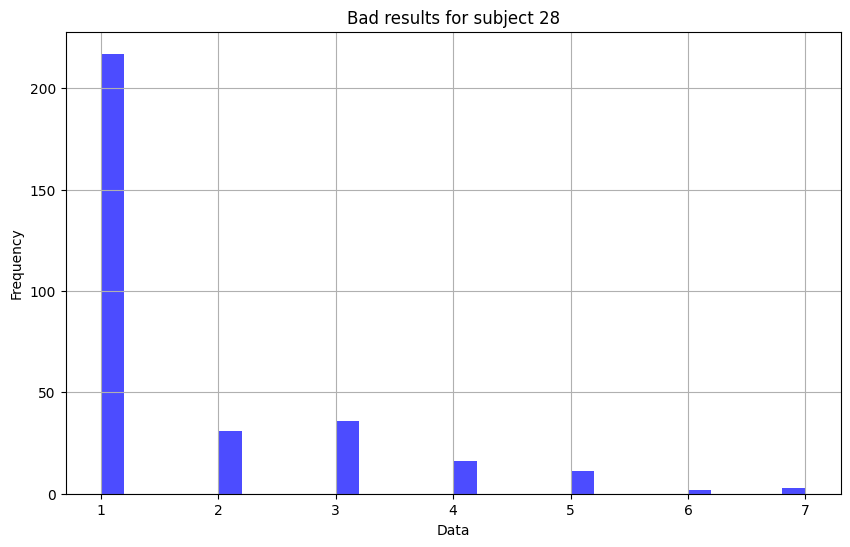

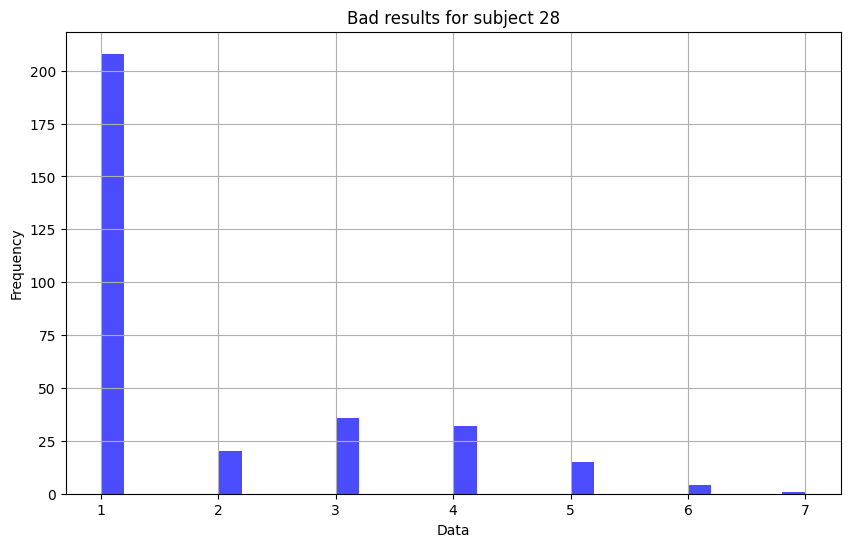

In [28]:
bad_results =  set([101, 104, 106, 108, 112, 28, 39, 3, 6])

for subject in bad_results:
    ts, labels = preprocess_gaze(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
    fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv')
    for i, label_type in enumerate(['arousal', 'valence']):
        fig = plot_distribution(labels[:, i], title=label_type)
        plt.title(f"Bad results for subject {subject}")
        plt.show()

In [29]:
set1 = set(range(0, 153))
set2 = set(bad_shape)
set3 = set(bad_results)
set4 = set(bad_data)
dont_exist = [98, 99, 37]
set5 = set(dont_exist)
norm_subjects = list(set1 - set2 - set3 -set4 - set5)

In [30]:
all_time_series = []
all_ar_val = []

for subject in norm_subjects:
    ts, labels = preprocess_gaze(
    fr'C:\Users\Tobii\Downloads\ALL GAZE\ALL GAZE\User {subject}_all_gaze.csv',
    fr'C:\Users\Tobii\Downloads\OASIS OS FILES\OASIS OS FILES\subject-{subject}.csv')
    all_time_series.append(ts)
    all_ar_val.append(labels)

C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\Tobii\AppData\Local\Temp\ipykernel_2124\2678055643.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze['ep_begin'][counter] = 1
C:\Users\T

In [ ]:
import torch
import matplotlib.pyplot as plt

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AE()

loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)

metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
)

In [ ]:
history = model.fit(train, n_epochs=100, batch_size=400, val_batch_size=200)
plot_metrics(history)